In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime
import plotly.express as px
from pandas import Series
import math

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error 

from tqdm import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

In [130]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [131]:
# класс для построения визуализация для числового признака и нахождения выбросов.

class AnalyzNumCol():
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False):
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))
        
        fig.suptitle('Histogram, QQ-plot and boxplot for {0} '.format(column))
        ax1.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'red')
        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax2) 
        
        
        
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def emission_limits(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def amount_emissions(self, log = False): 
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.emission_limits(log)
        return len(data[data < minb])+ len(data[data > maxb])

    
# класс логарифмирования признака
    
class LogDf(): 
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 

# 1. Просмотреть данные представленные в таблице

In [132]:
data = pd.read_csv('data.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
restaurants = pd.read_csv('restaurants.csv')


In [133]:
name_data = [data, restaurants, train, test]

In [134]:
data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%y")
train['Date'] = pd.to_datetime(train['Date'], format="%d-%m-%y")
test['Date'] = pd.to_datetime(test['Date'], format="%d-%m-%y")


In [135]:
for dat in name_data:
    print(100*'-')
    print(dat.info())
    print()
    print(dat.head())
    

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   City          3640 non-null   int64         
 1   Date          3640 non-null   datetime64[ns]
 2   Temperature   3640 non-null   float64       
 3   Fuel_Price    3640 non-null   float64       
 4   Unemployment  3380 non-null   float64       
 5   IsHoliday     3640 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 145.9 KB
None

   City       Date  Temperature  Fuel_Price  Unemployment  IsHoliday
0     1 2010-02-05        42.31       2.572         8.106      False
1     1 2010-02-12        38.51       2.548         8.106       True
2     1 2010-02-19        39.93       2.514         8.106      False
3     1 2010-02-26        46.63

In [136]:
for dat in name_data:
    print(100*'-')
    print(dat.describe())
    print()

----------------------------------------------------------------------------------------------------
              City  Temperature   Fuel_Price  Unemployment
count  3640.000000  3640.000000  3640.000000   3380.000000
mean     10.500000    59.166354     3.378593      7.414191
std       5.767074    18.788846     0.427207      1.678688
min       1.000000    -7.290000     2.514000      3.879000
25%       5.750000    45.872500     3.015500      6.380000
50%      10.500000    60.640000     3.479000      7.290000
75%      15.250000    73.967500     3.707500      8.106000
max      20.000000   101.950000     4.468000     14.313000

----------------------------------------------------------------------------------------------------
           City           Size
count  20.00000      20.000000
mean   10.50000  142749.300000
std     5.91608   61683.245197
min     1.00000   34875.000000
25%     5.75000  107475.500000
50%    10.50000  138913.500000
75%    15.25000  202814.250000
max    20.00000  2

In [137]:
data['Date'].describe()

<ipython-input-137-c2526e25cc24>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['Date'].describe()


count                    3640
unique                    182
top       2011-07-15 00:00:00
freq                       20
first     2010-02-05 00:00:00
last      2013-07-26 00:00:00
Name: Date, dtype: object

In [138]:
train['Date'].describe()

<ipython-input-138-419e7308995d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train['Date'].describe()


count                  137938
unique                    100
top       2011-11-25 00:00:00
freq                     1423
first     2010-02-05 00:00:00
last      2011-12-30 00:00:00
Name: Date, dtype: object

In [139]:
test['Date'].describe()

<ipython-input-139-f2c327ca4108>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  test['Date'].describe()


count                   59611
unique                     43
top       2012-02-17 00:00:00
freq                     1411
first     2012-01-06 00:00:00
last      2012-10-26 00:00:00
Name: Date, dtype: object

Вывод
------
Вставлять пропущенные данные не имеет необходимости

In [140]:
for dat in name_data:
    print(100*'-')
    for column in dat.columns:
        print(100*'*')
        print(column)
        print(dat[column].value_counts())

----------------------------------------------------------------------------------------------------
****************************************************************************************************
City
19    182
17    182
4     182
6     182
8     182
10    182
12    182
14    182
16    182
18    182
20    182
1     182
3     182
5     182
7     182
9     182
11    182
13    182
15    182
2     182
Name: City, dtype: int64
****************************************************************************************************
Date
2011-07-15    20
2013-05-24    20
2012-09-07    20
2010-02-26    20
2011-12-23    20
              ..
2013-03-22    20
2010-09-10    20
2012-07-06    20
2011-10-21    20
2012-03-30    20
Name: Date, Length: 182, dtype: int64
****************************************************************************************************
Temperature
72.62    6
59.94    5
49.96    5
40.65    4
50.43    4
        ..
63.54    1
77.90    1
84.13    1
29.87    1
43.31    1
Nam

Вывод
------

   1. Данные из таблицы "data":
      - Привести данные в столбце date к значениям datetime
      - В столбце "Unemployment" присутсвует пропуски, которые необходимо запонить
      - оценить данные на выбросы
   2. Данные таблицы restaurants не понятны и требуют дополнительного изучения
   3. Данные таблиц показали, что даны абсолютные показатели. Для улучшения результатов необходимо добавть новые фичи, учитывающие динамику изменения

# 2. Предобработка данных

In [141]:
data['week'] = data['Date'].dt.week
data['month'] = data['Date'].dt.month

<ipython-input-141-b3404e34f09e>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['week'] = data['Date'].dt.week


In [142]:
data.head()

City       Date  Temperature  Fuel_Price  Unemployment  IsHoliday  week  \
0     1 2010-02-05        42.31       2.572         8.106      False     5   
1     1 2010-02-12        38.51       2.548         8.106       True     6   
2     1 2010-02-19        39.93       2.514         8.106      False     7   
3     1 2010-02-26        46.63       2.561         8.106      False     8   
4     1 2010-03-05        46.50       2.625         8.106      False     9   

   month  
0      2  
1      2  
2      2  
3      2  
4      3

In [143]:
data[data['Unemployment'].isna()].Date.describe()

<ipython-input-143-34f6db5a59e4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data[data['Unemployment'].isna()].Date.describe()


count                     260
unique                     13
top       2013-06-07 00:00:00
freq                       20
first     2013-05-03 00:00:00
last      2013-07-26 00:00:00
Name: Date, dtype: object

In [144]:
test.Date.describe()

<ipython-input-144-9ea504b978f4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  test.Date.describe()


count                   59611
unique                     43
top       2012-02-17 00:00:00
freq                     1411
first     2012-01-06 00:00:00
last      2012-10-26 00:00:00
Name: Date, dtype: object

Вывод
------

Востанавливать пропущенные данные в столбце Unemployment не имеет смысла

# 3.1 Рассчитаем динамические темпы роста для таких показателей, как Fuel_Price, Unemployment

In [145]:
data = data.sort_values(by = ['City', 'Date'], ascending=True)

In [146]:
city_index = data.City.value_counts().index

In [147]:
data['inf'] = 0
data['unem'] = 0

In [148]:
for city in city_index:
    inf = None
    for index in data[data.City == city].index:
        if inf == None:
            data.loc[index, 'inf'] = None
            inf = 1
        else:
            inf = data.loc[index, 'Fuel_Price'] / data.loc[index - 1, 'Fuel_Price']
            data.loc[index, 'inf'] = inf

In [149]:
for city in city_index:
    unem = None
    for index in data[data.City == city].index:
        if unem == None:
            data.loc[index, 'unem'] = None
            unem = 1
        else:
            unem = data.loc[index, 'Unemployment'] / data.loc[index - 1, 'Unemployment']
            data.loc[index, 'unem'] = unem

In [150]:
data['unem'] = data['unem'].fillna(1)
data['inf'] = data['inf'].fillna(1)


# 3.2 проанализируем выбросы данных

Temperature

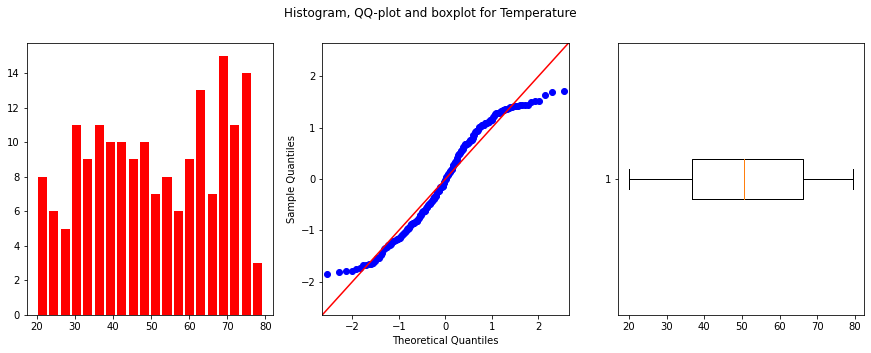

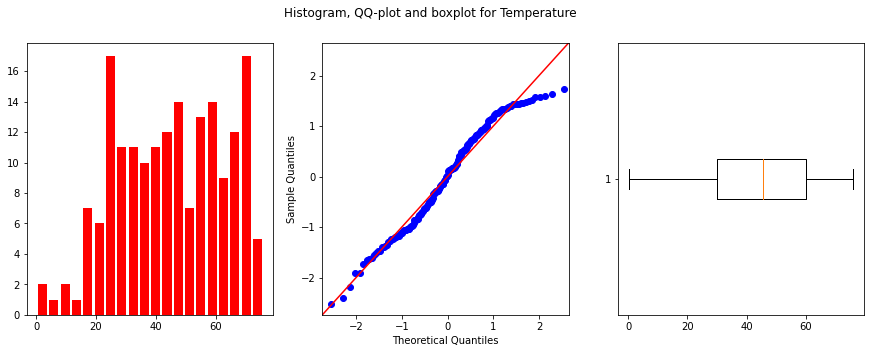

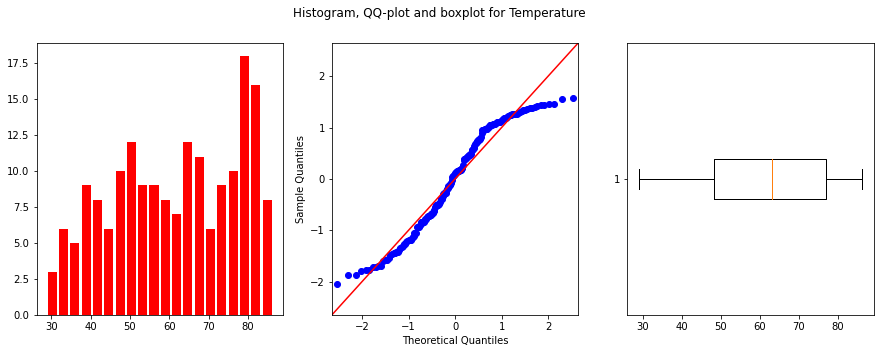

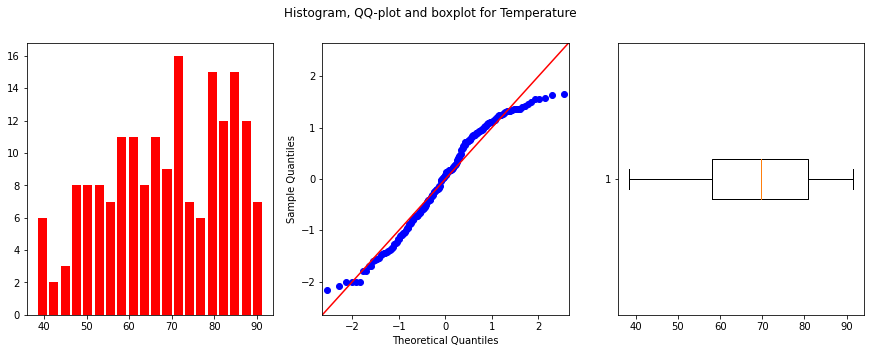

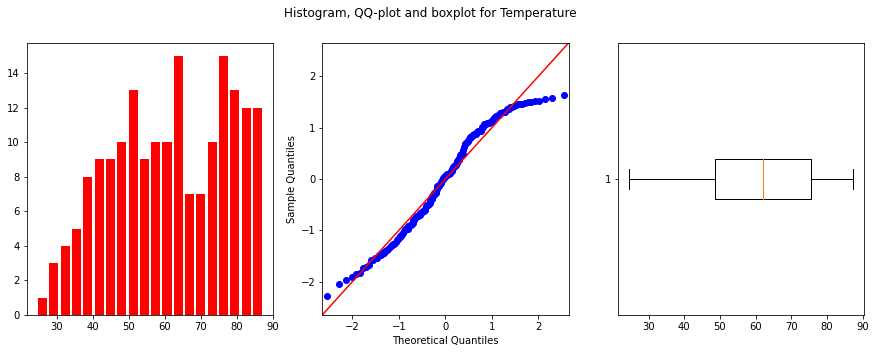

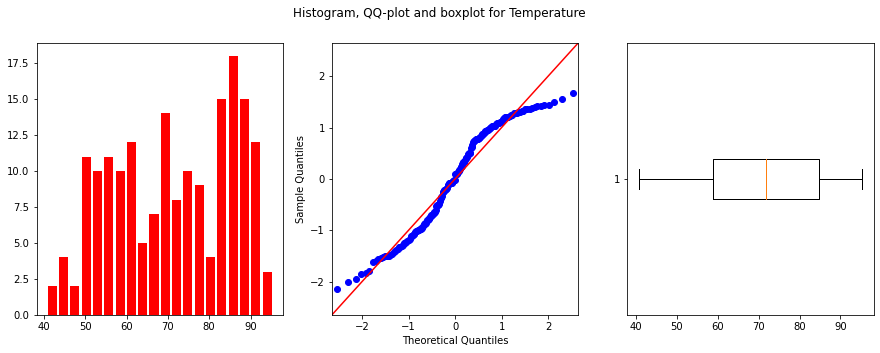

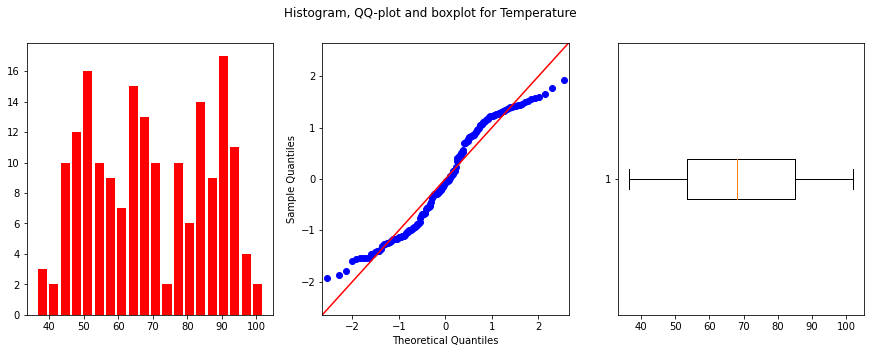

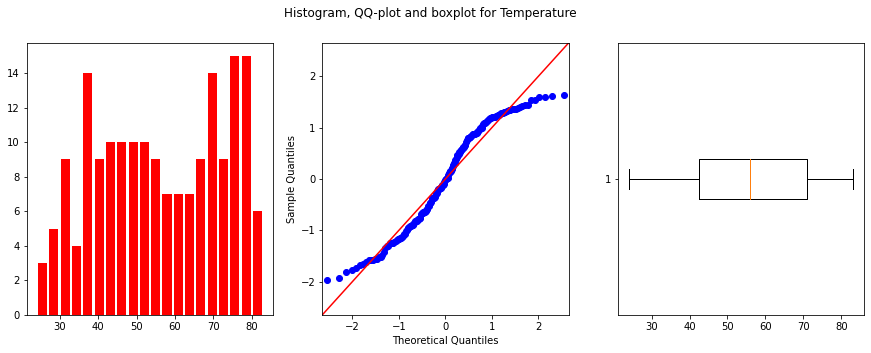

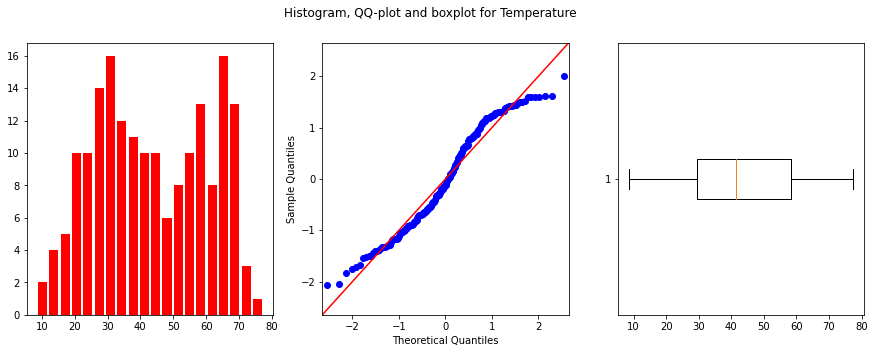

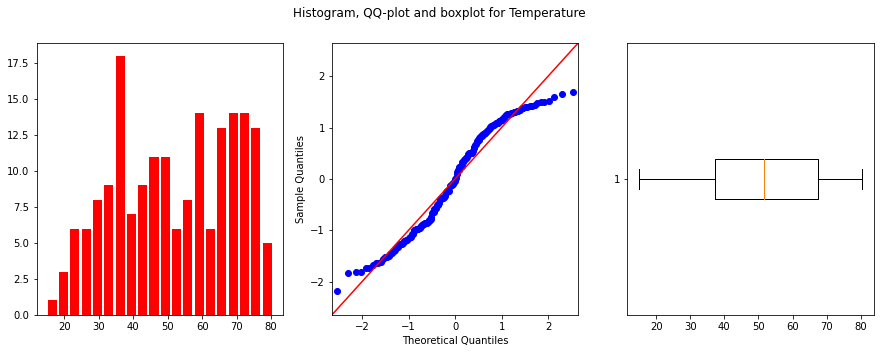

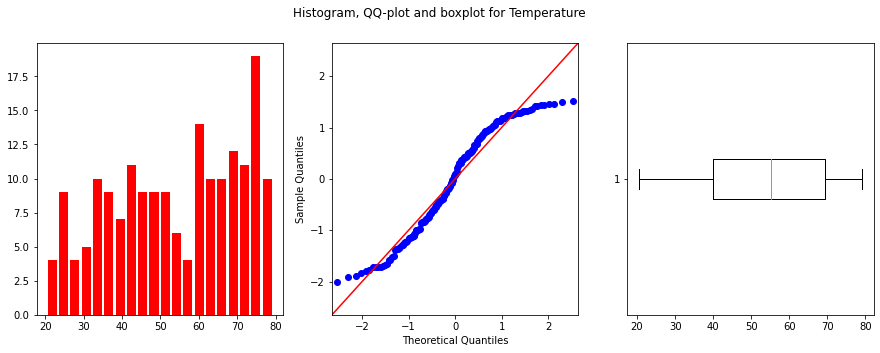

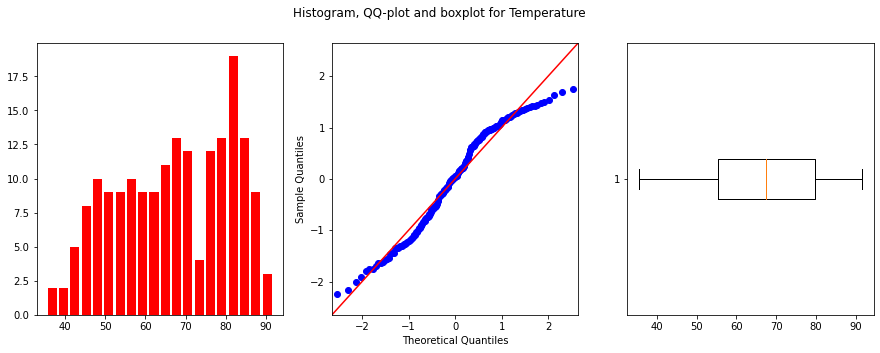

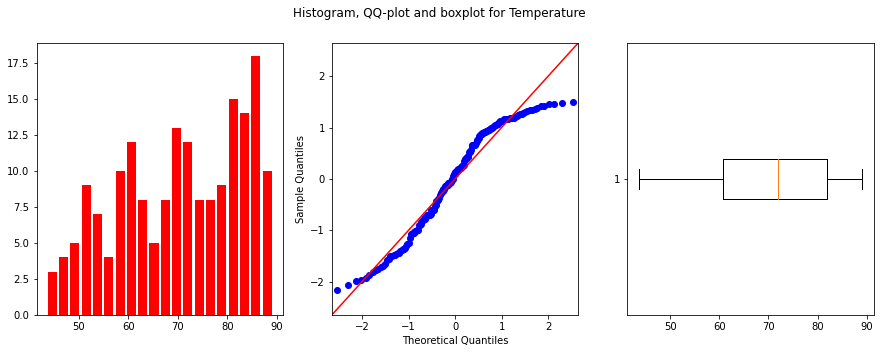

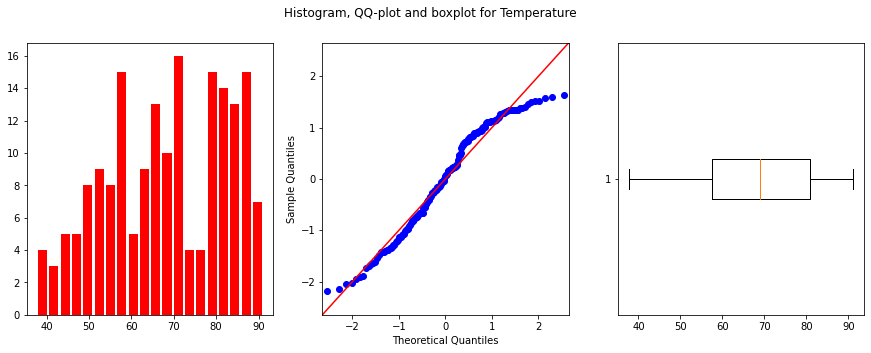

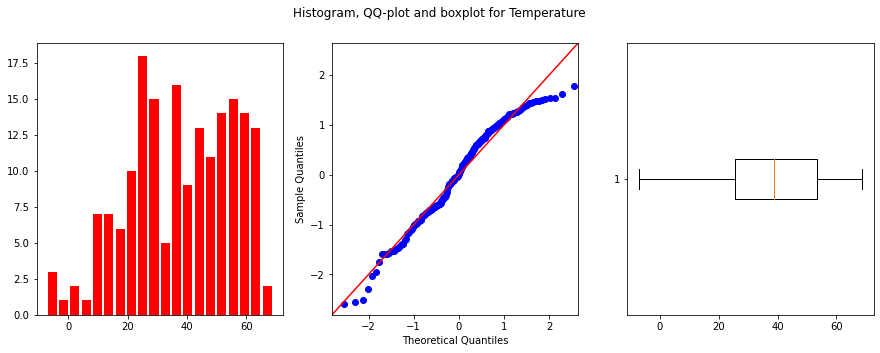

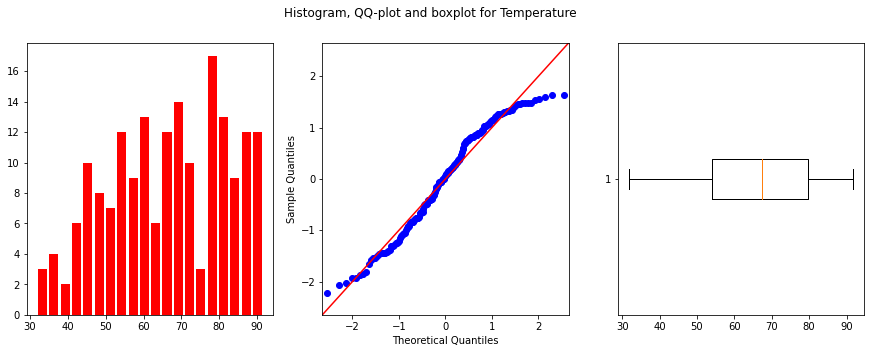

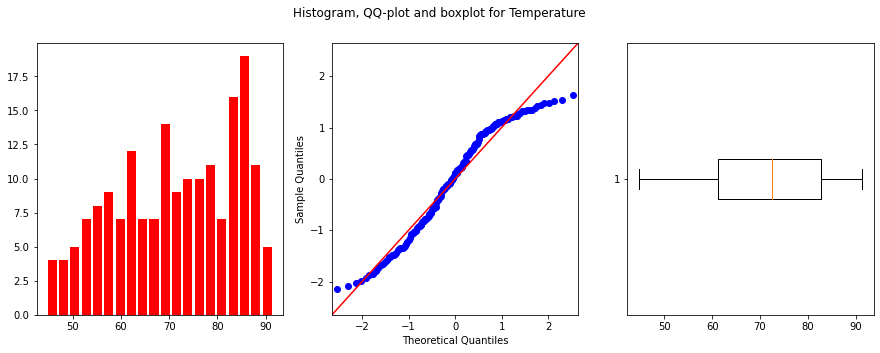

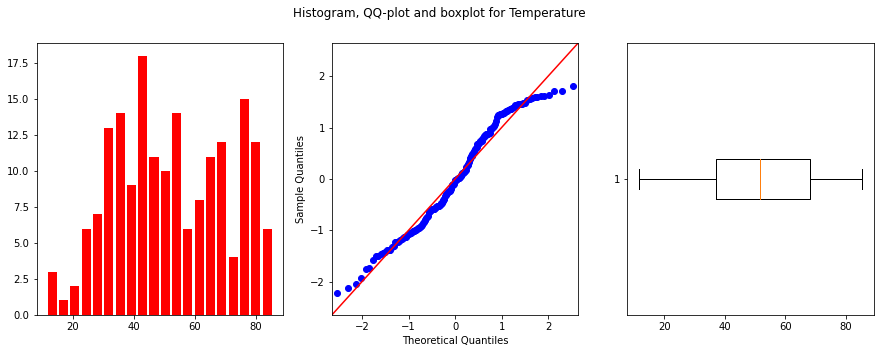

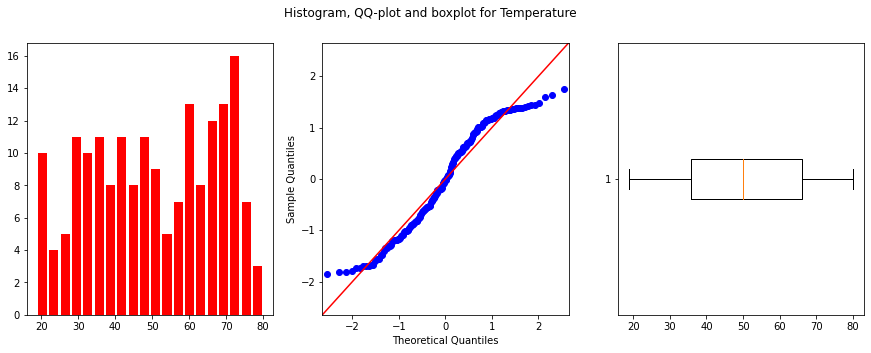

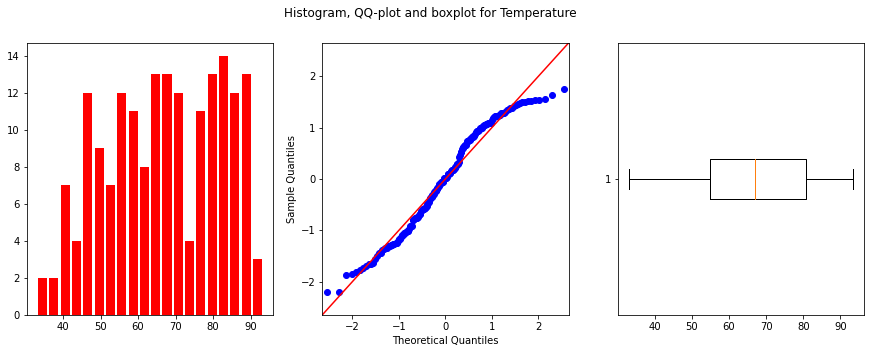

In [151]:
for city in city_index:
    temperature = AnalyzNumCol(data[data.City == city], 'Temperature')
    temperature.show_plots()


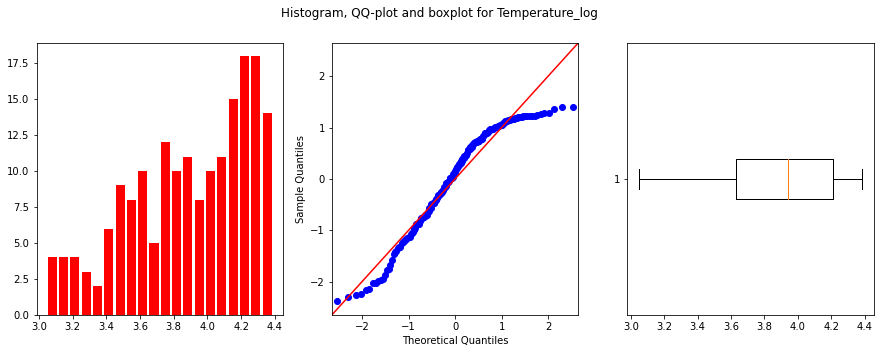

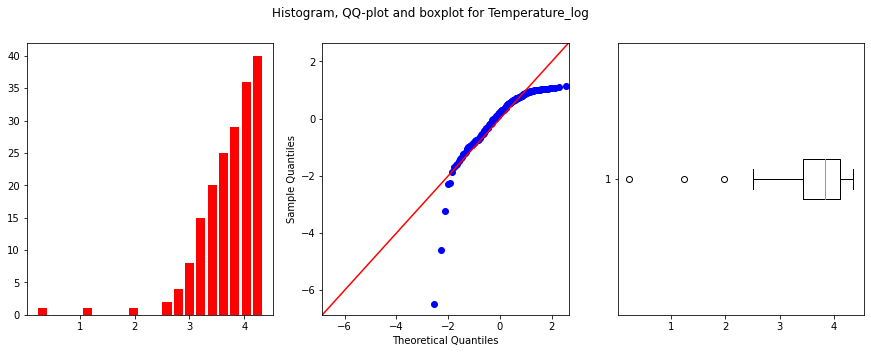

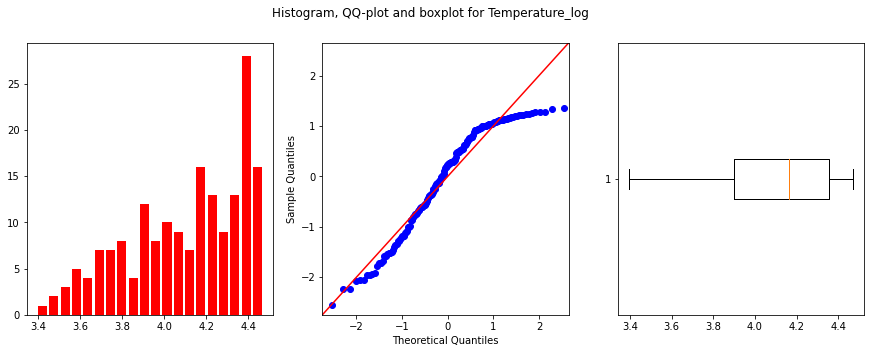

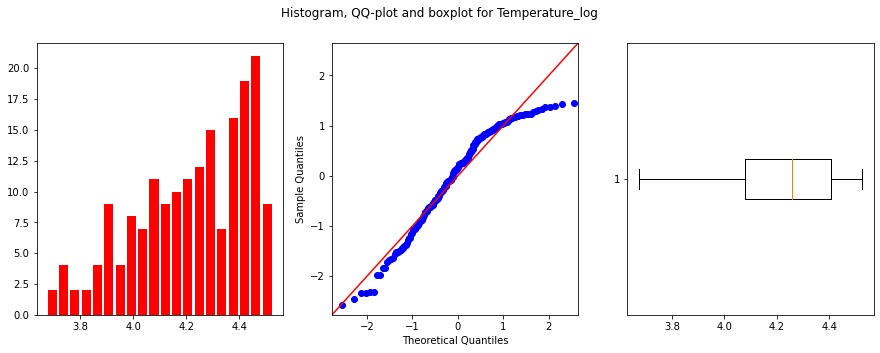

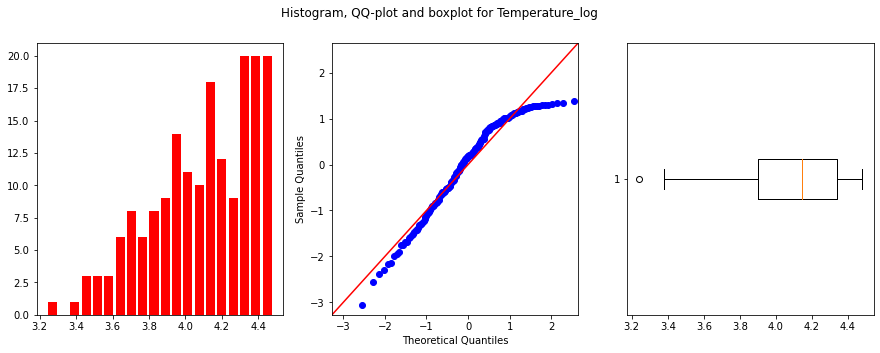

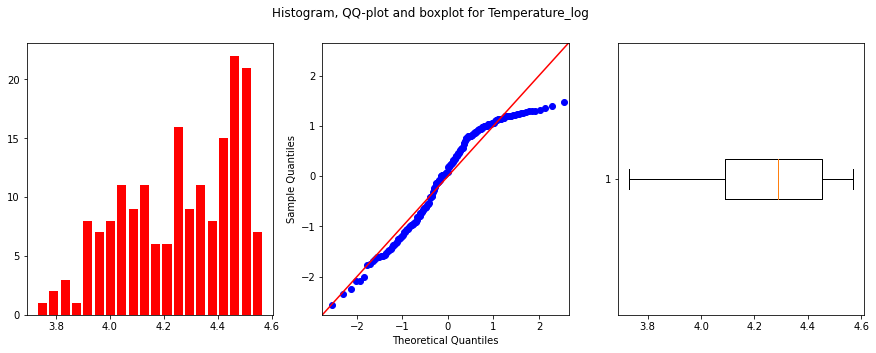

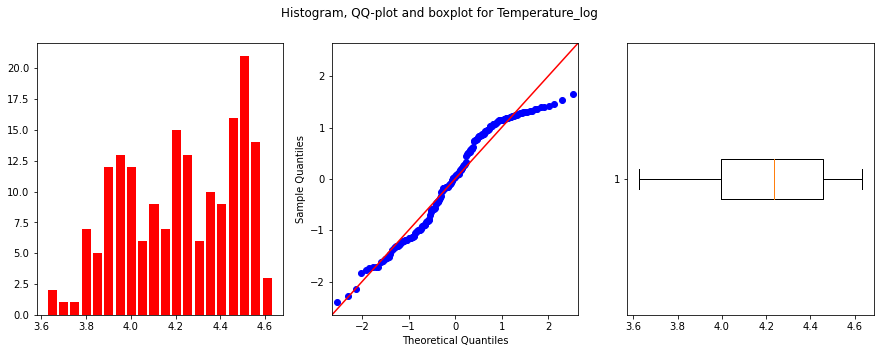

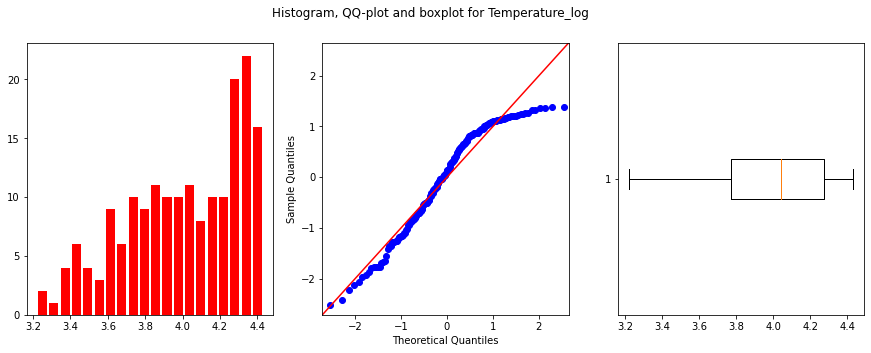

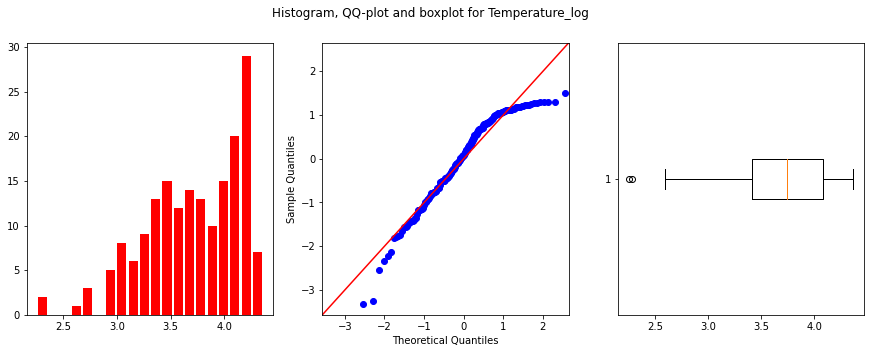

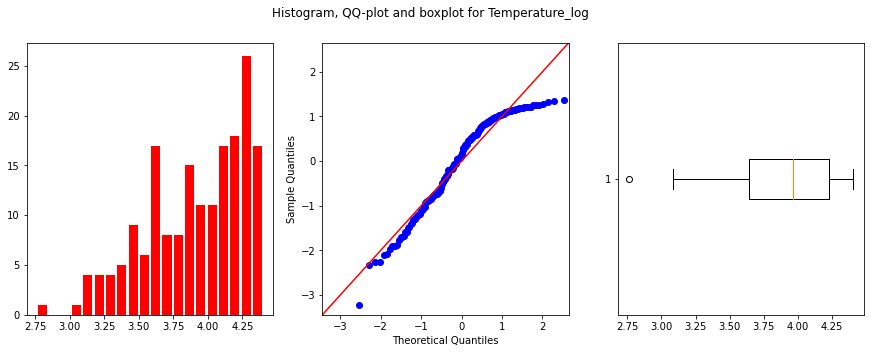

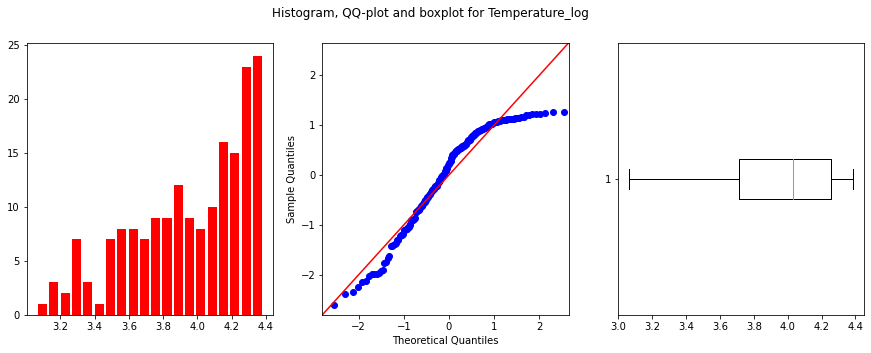

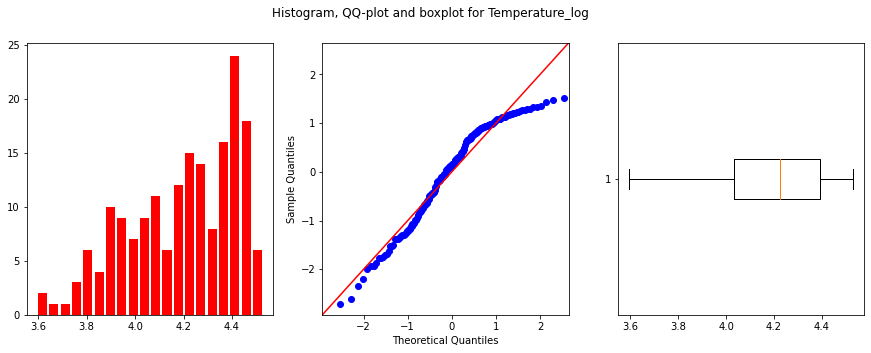

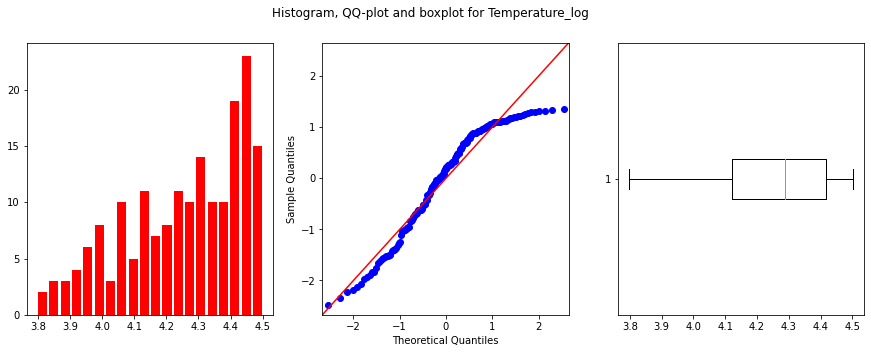

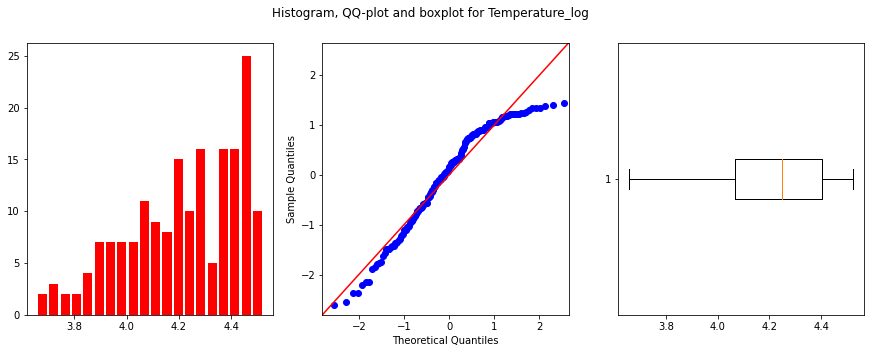

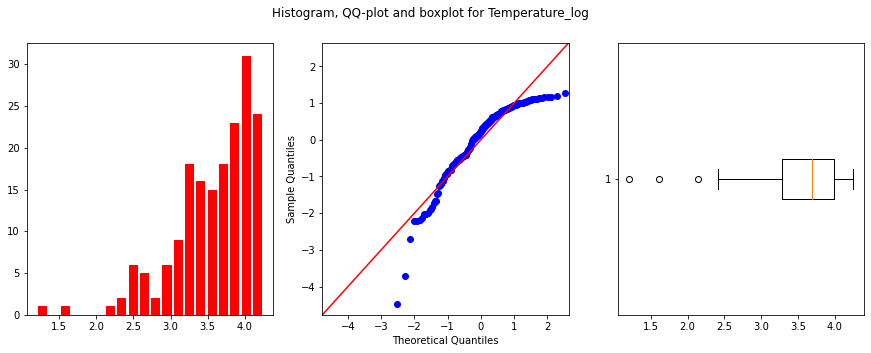

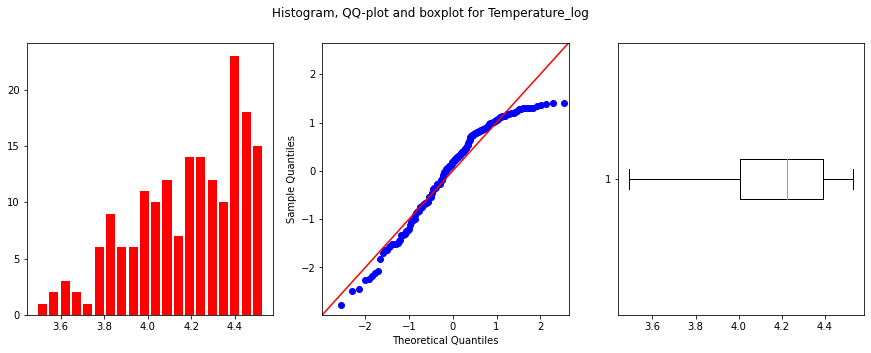

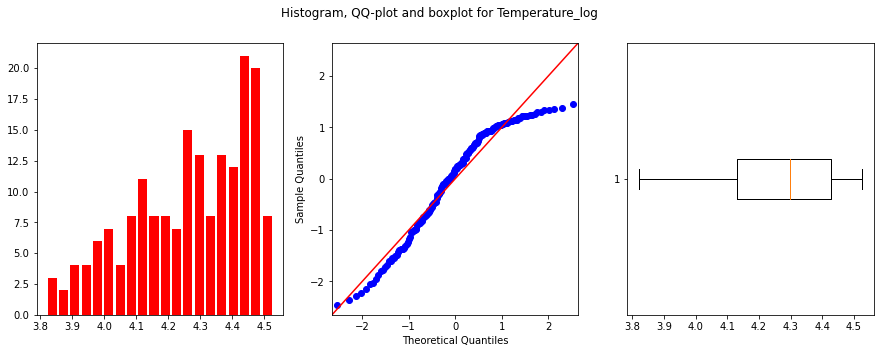

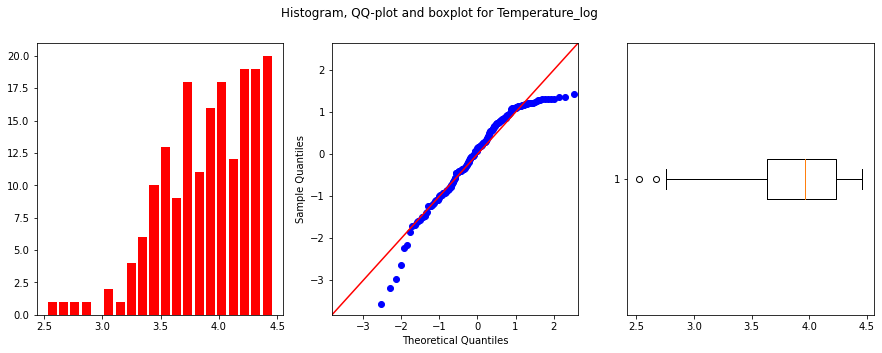

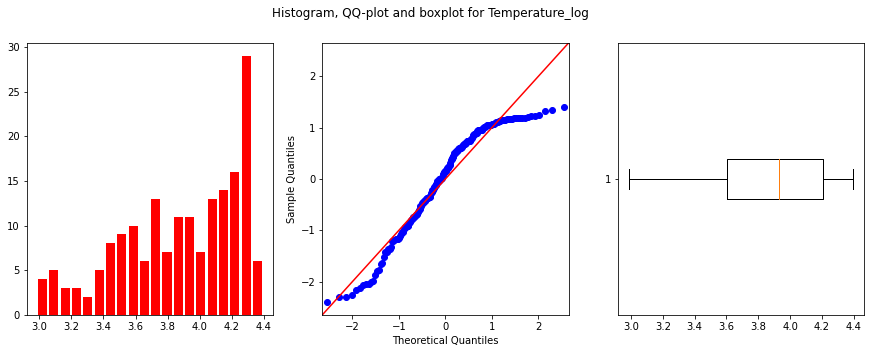

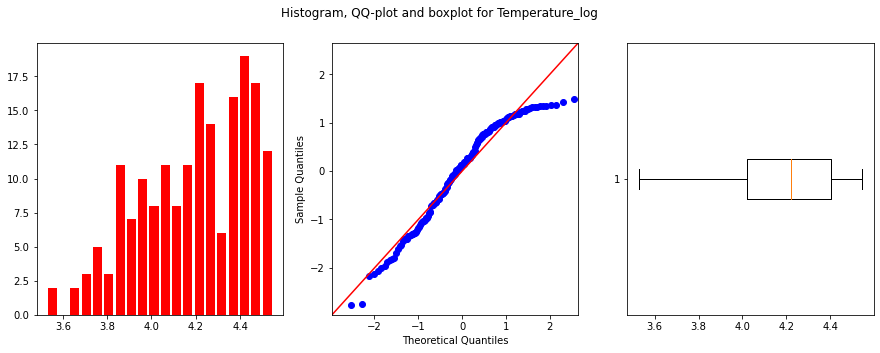

In [152]:
for city in city_index:
    temperature = AnalyzNumCol(data[data.City == city], 'Temperature')
    temperature.show_plots(log = True)

Вывод
------
Данные по столбцу temperature не содержат выбросы, при логорифмировании данных происходит ухудшение данных

Fuel_Price

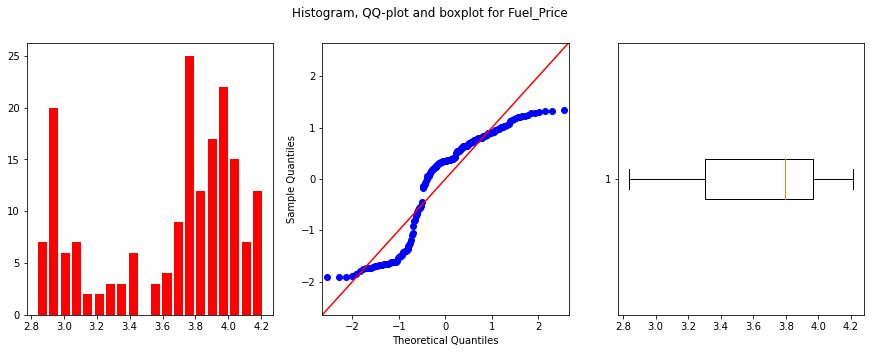

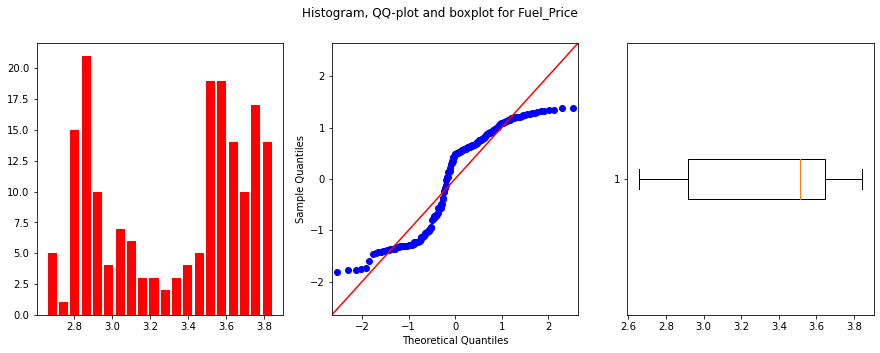

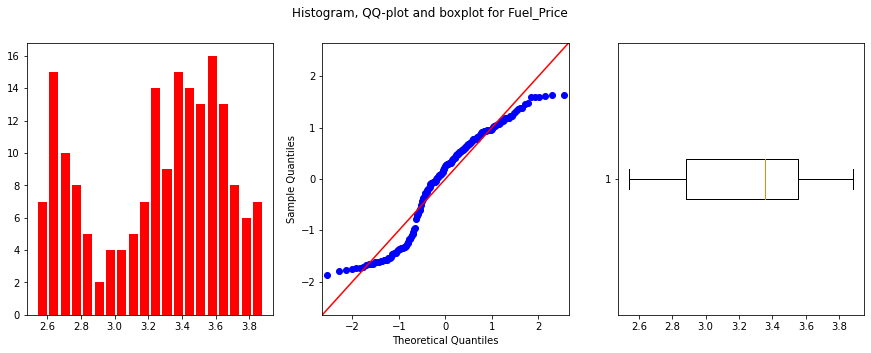

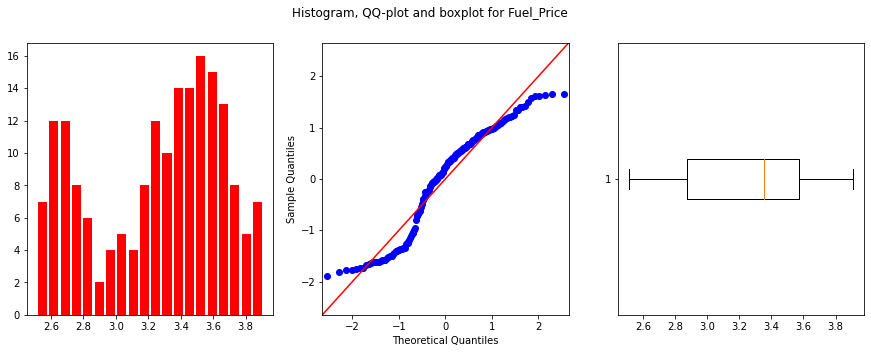

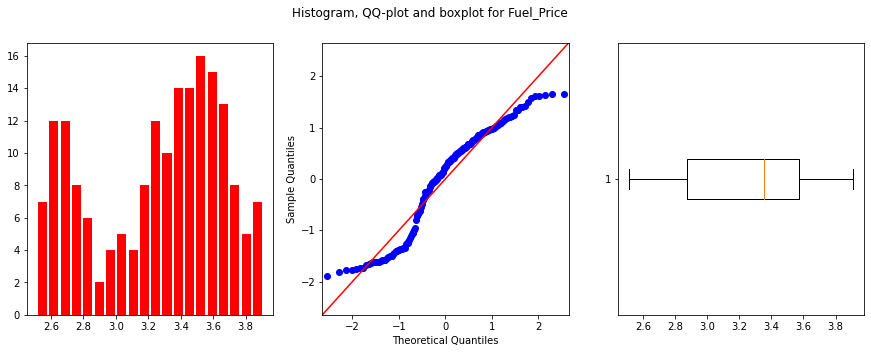

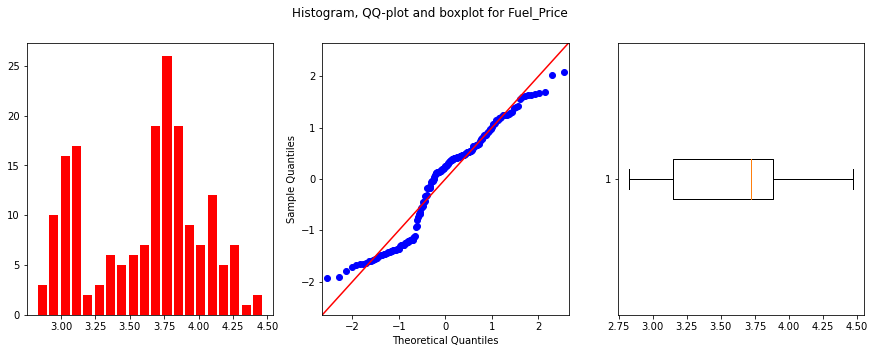

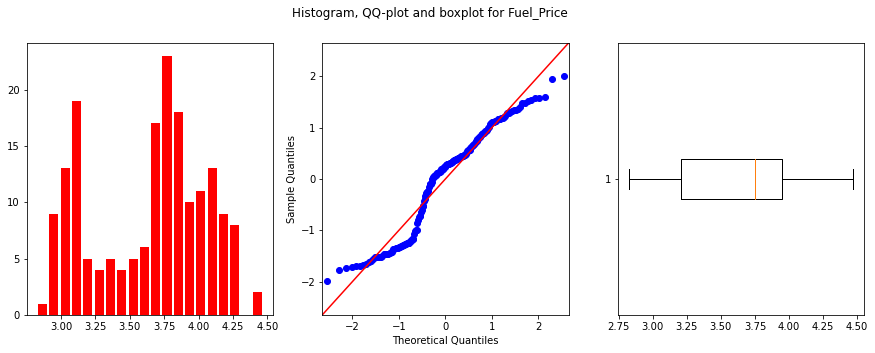

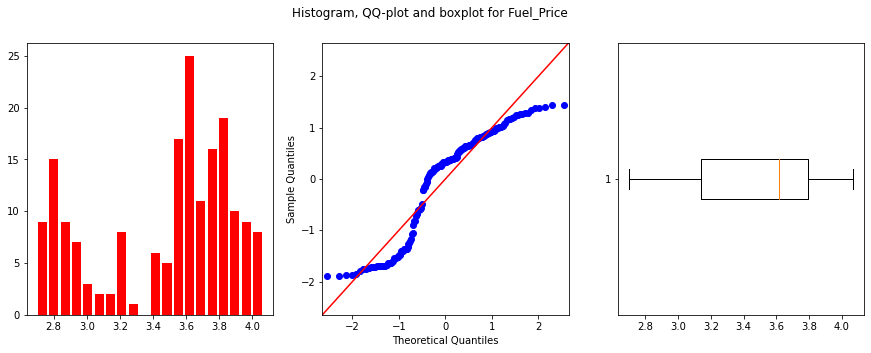

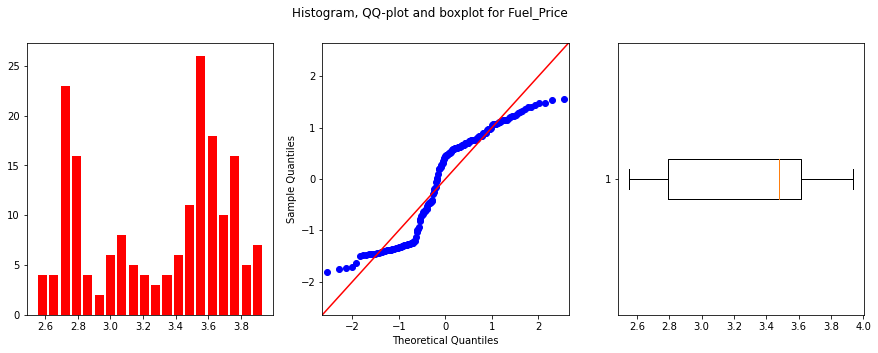

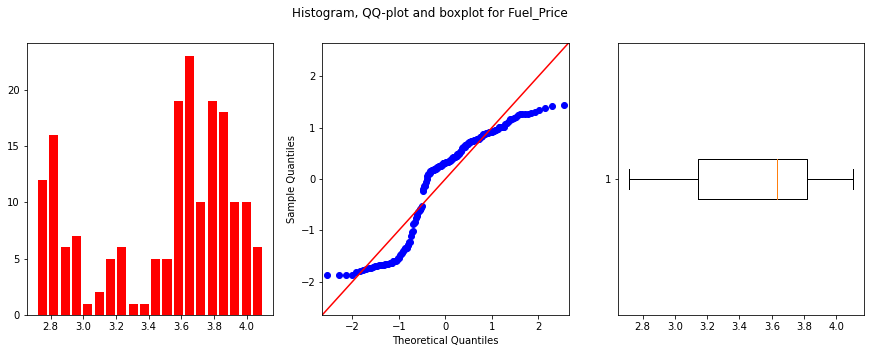

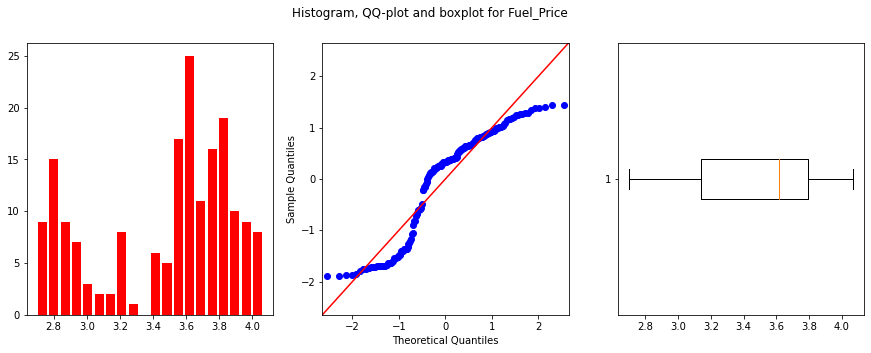

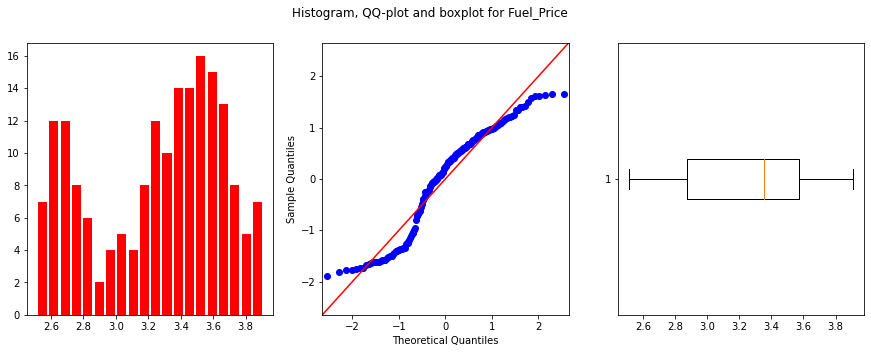

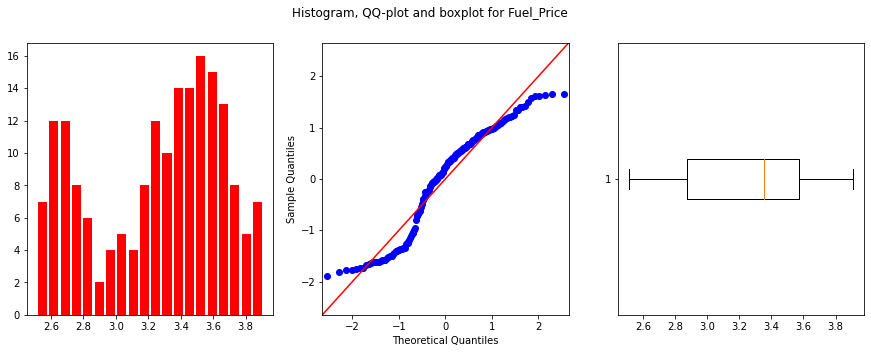

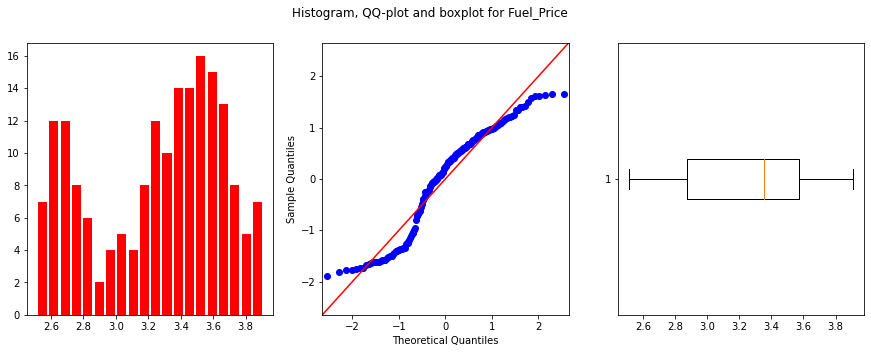

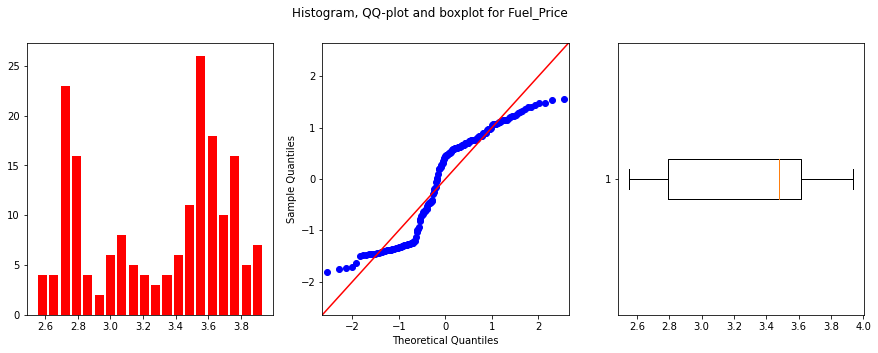

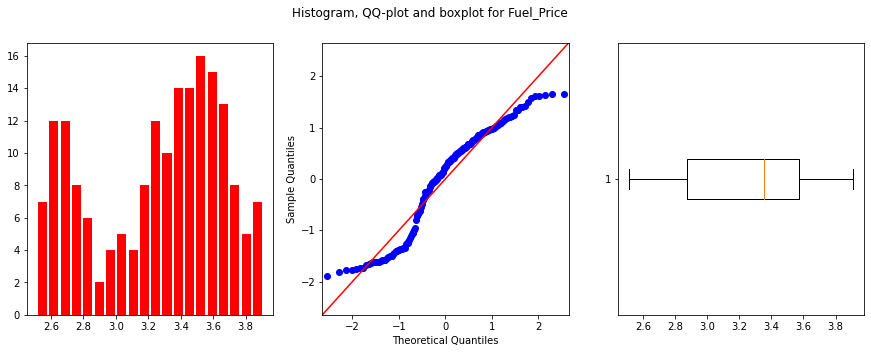

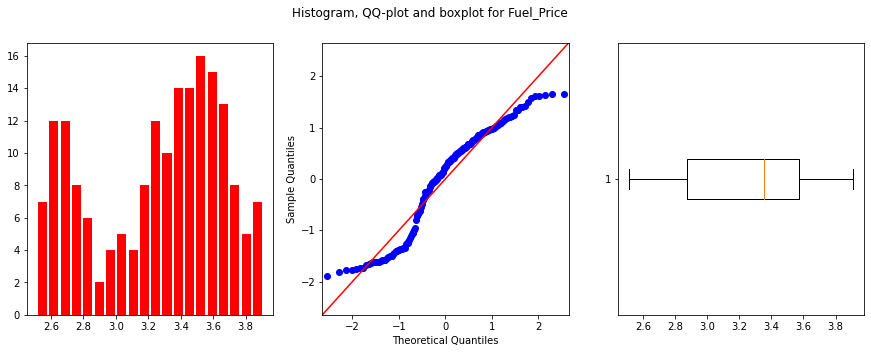

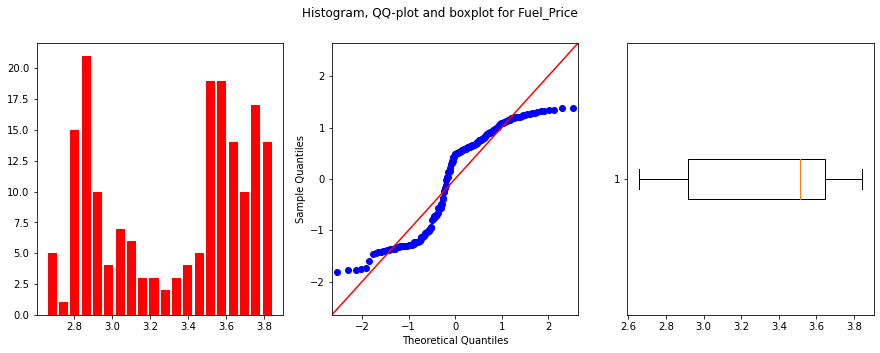

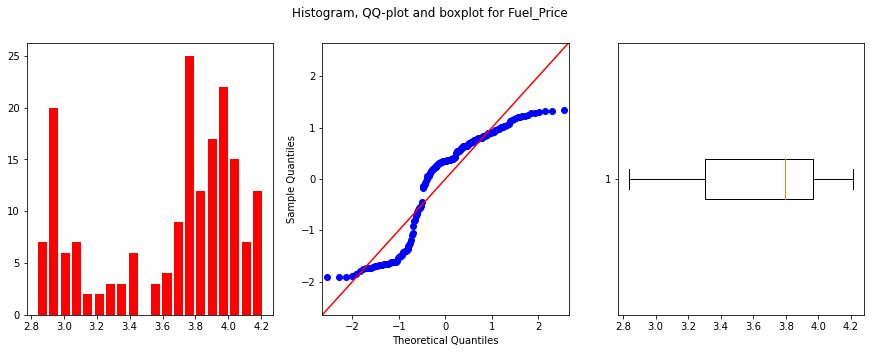

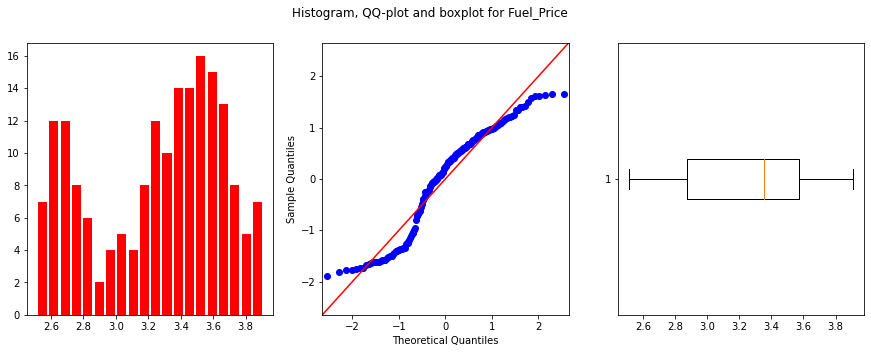

In [153]:
for city in city_index:
    Fuel_Price = AnalyzNumCol(data[data.City == city], 'Fuel_Price')
    Fuel_Price.show_plots()

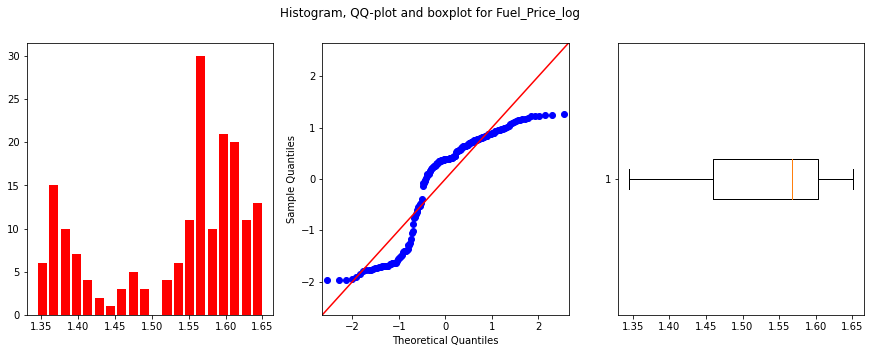

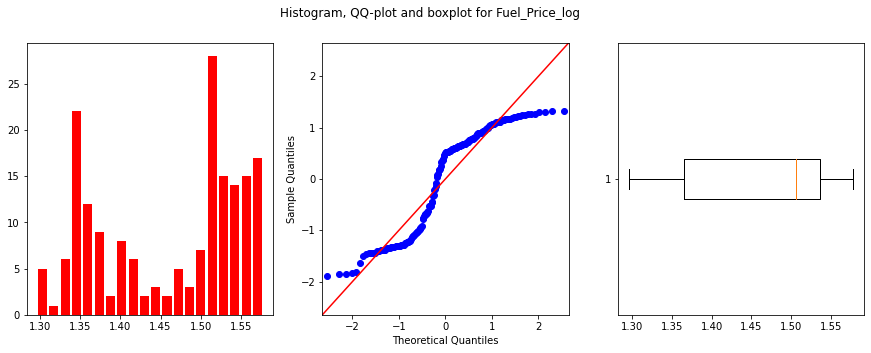

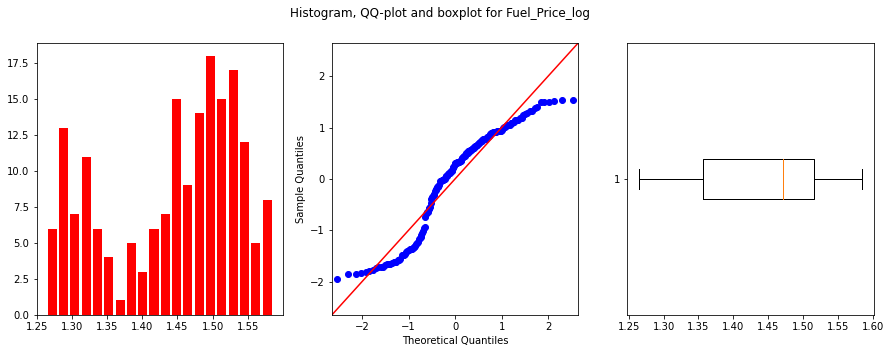

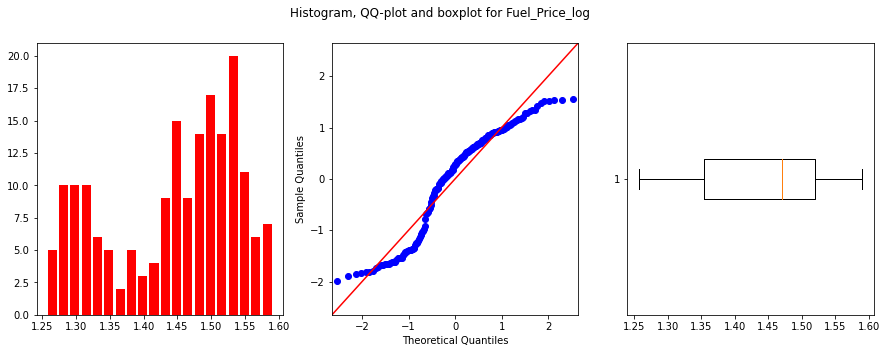

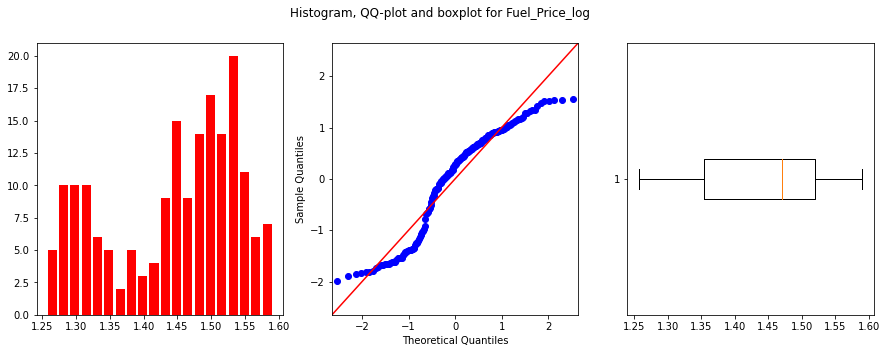

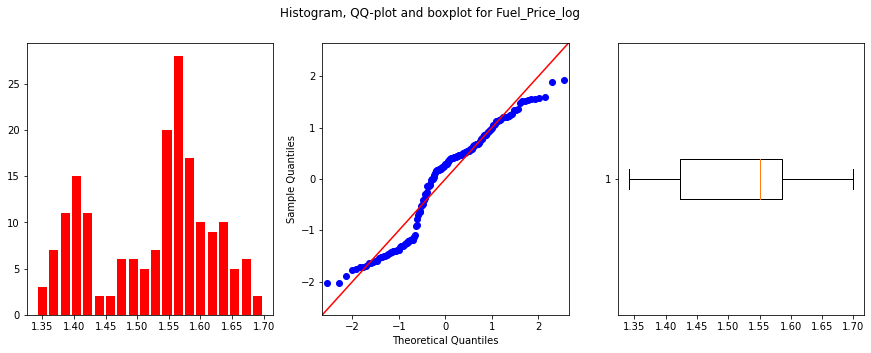

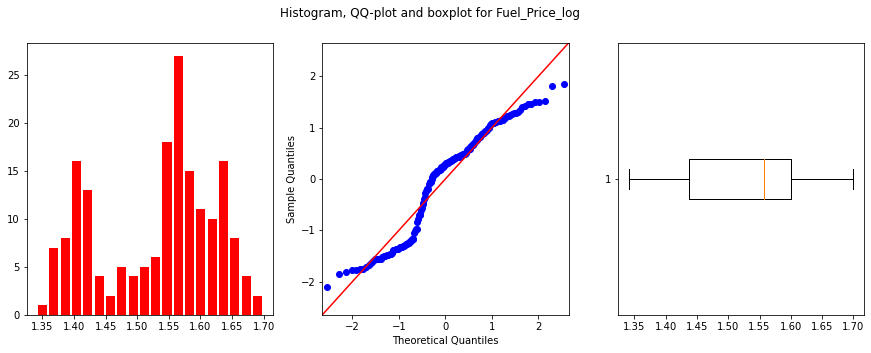

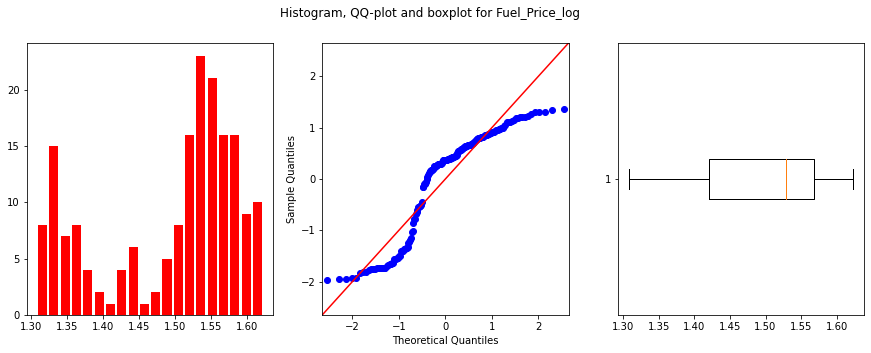

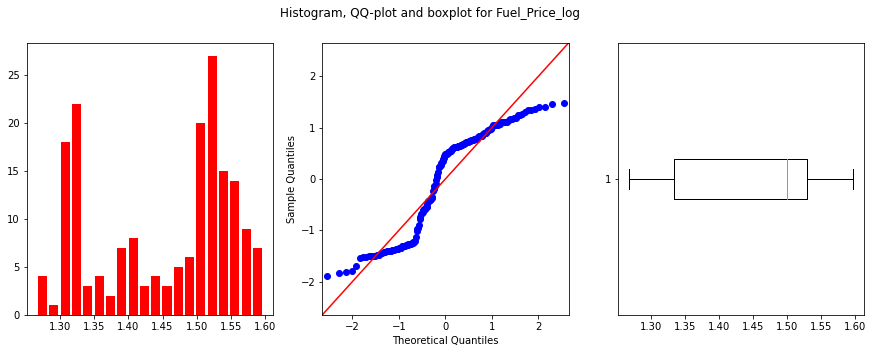

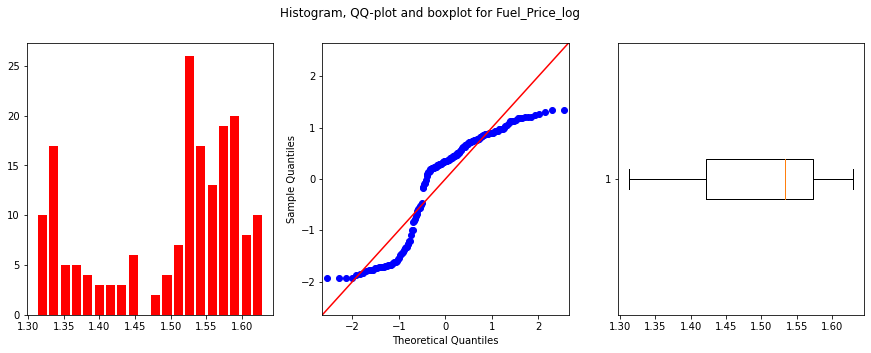

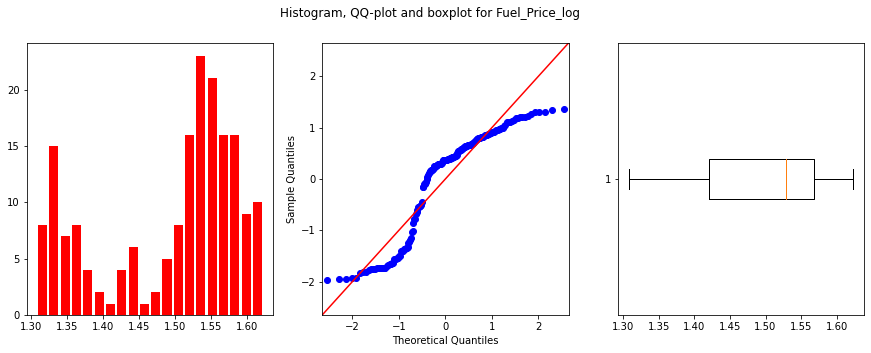

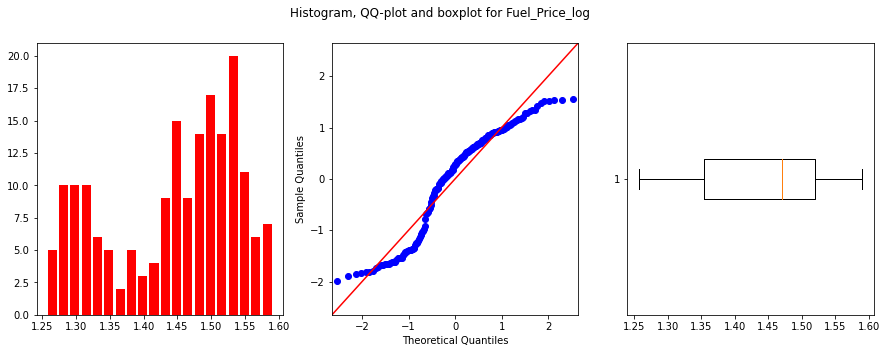

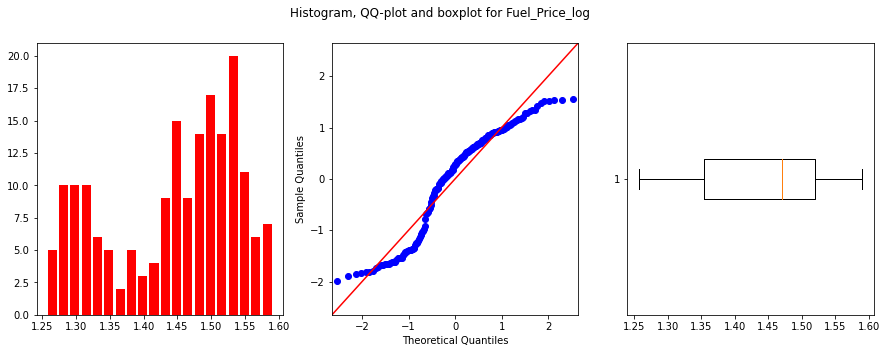

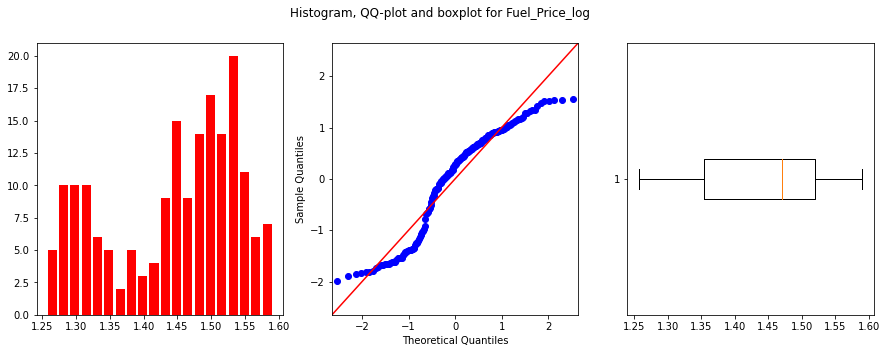

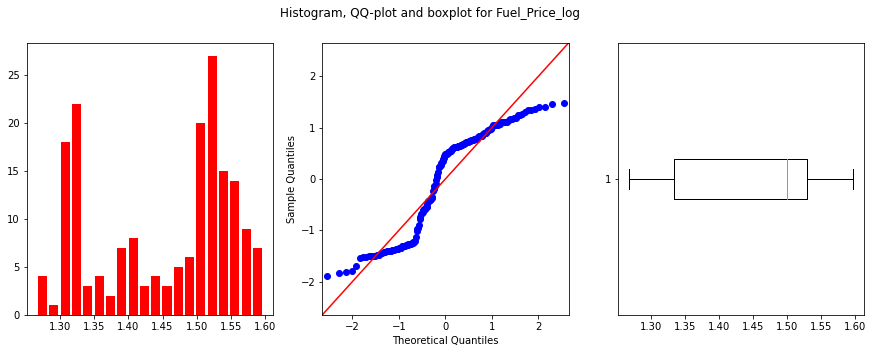

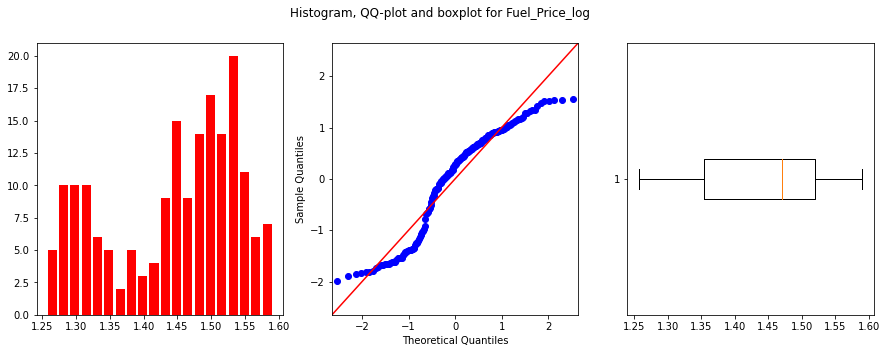

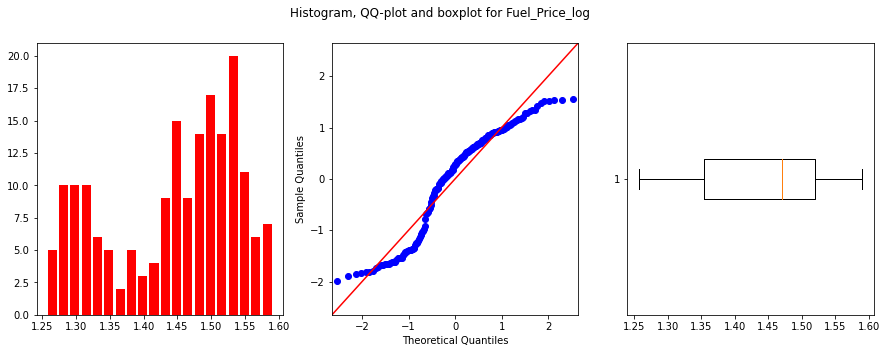

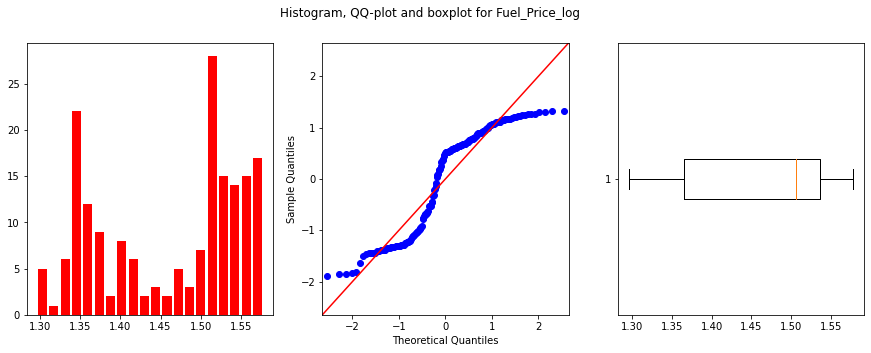

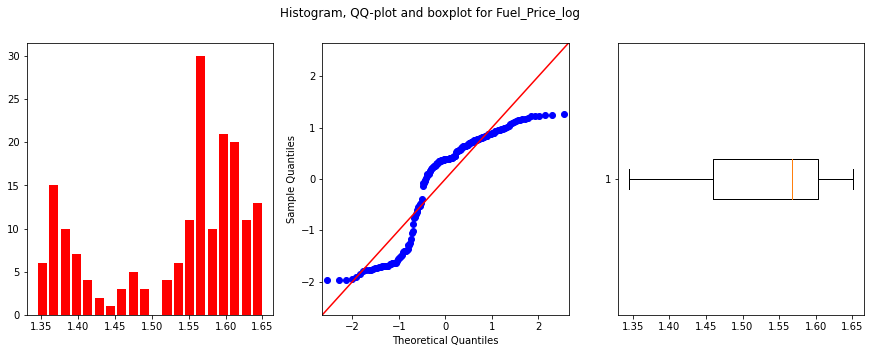

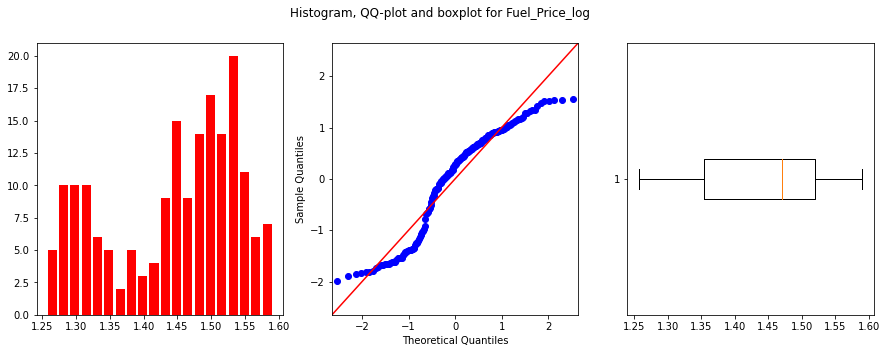

In [154]:
for city in city_index:
    Fuel_Price = AnalyzNumCol(data[data.City == city], 'Fuel_Price')
    Fuel_Price.show_plots(log = True)

Вывод
------
Данные без выбросов, логорифмирование не улучшает данные

Unemployment

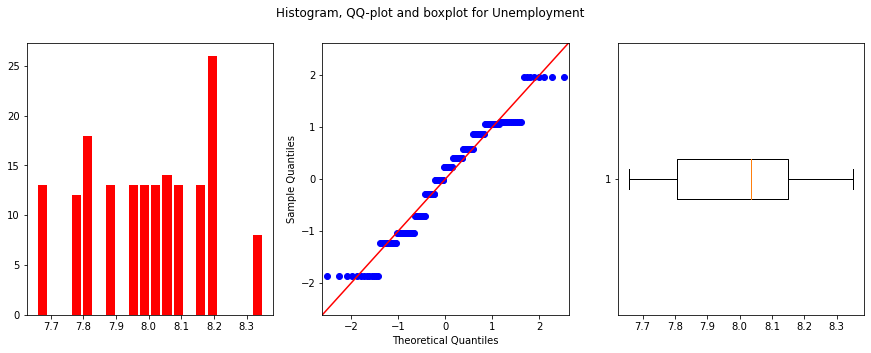

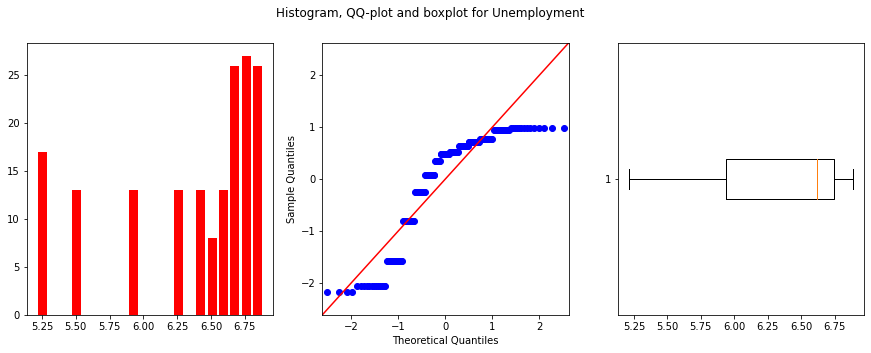

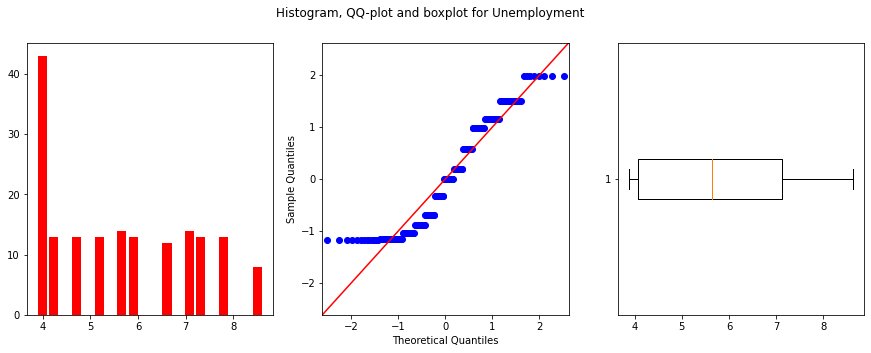

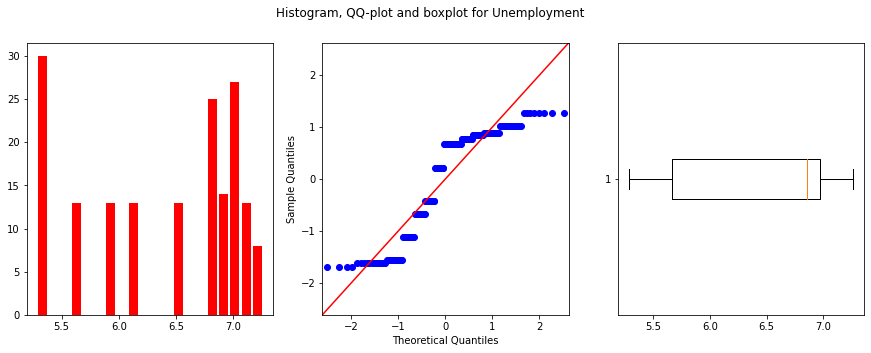

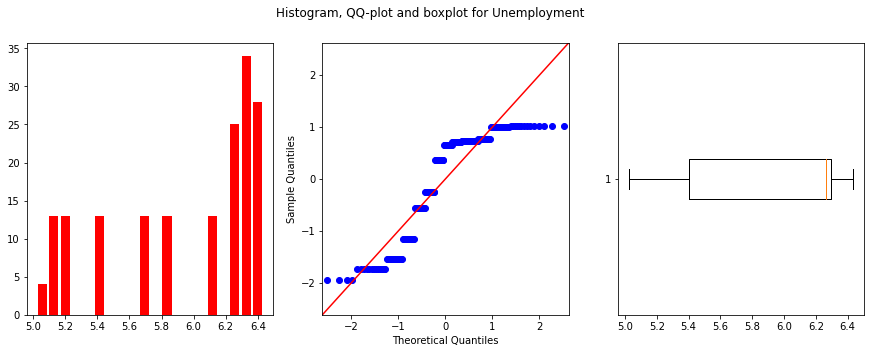

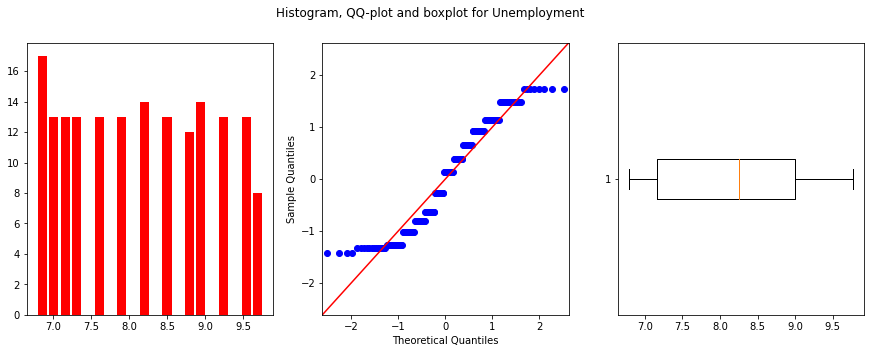

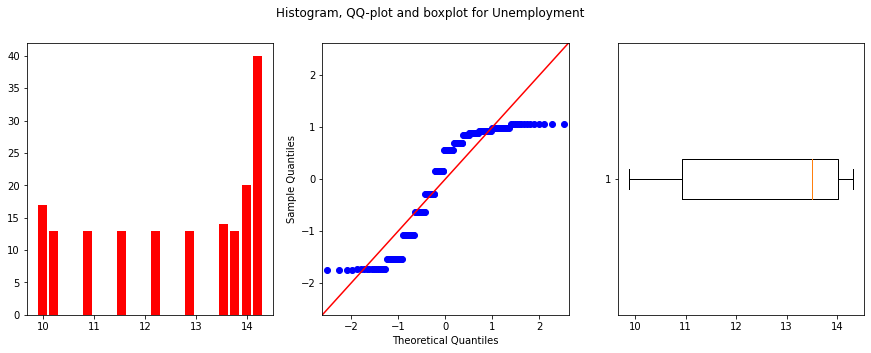

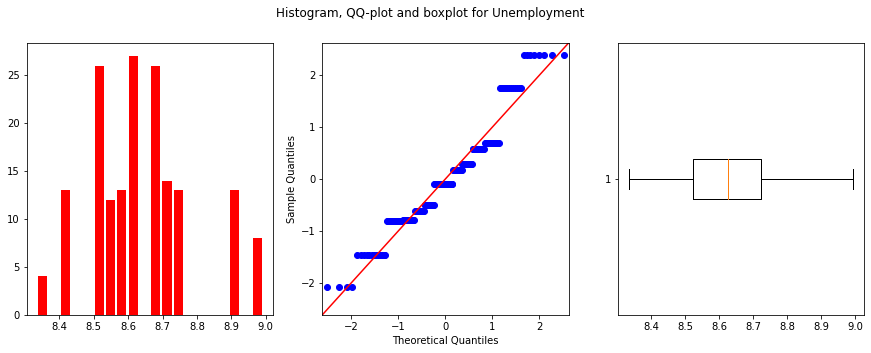

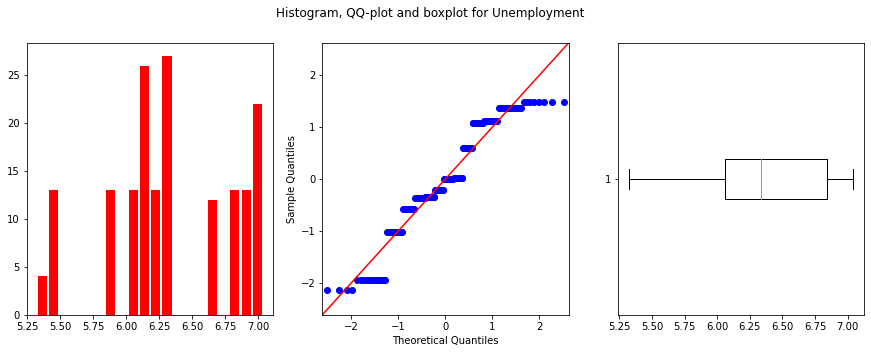

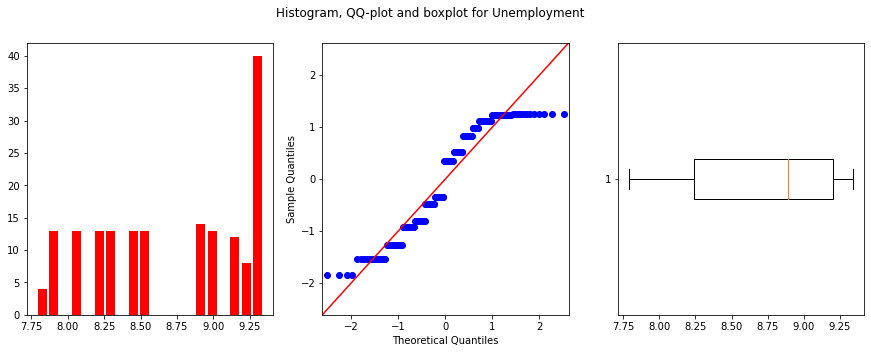

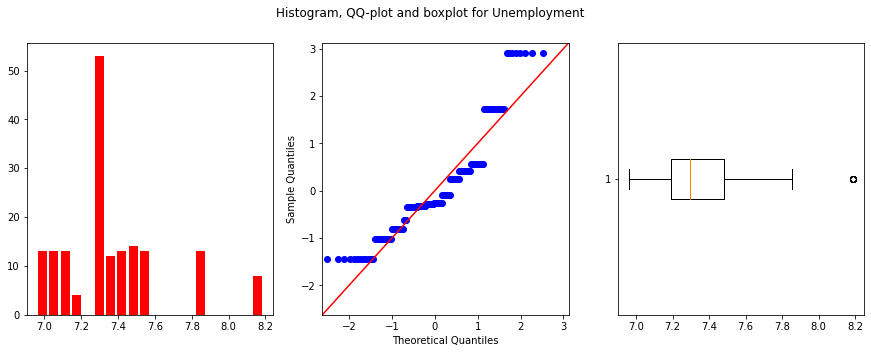

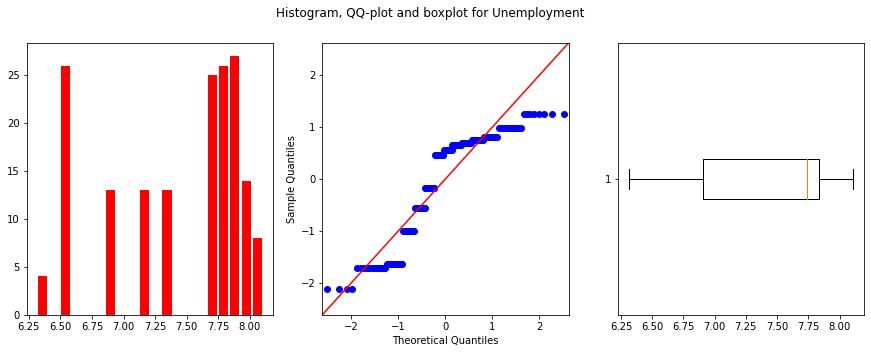

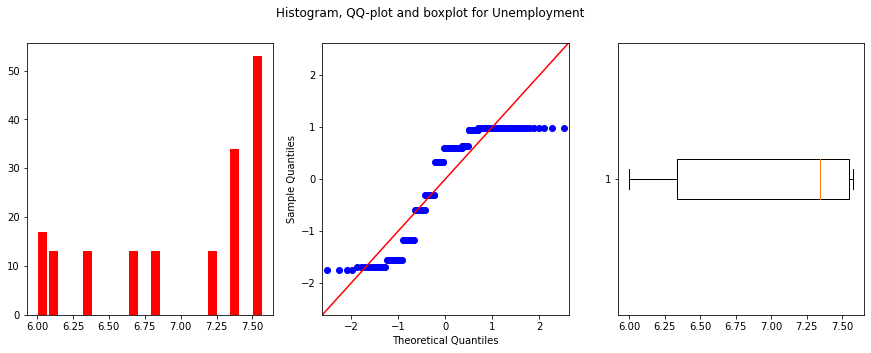

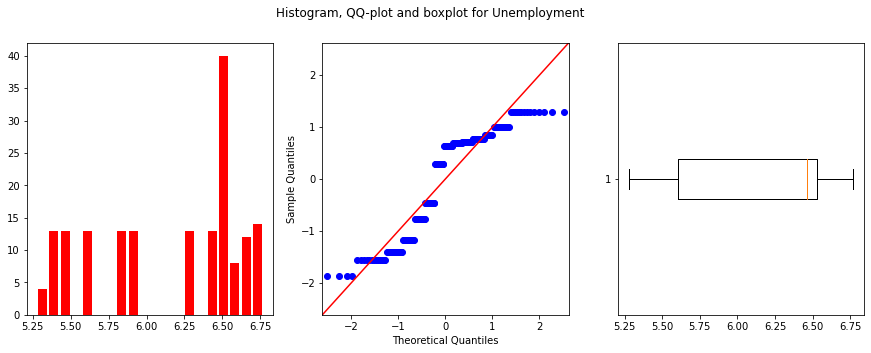

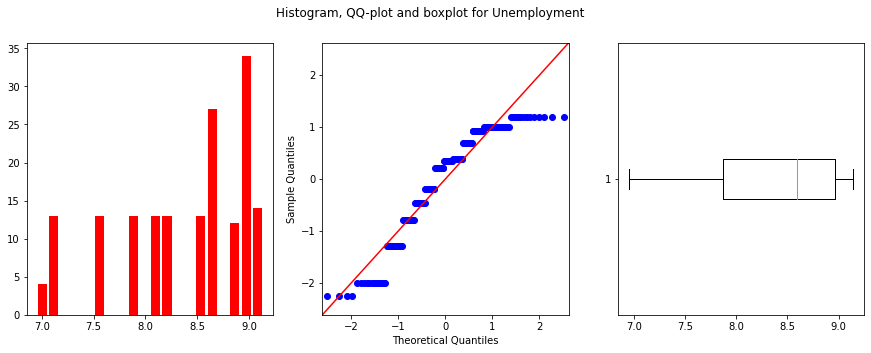

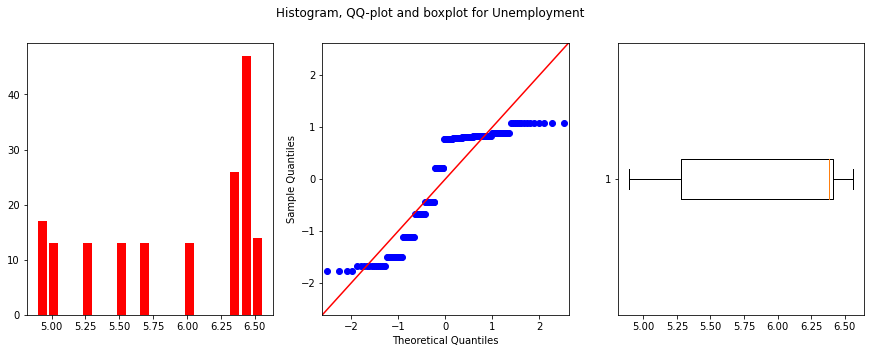

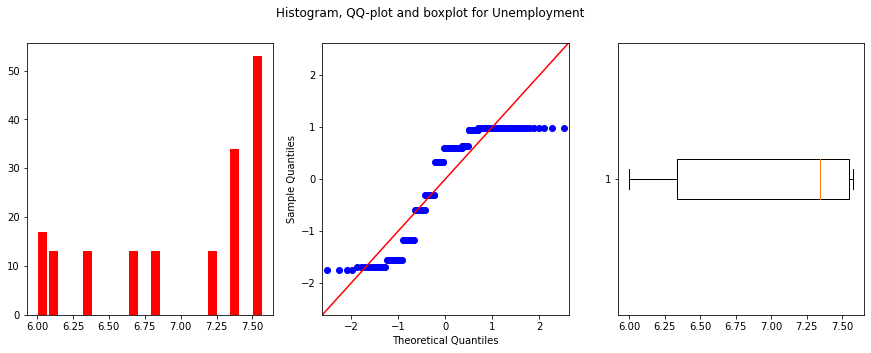

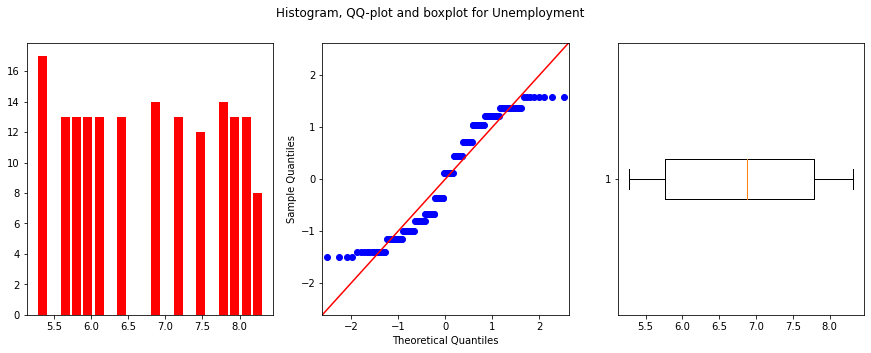

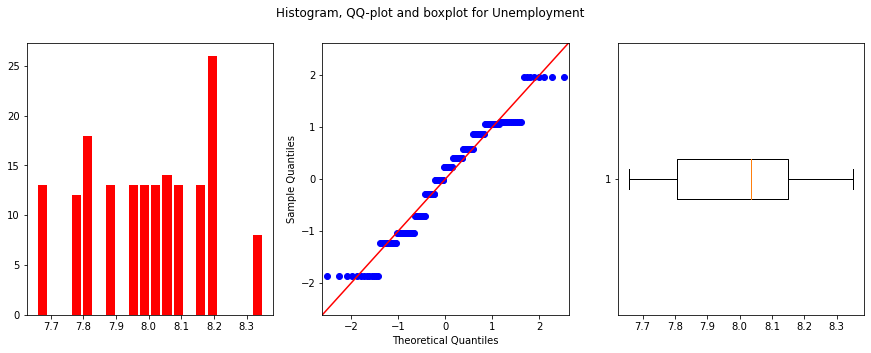

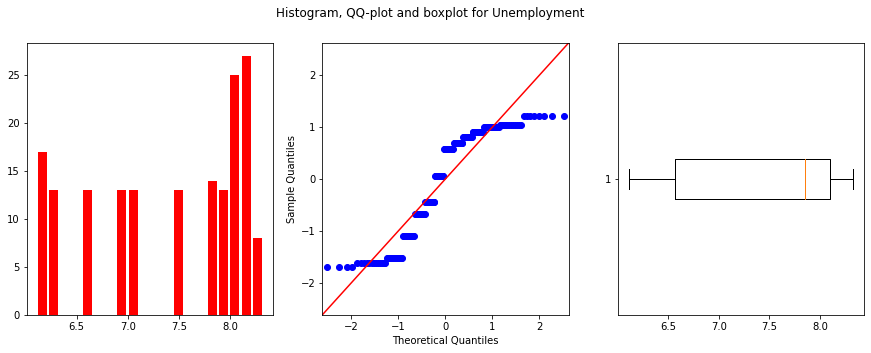

In [155]:
for city in city_index:
    Unemployment = AnalyzNumCol(data[data.City == city], 'Unemployment')
    Unemployment.show_plots()

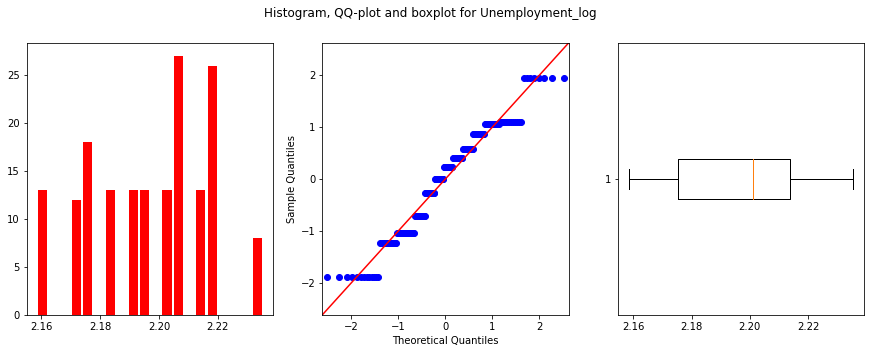

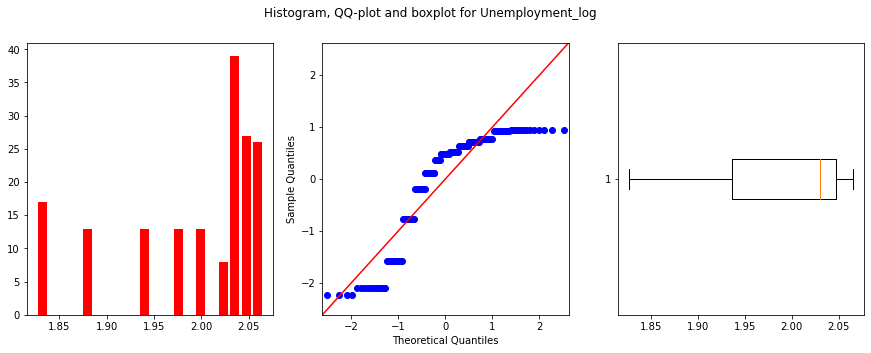

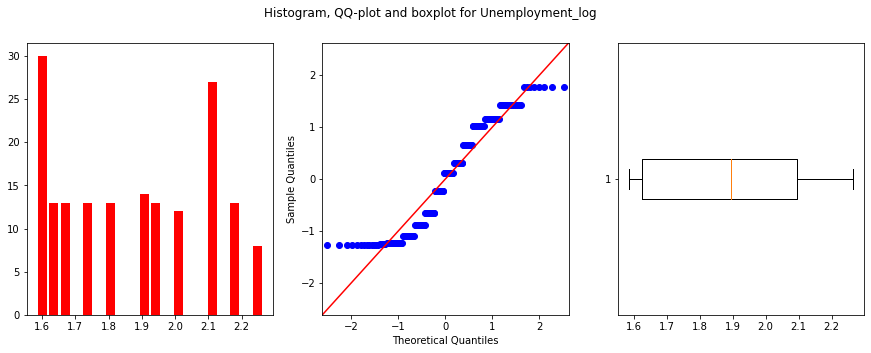

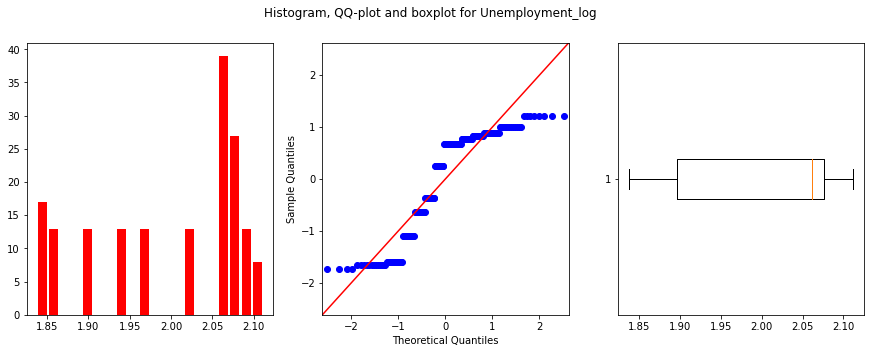

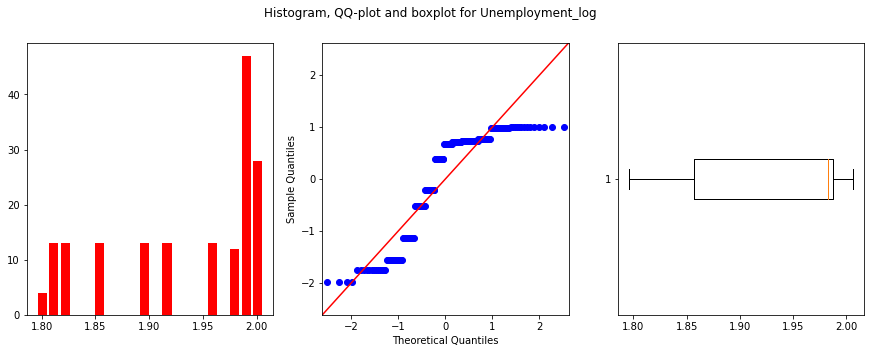

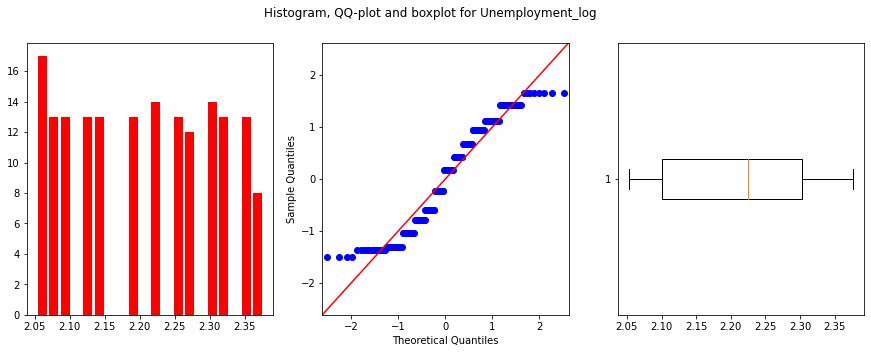

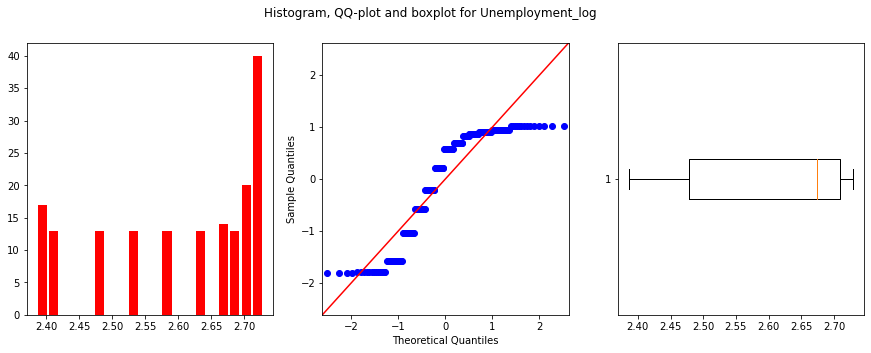

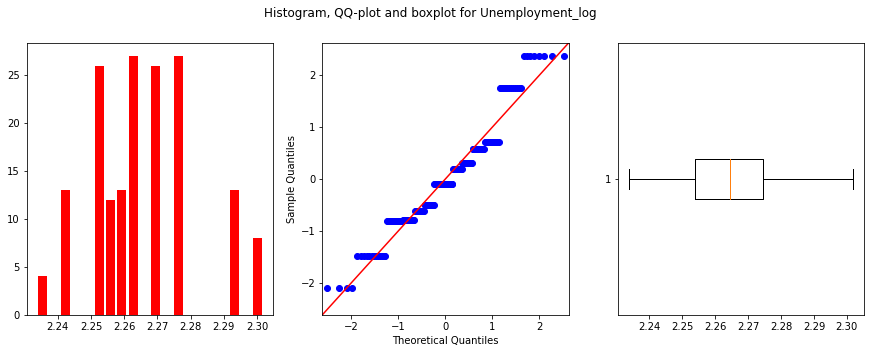

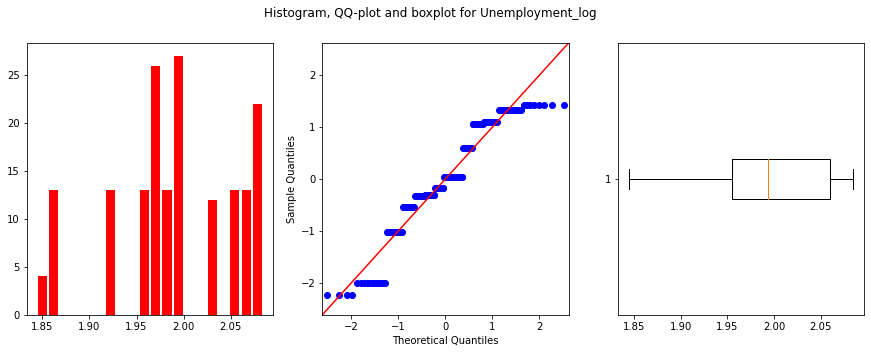

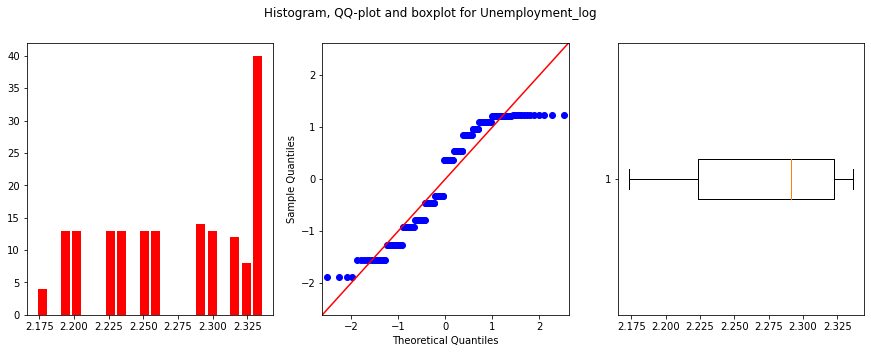

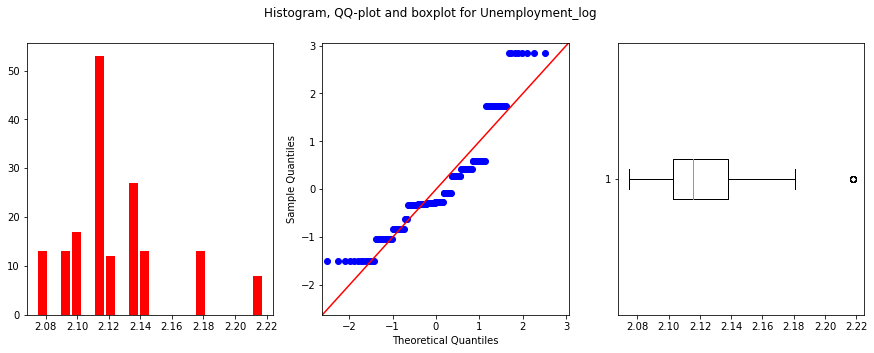

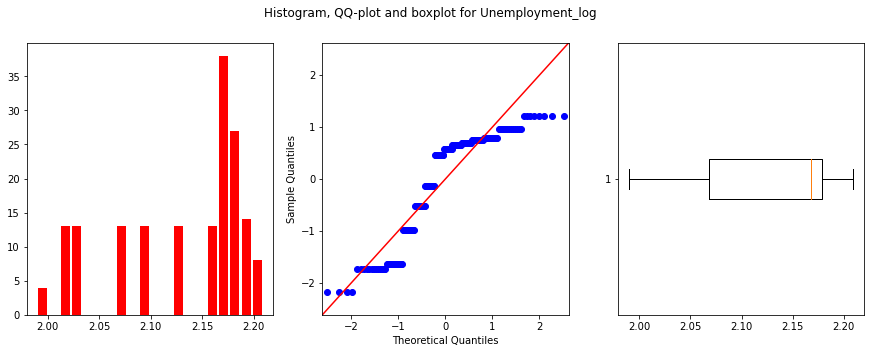

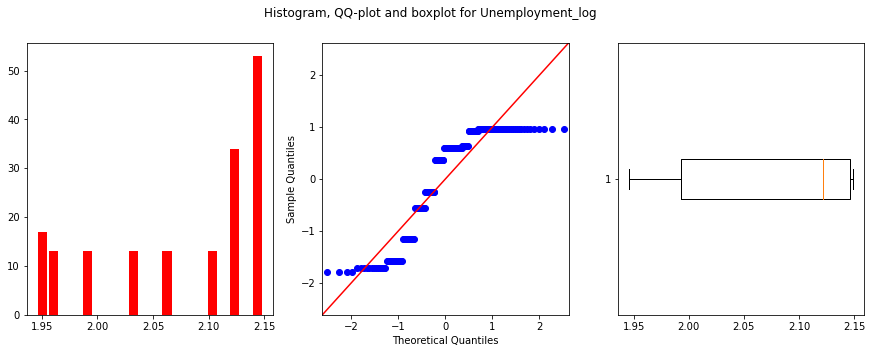

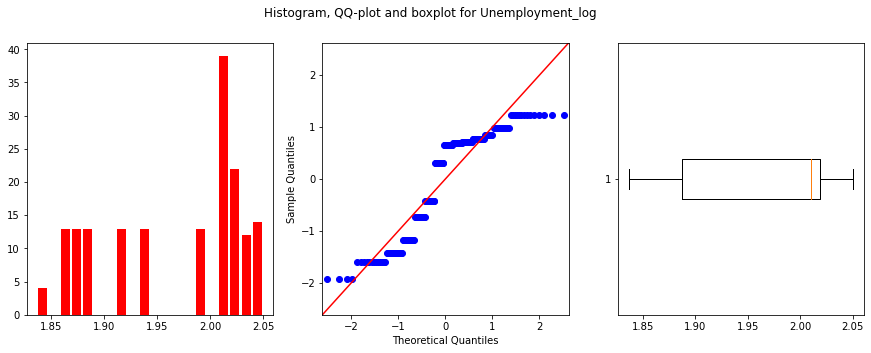

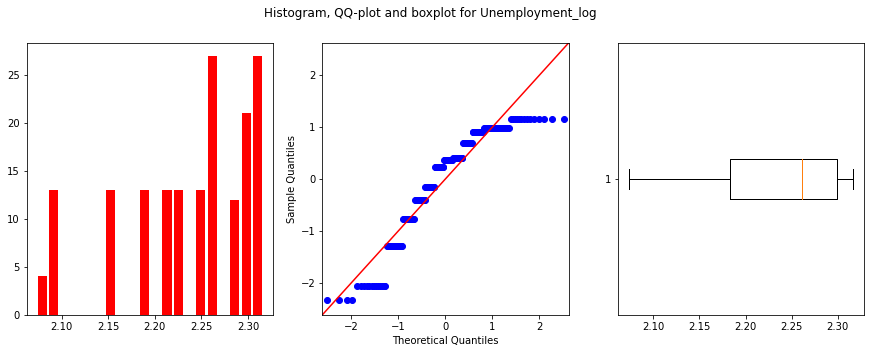

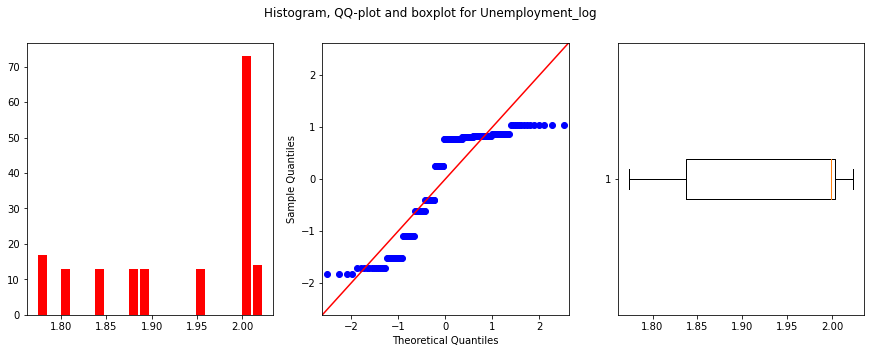

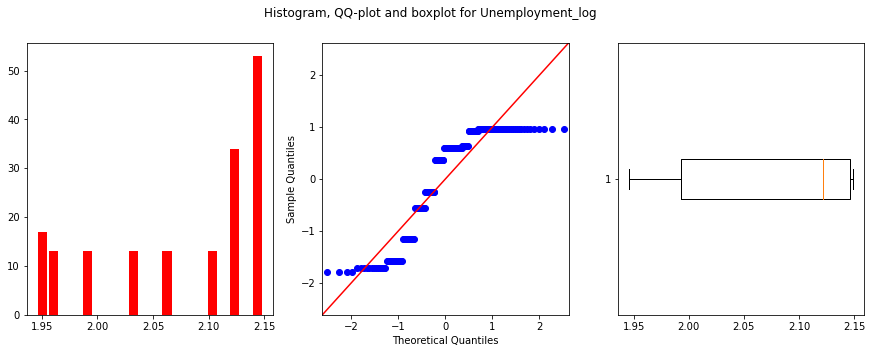

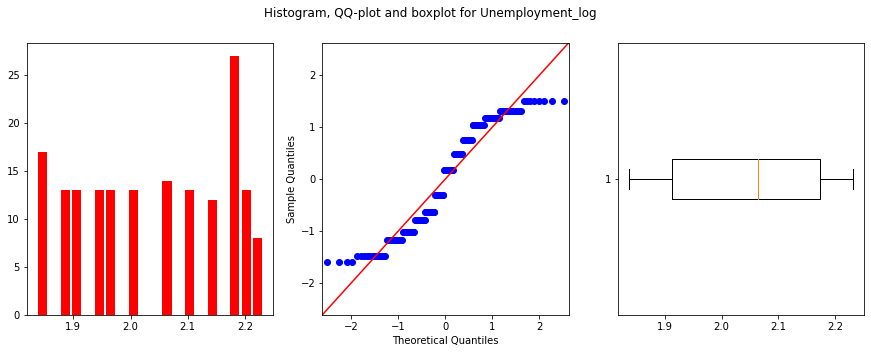

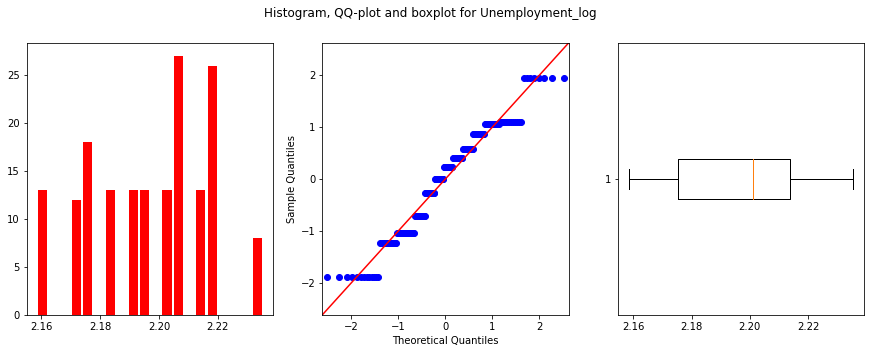

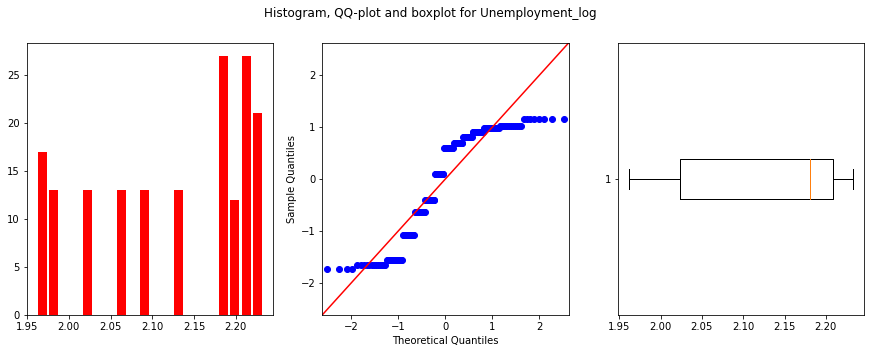

In [156]:
for city in city_index:
    Unemployment = AnalyzNumCol(data[data.City == city], 'Unemployment')
    Unemployment.show_plots(log = True)

Вывод
------
Данные без выбросов, логорифмирование не улучшает данные

inf

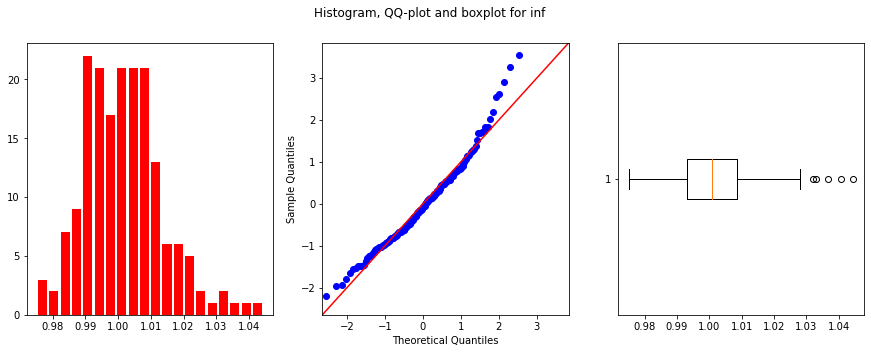

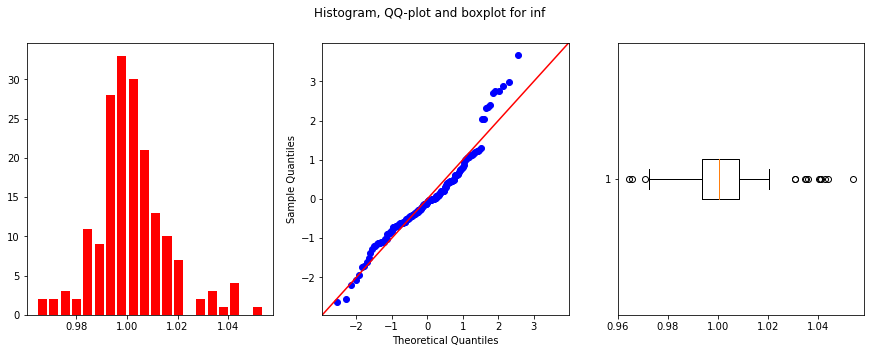

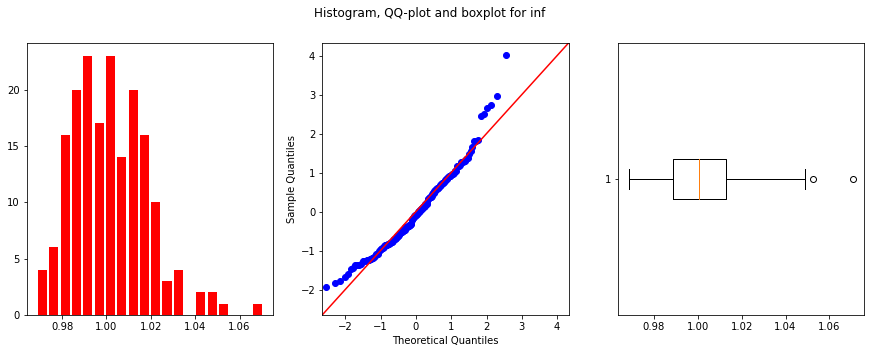

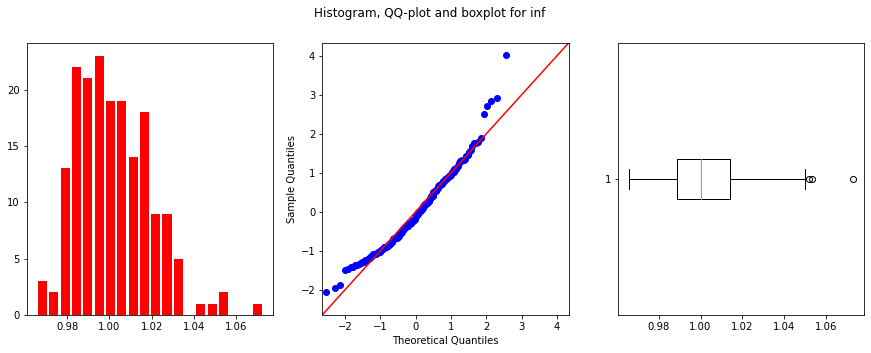

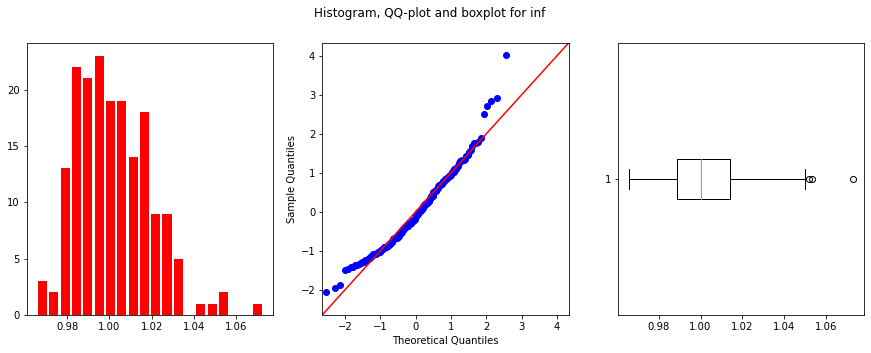

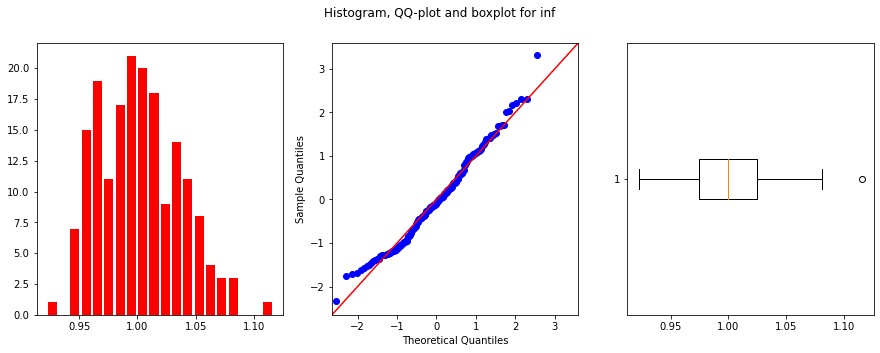

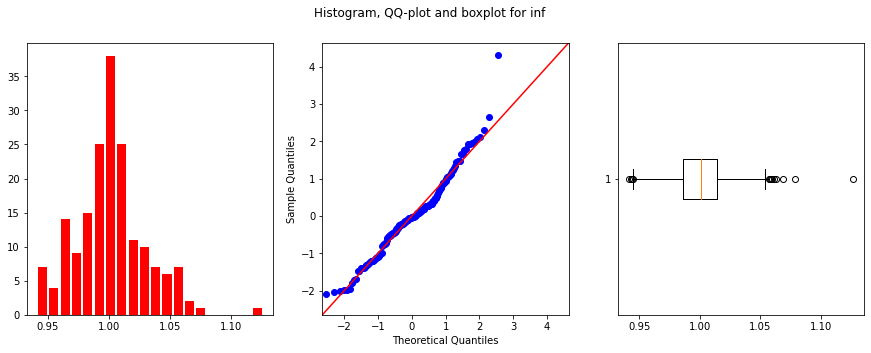

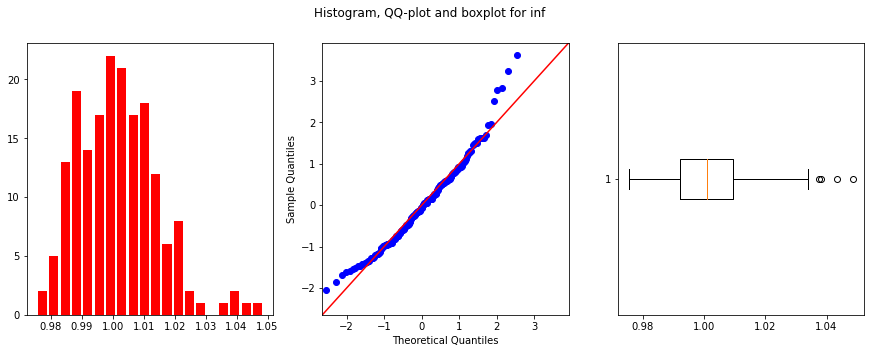

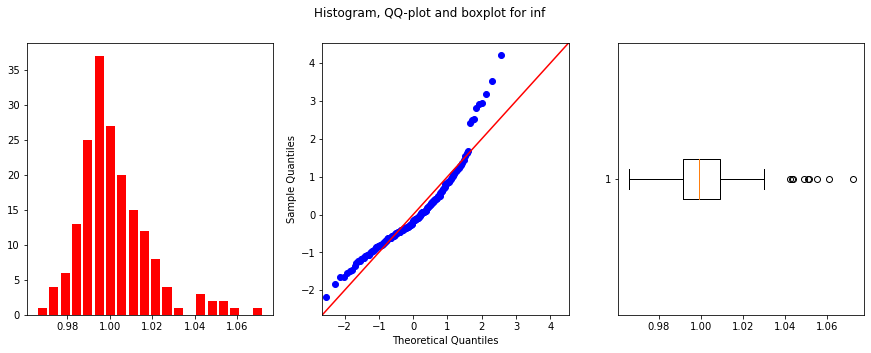

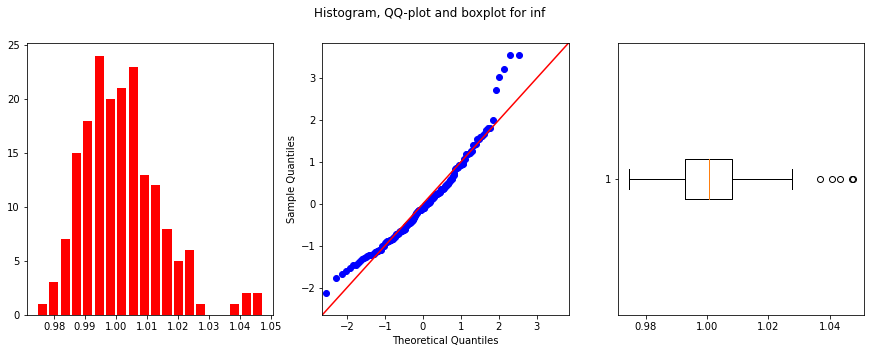

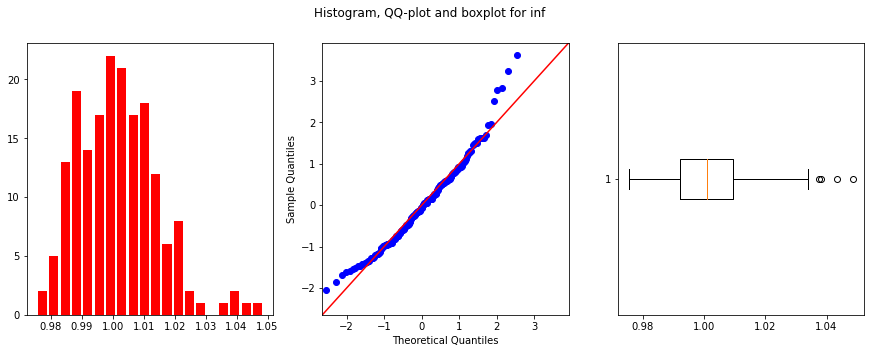

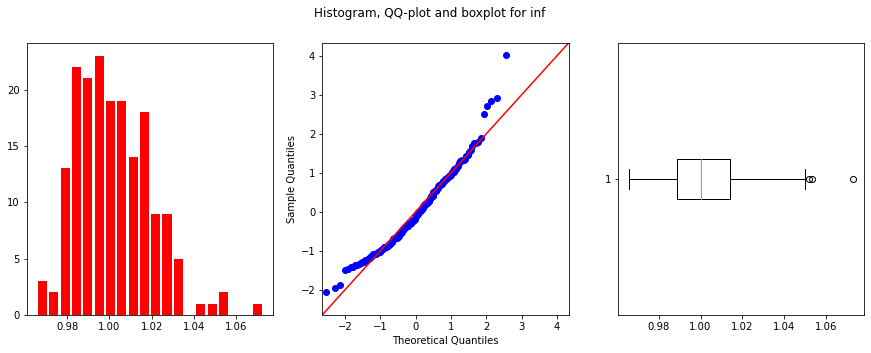

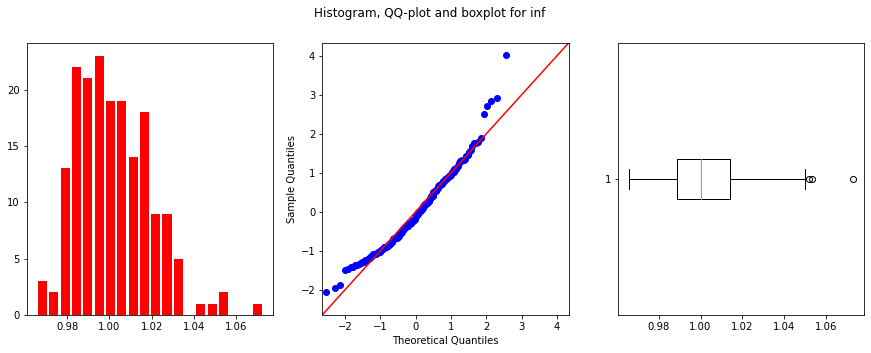

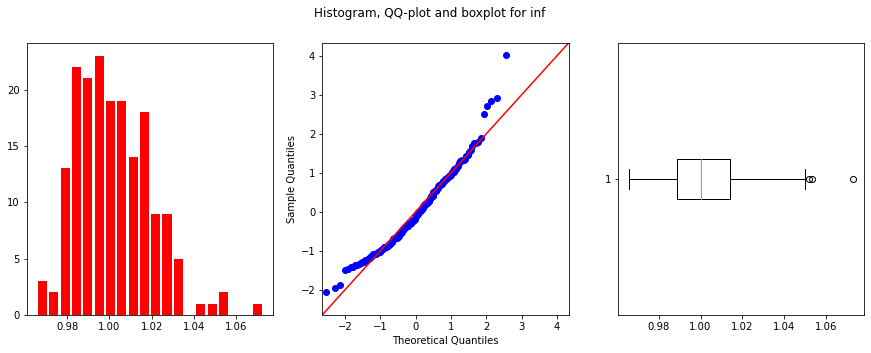

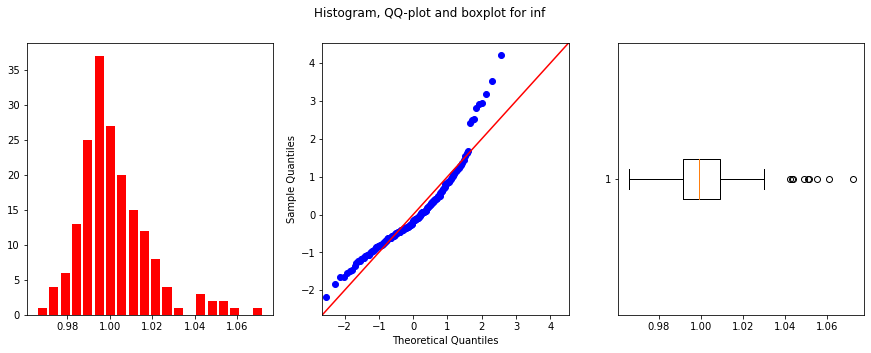

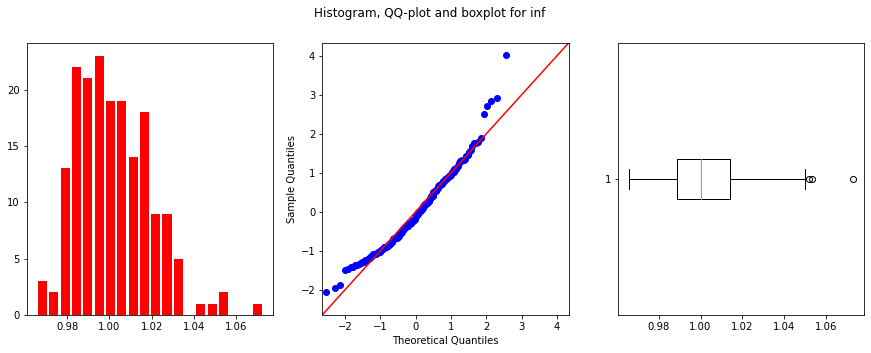

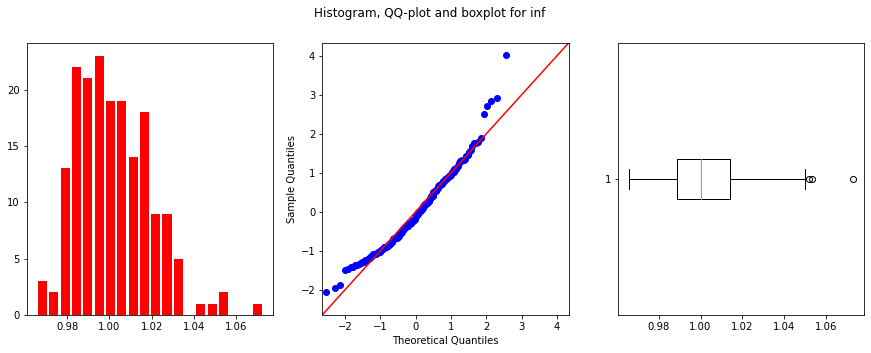

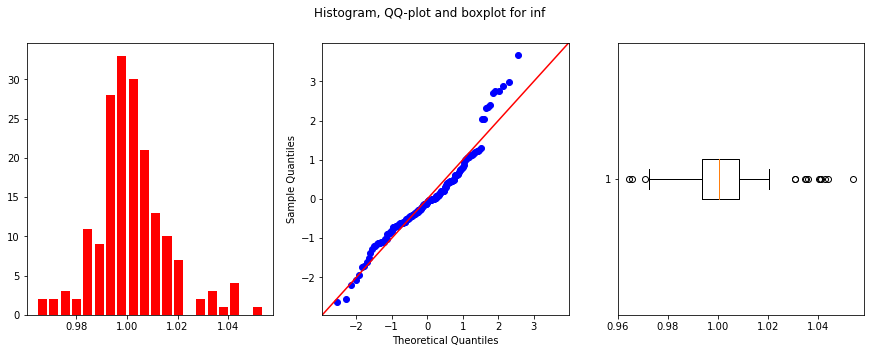

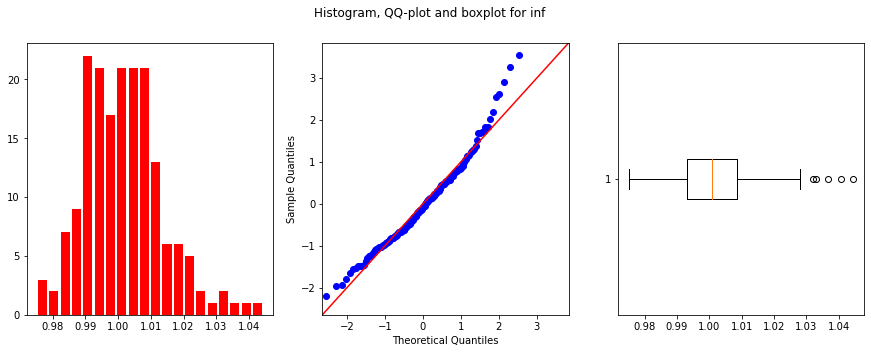

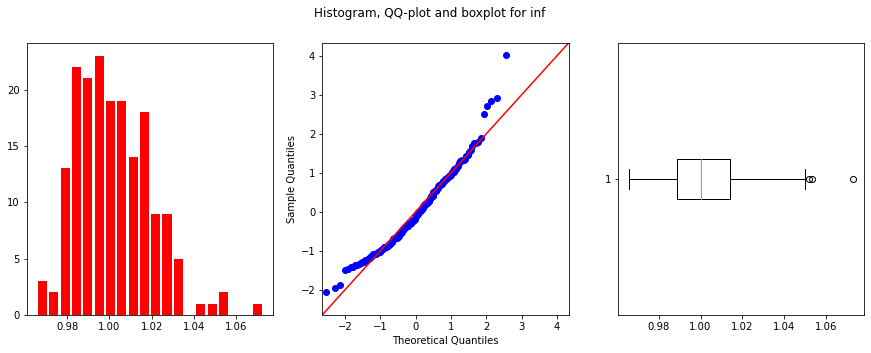

In [157]:
for city in city_index:
    inf = AnalyzNumCol(data[data.City == city], 'inf')
    inf.show_plots()

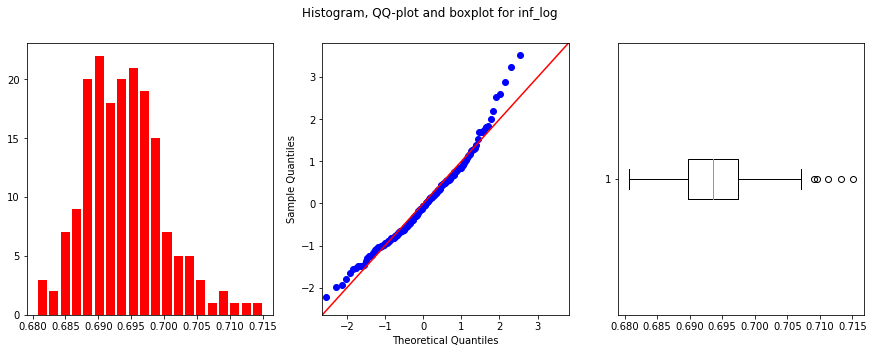

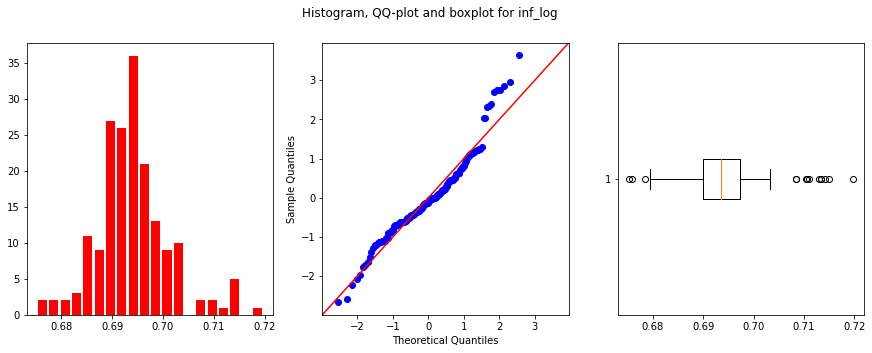

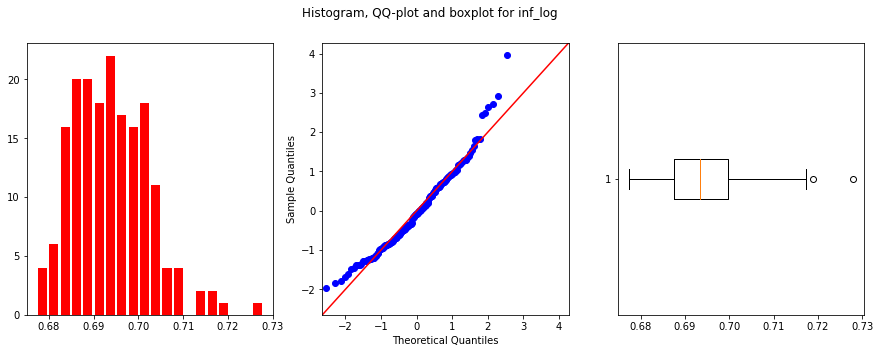

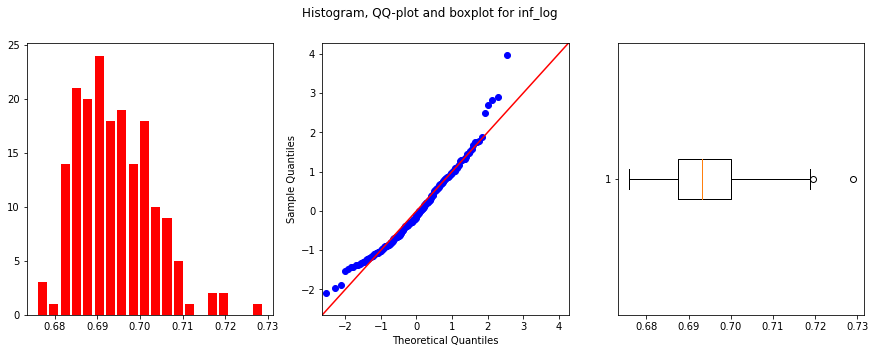

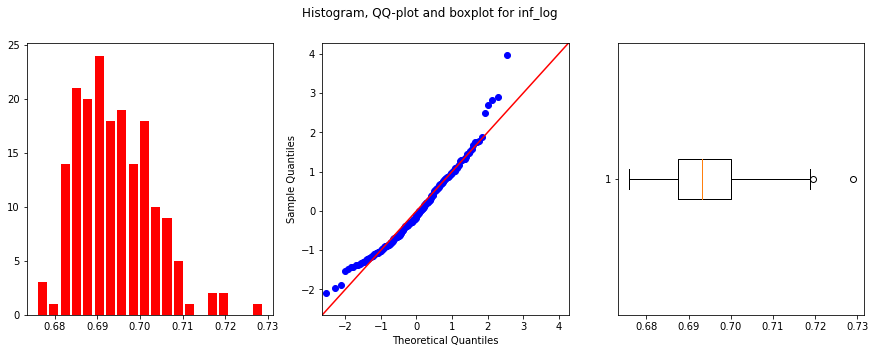

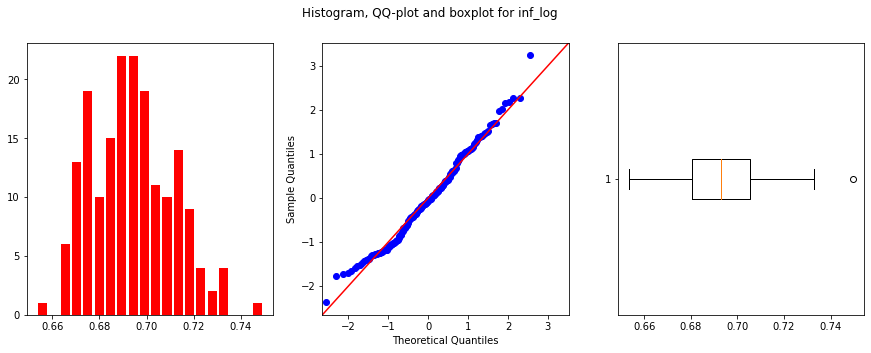

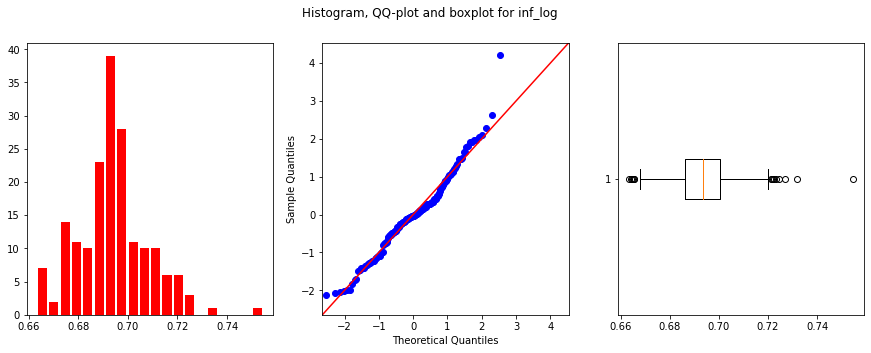

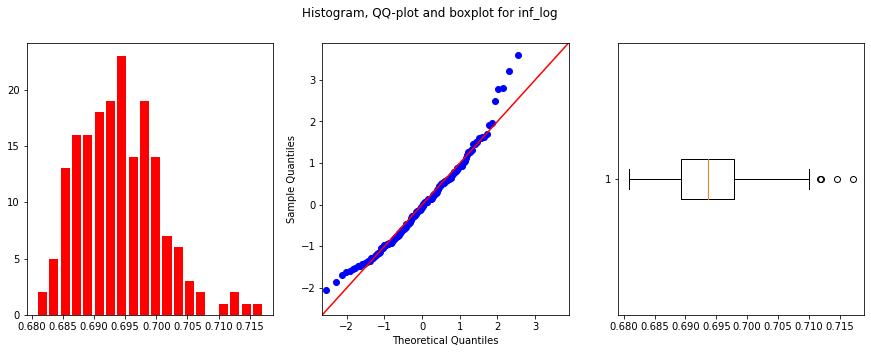

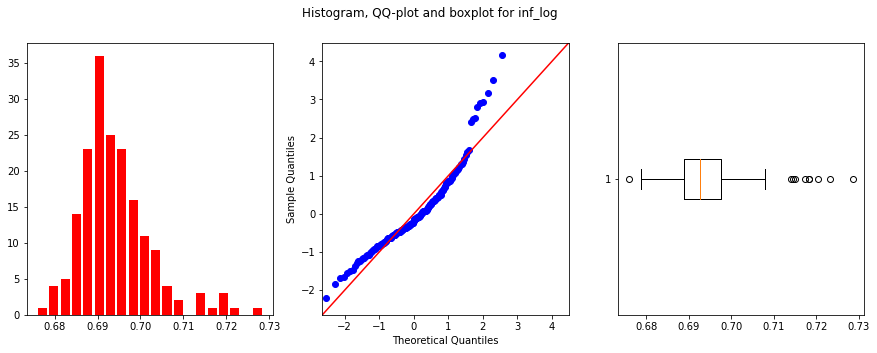

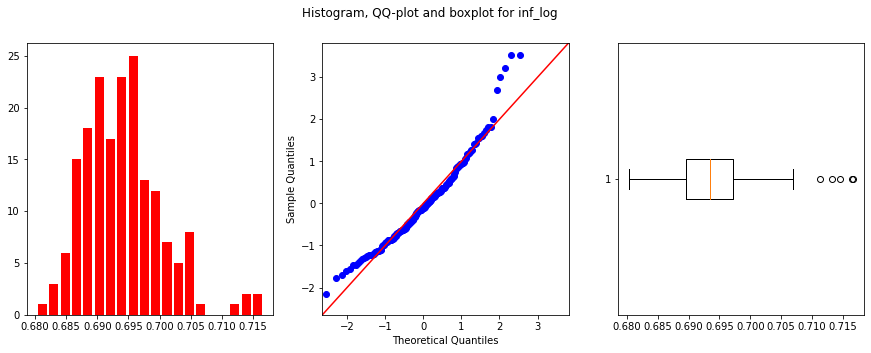

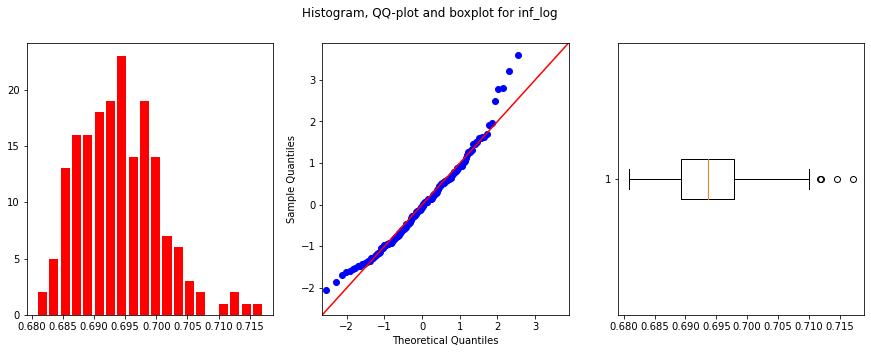

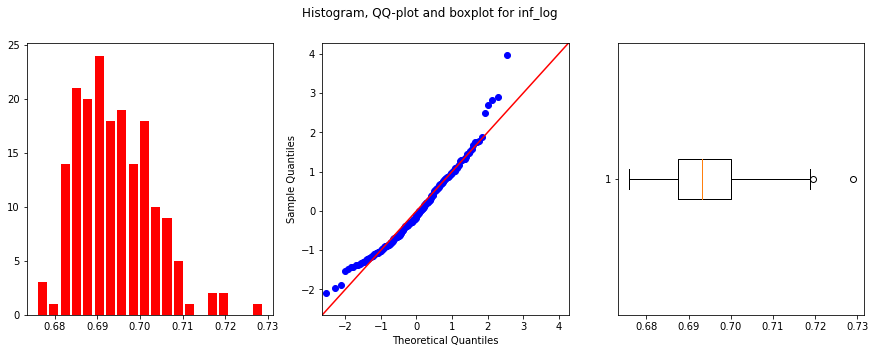

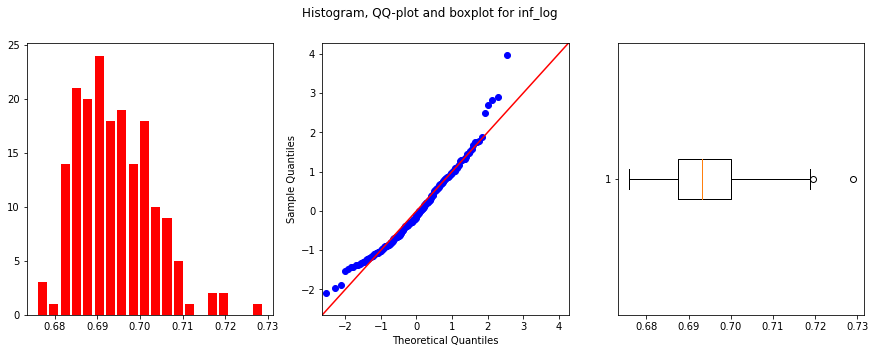

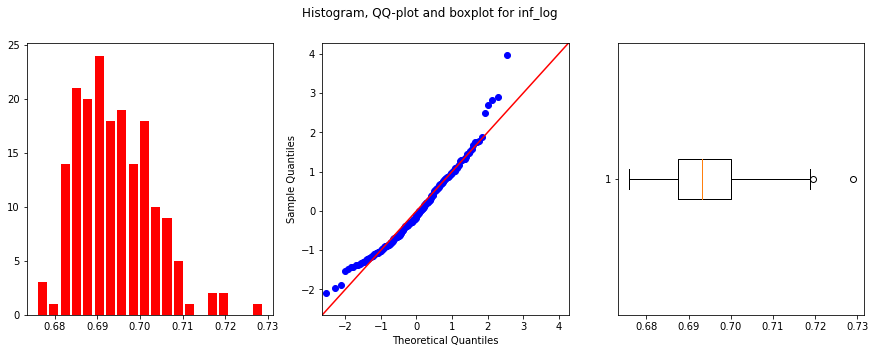

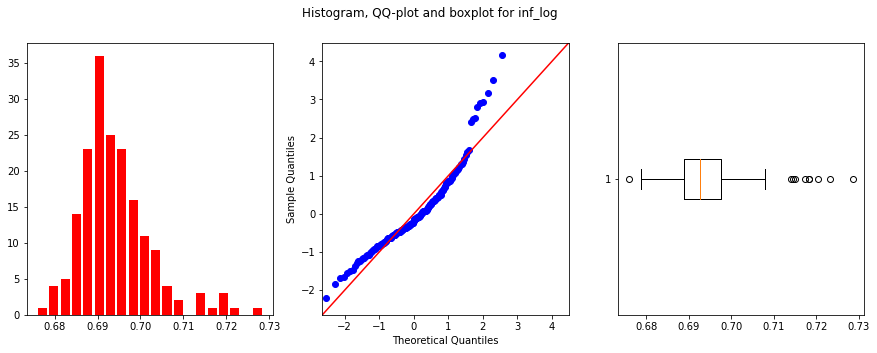

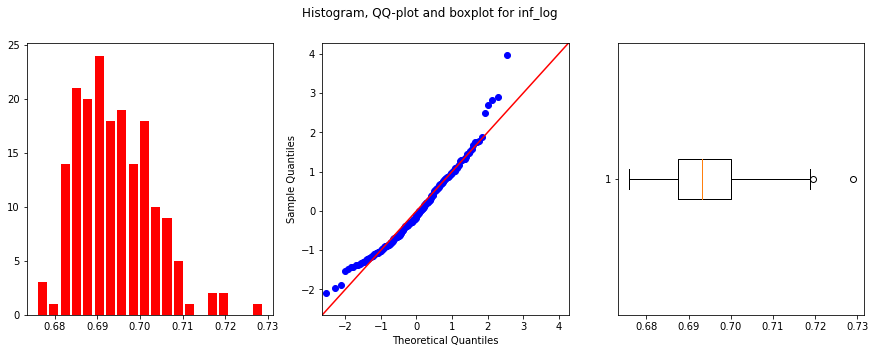

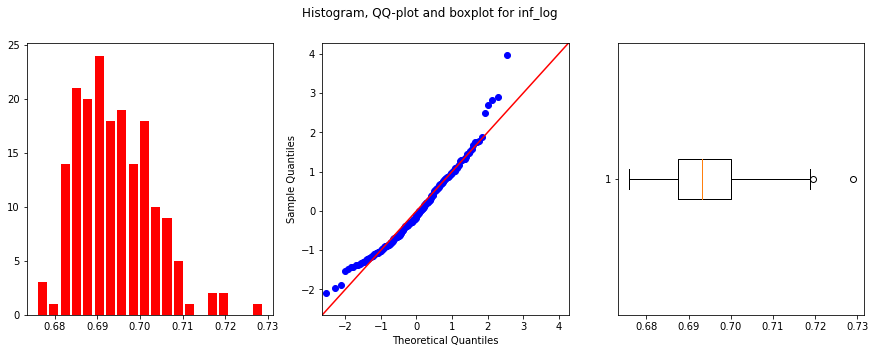

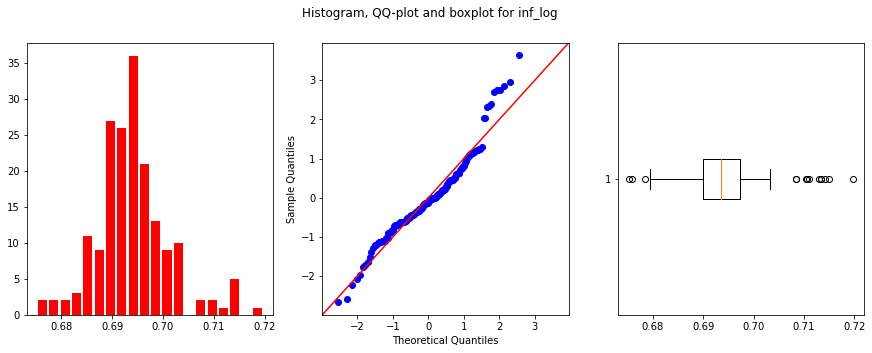

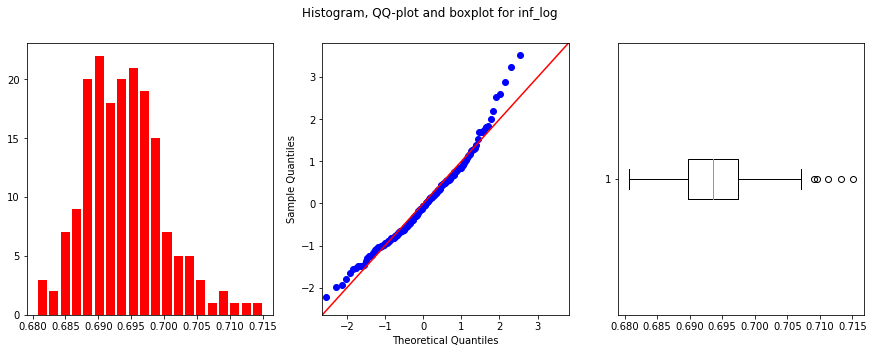

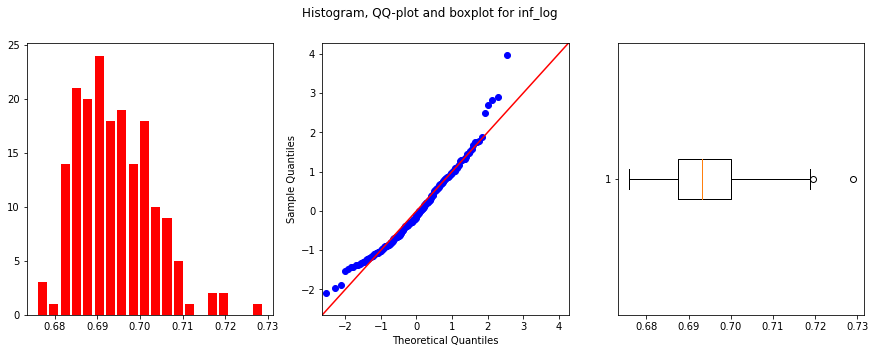

In [158]:
for city in city_index:
    inf = AnalyzNumCol(data[data.City == city], 'inf')
    inf.show_plots(log = True)

Выводы
------
Данные содержат выбросы, логорифмирование не улучшает данные

unem

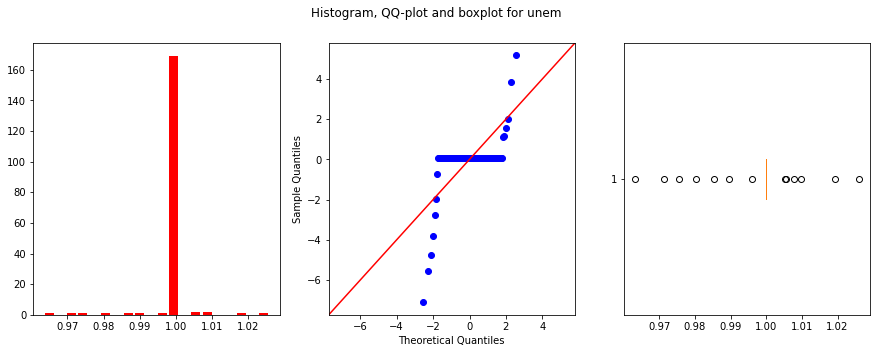

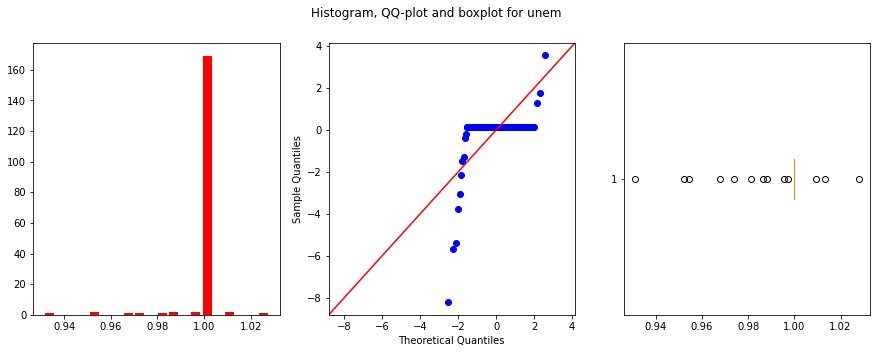

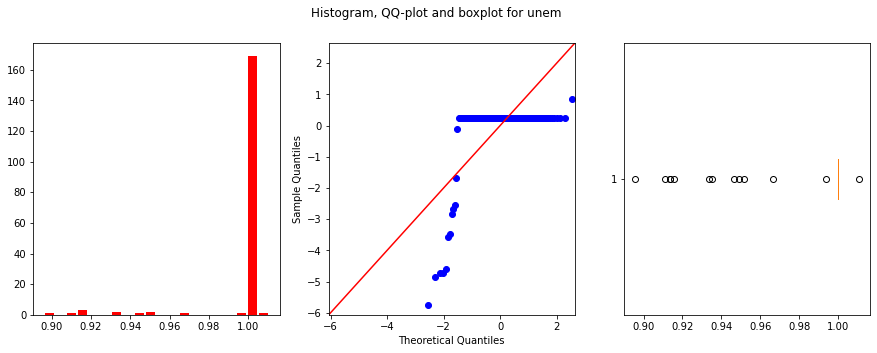

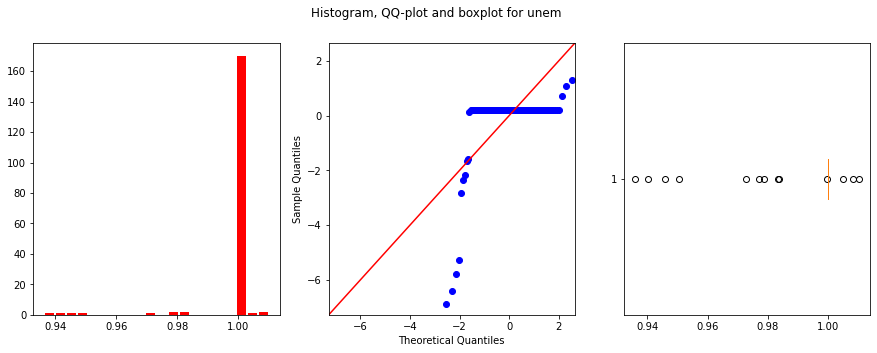

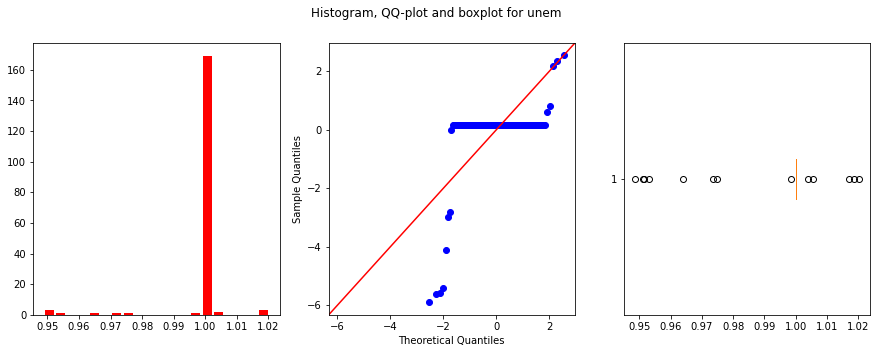

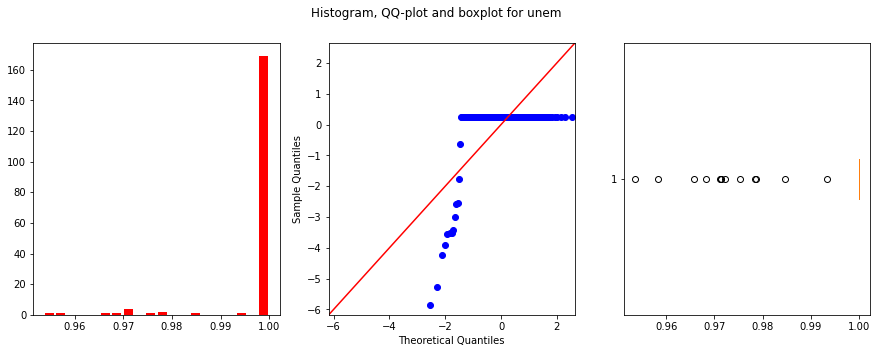

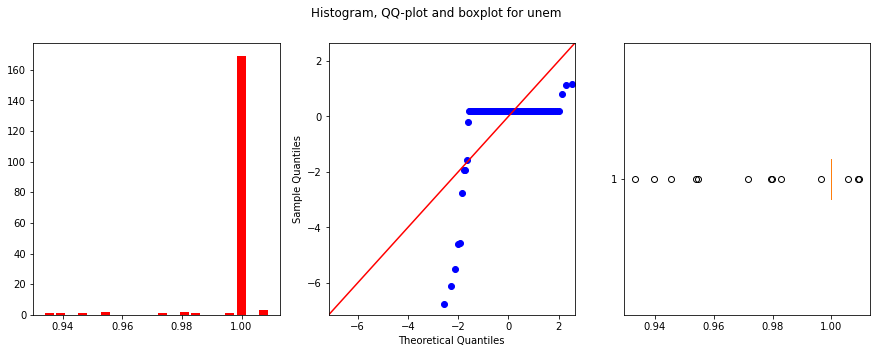

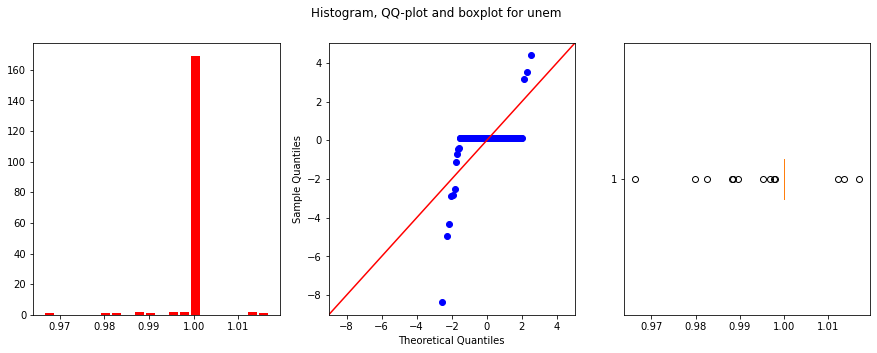

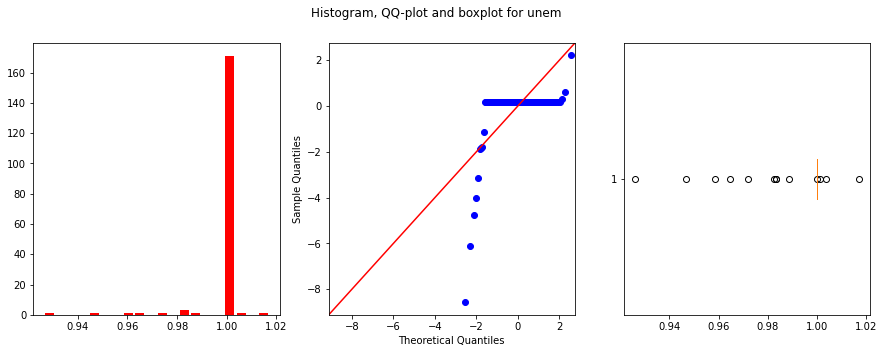

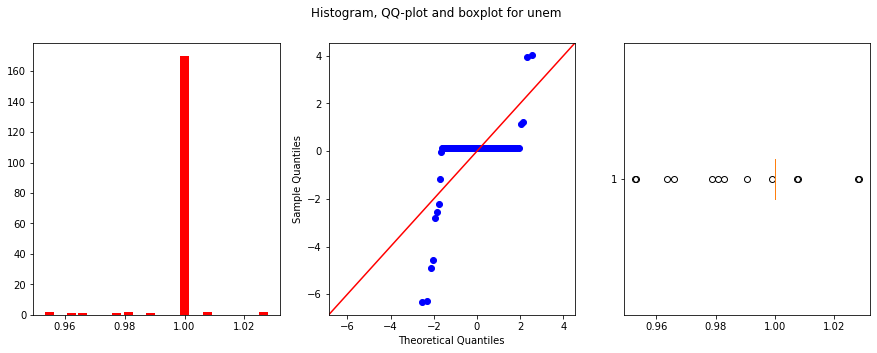

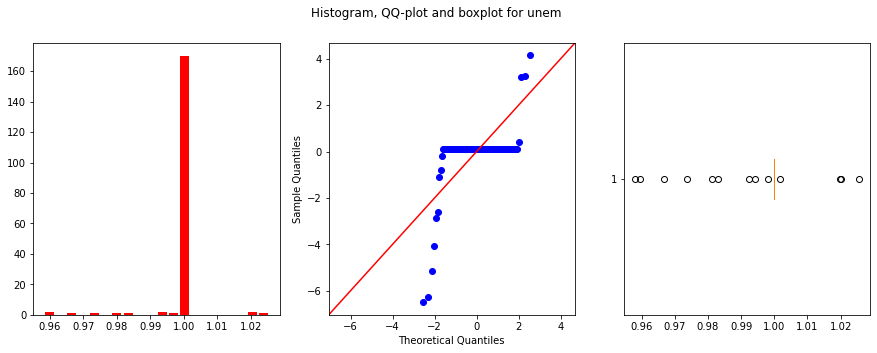

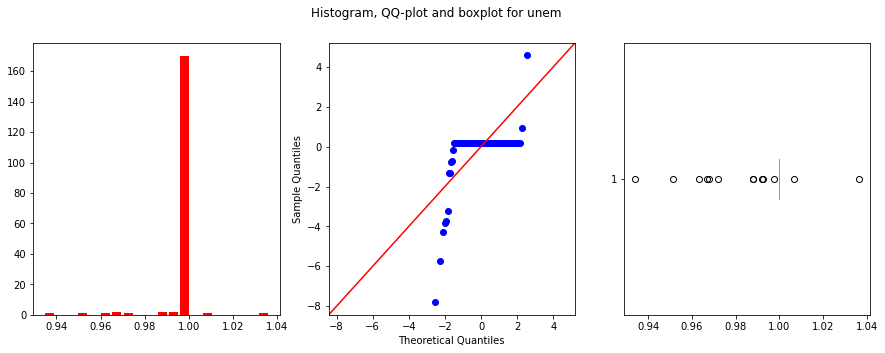

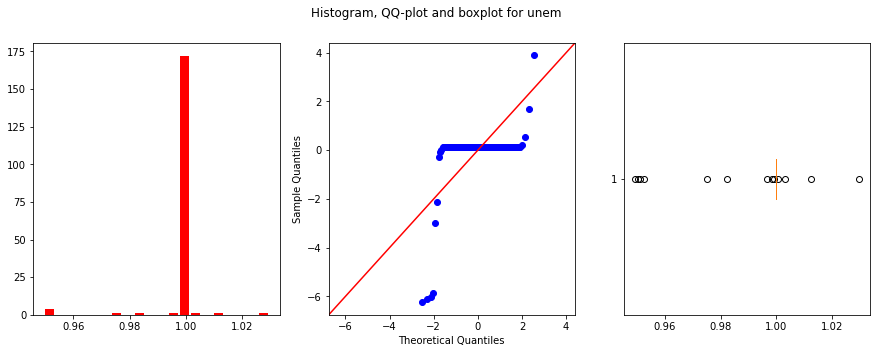

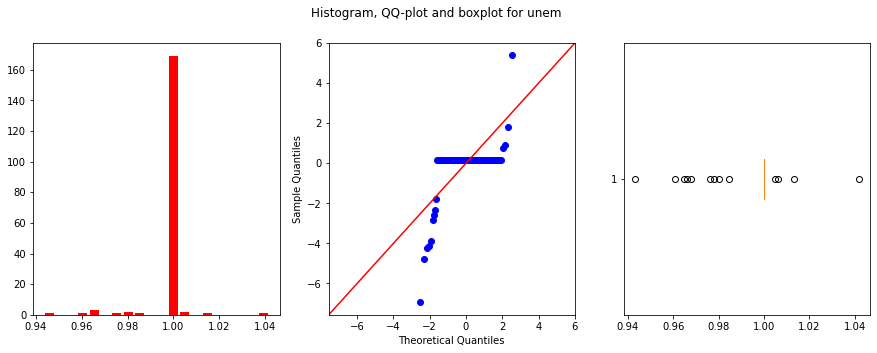

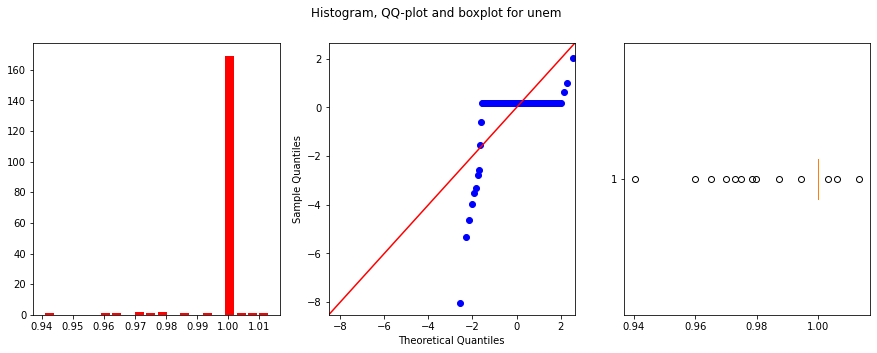

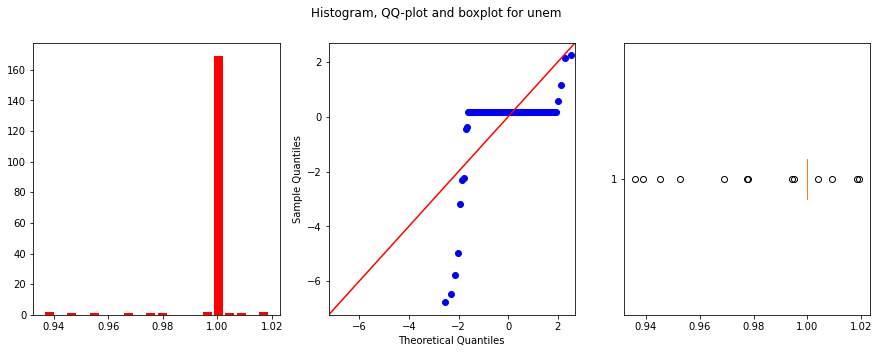

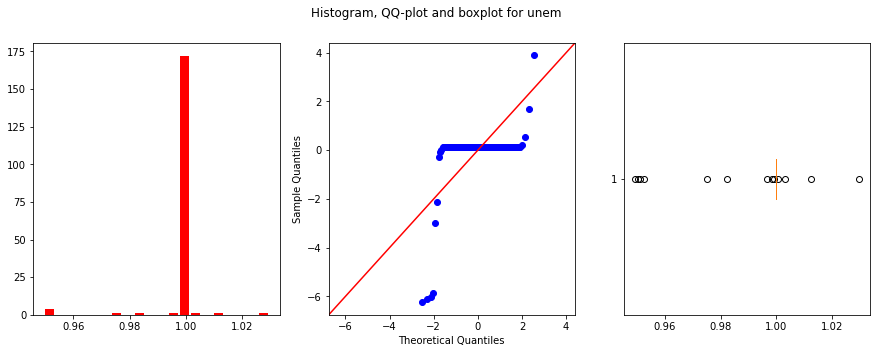

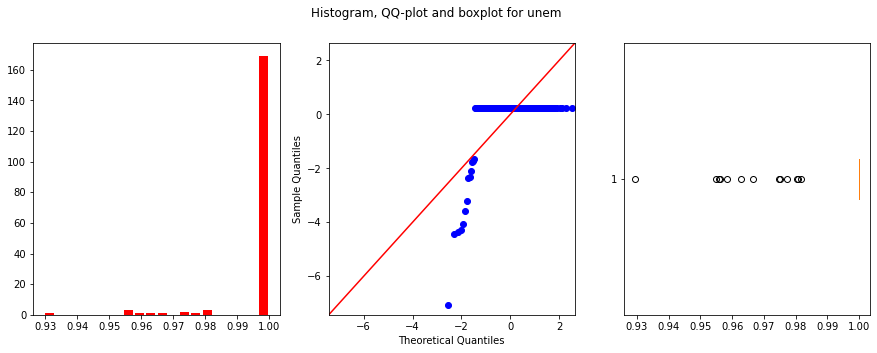

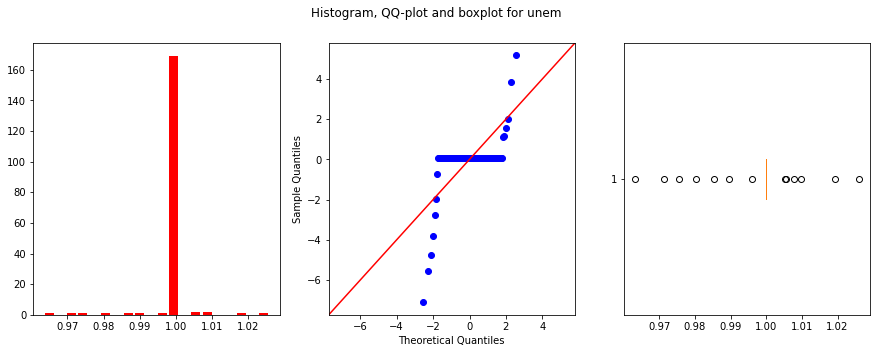

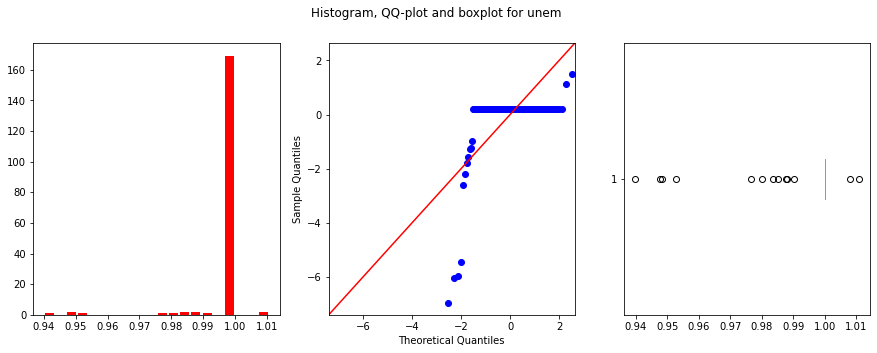

In [159]:
for city in city_index:
    unem = AnalyzNumCol(data[data.City == city], 'unem')
    unem.show_plots()

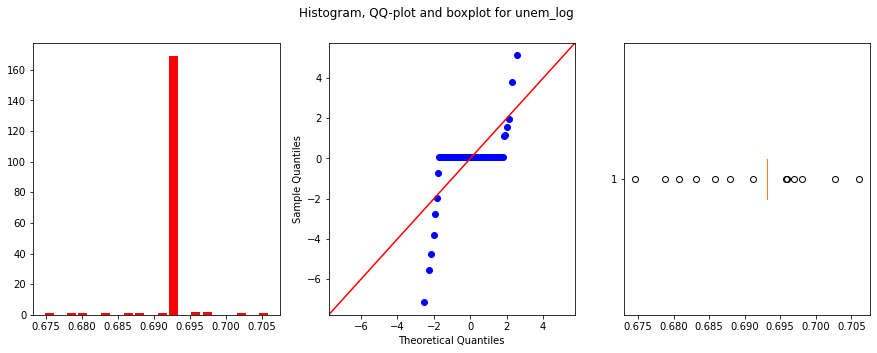

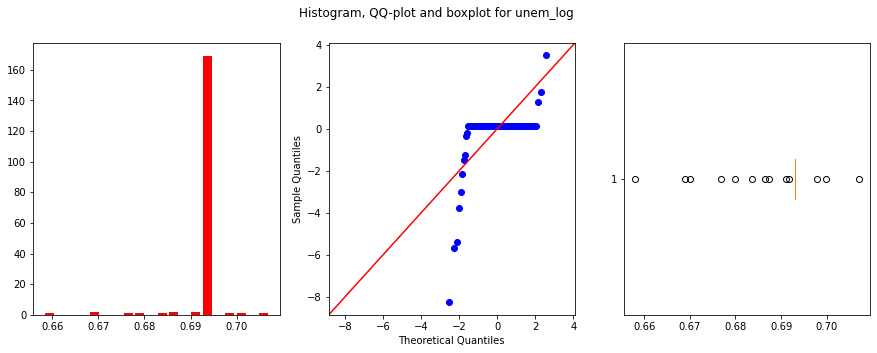

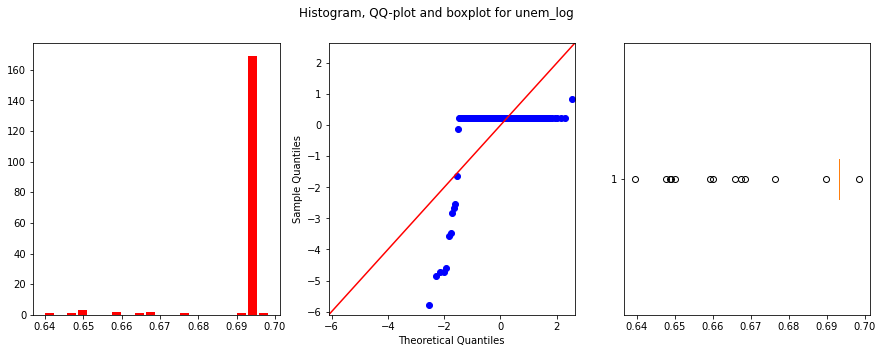

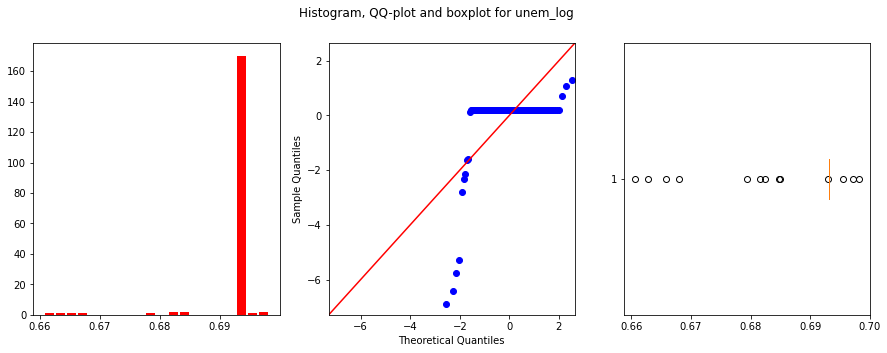

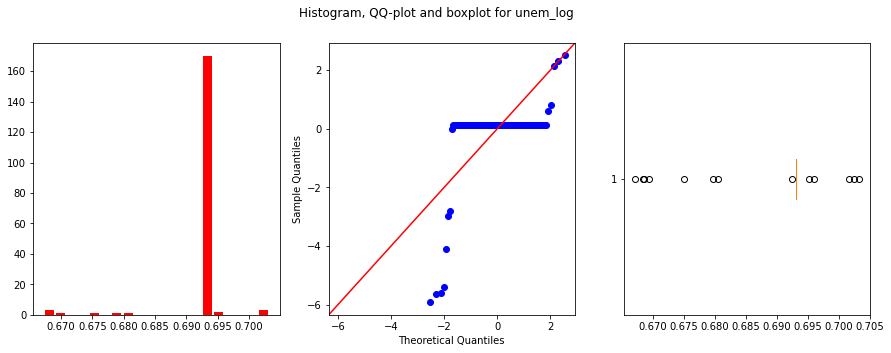

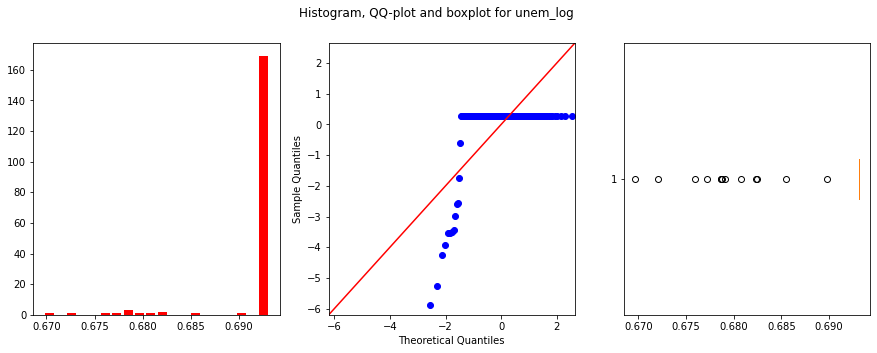

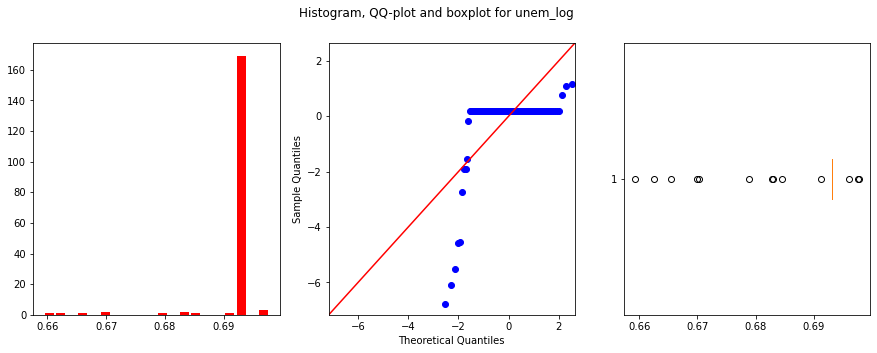

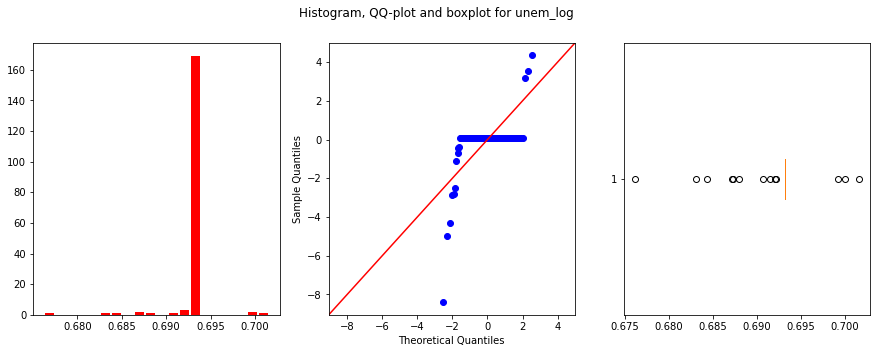

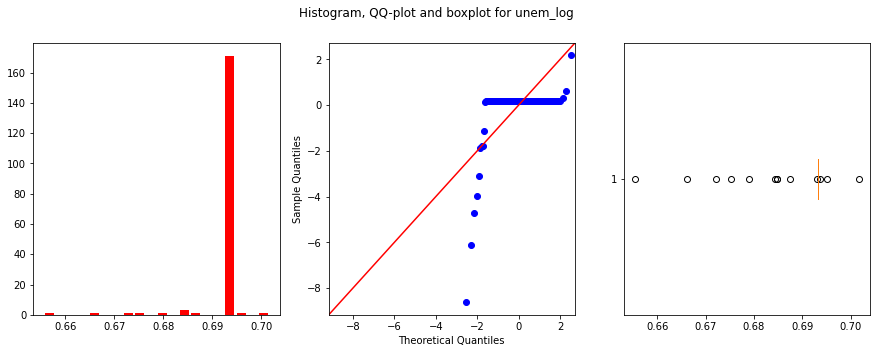

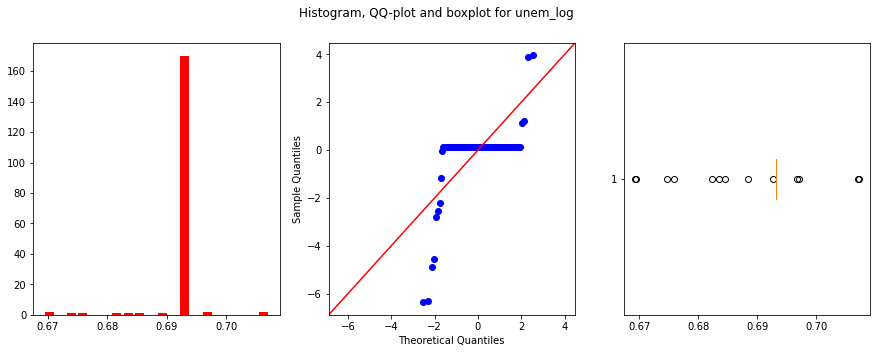

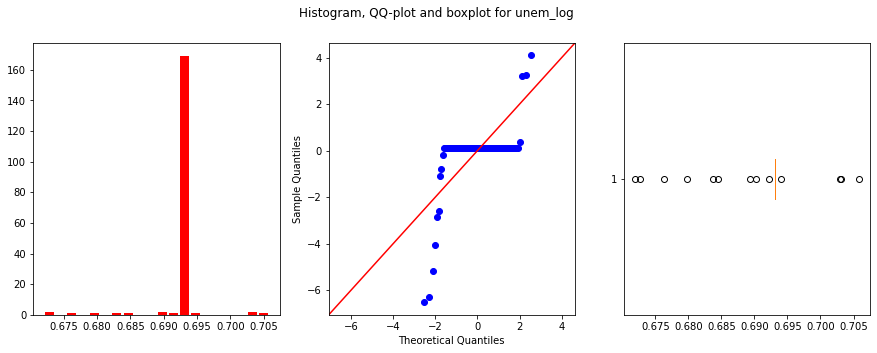

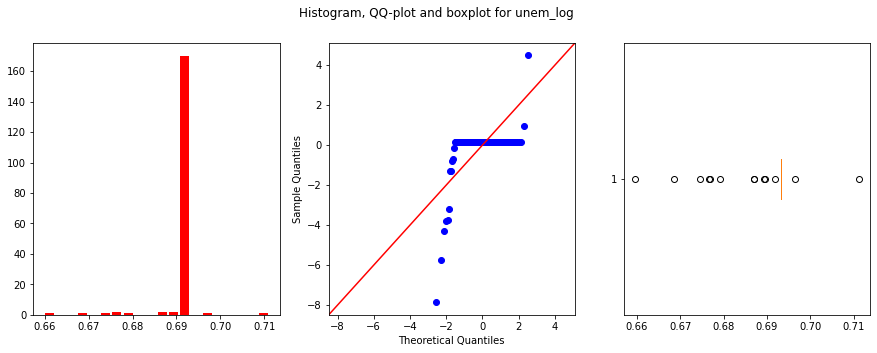

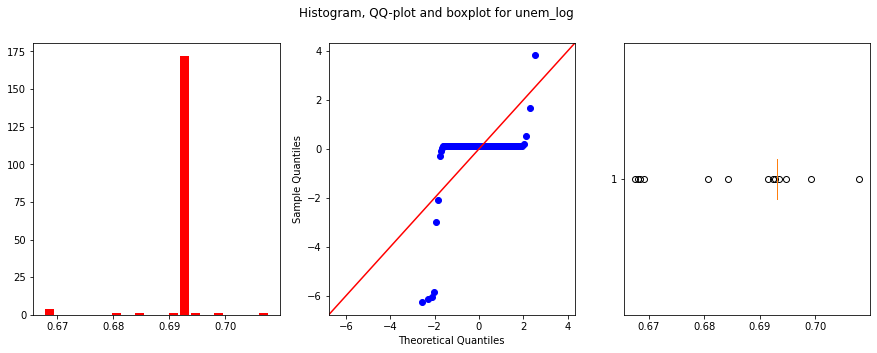

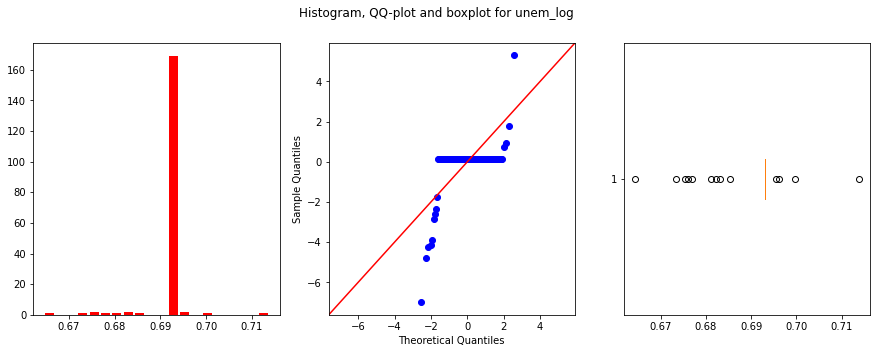

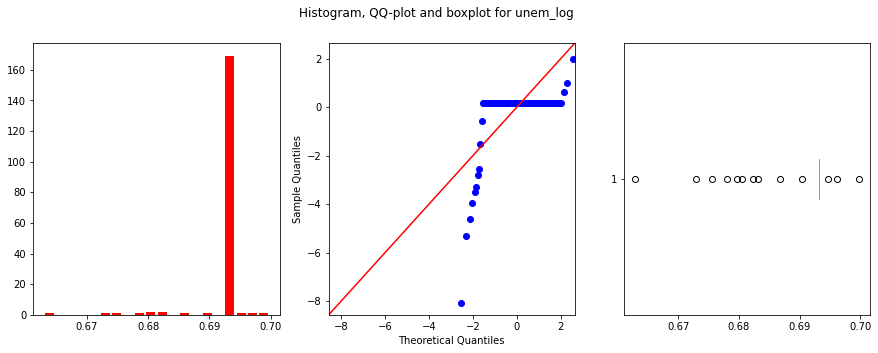

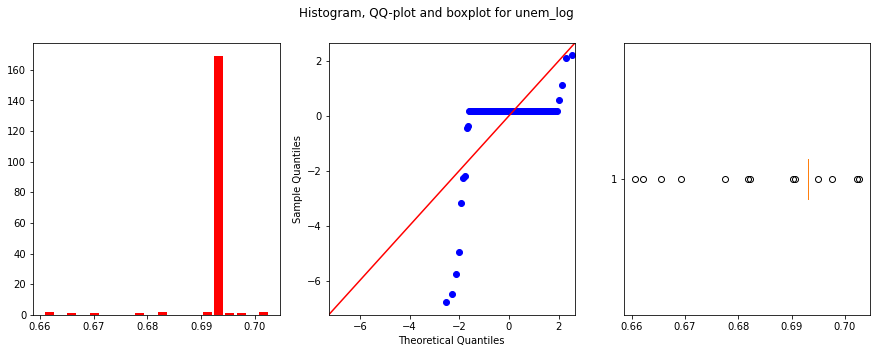

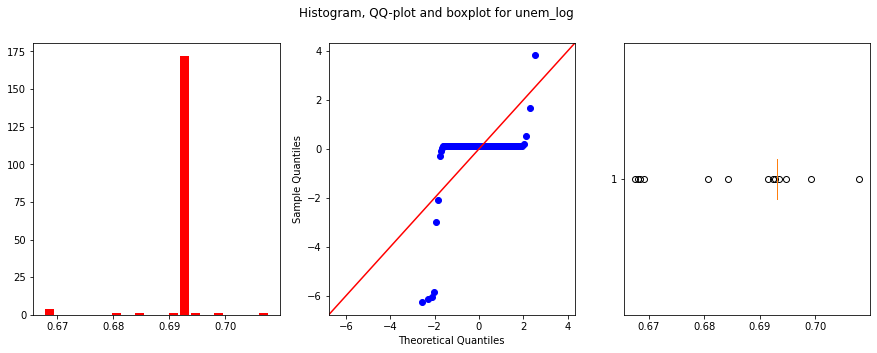

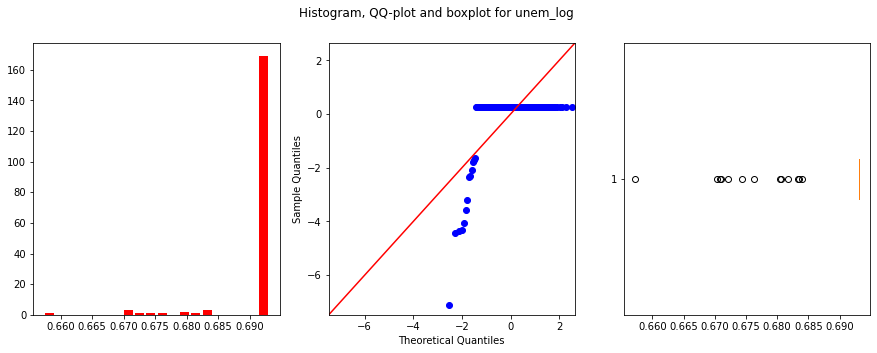

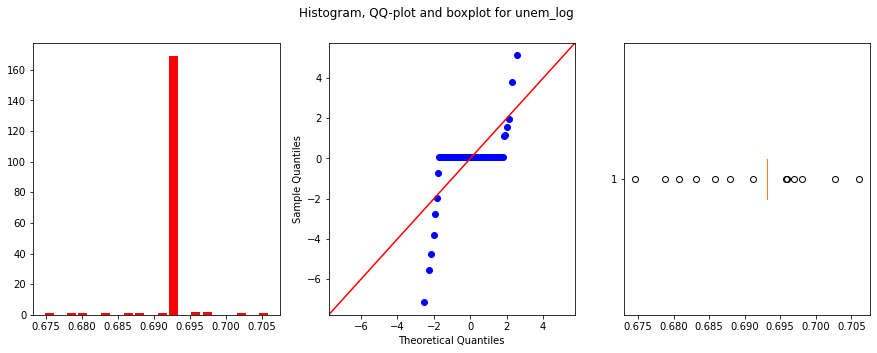

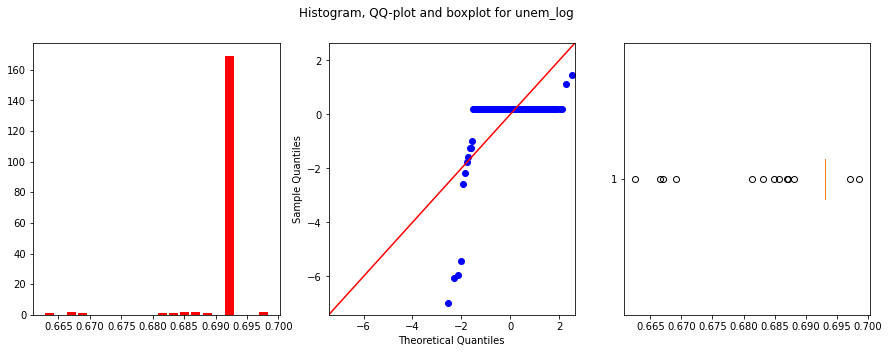

In [160]:
for city in city_index:
    unem = AnalyzNumCol(data[data.City == city], 'unem')
    unem.show_plots(log = True)

Выводы
------
Данные содержат выбросы, логорифмирование не улучшает данные

Size

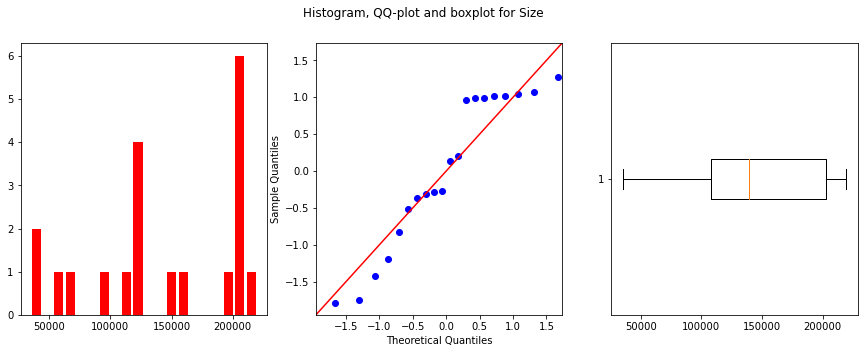

In [161]:
Size = AnalyzNumCol(restaurants, 'Size')
Size.show_plots()

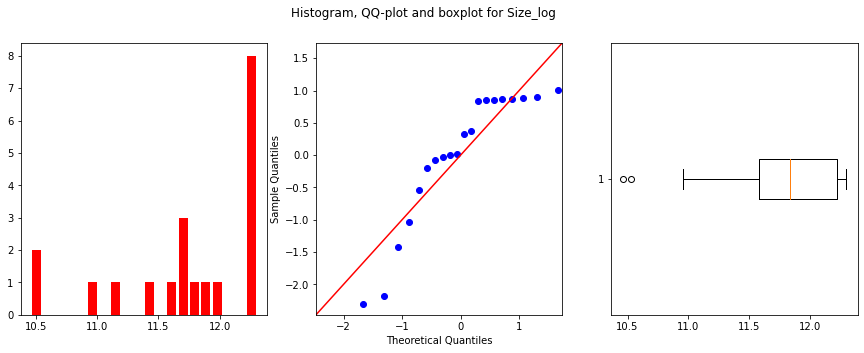

In [162]:
Size.show_plots(log = True)

Вывод
------
Данные нормально не распределны, логорифмирование ухудшает данные

In [163]:
train = train.merge(data.drop('IsHoliday', axis = 1), how = 'left', on = ['City', 'Date'])
train = train.merge(restaurants, how = 'left', on = 'City')

In [164]:
test = test.merge(data.drop('IsHoliday', axis = 1), how = 'left', on = ['City', 'Date'])
test = test.merge(restaurants, how = 'left', on = 'City')

In [165]:
train['IsHoliday'] = train['IsHoliday'].apply(lambda x: 1 if x == True else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x == True else 0)

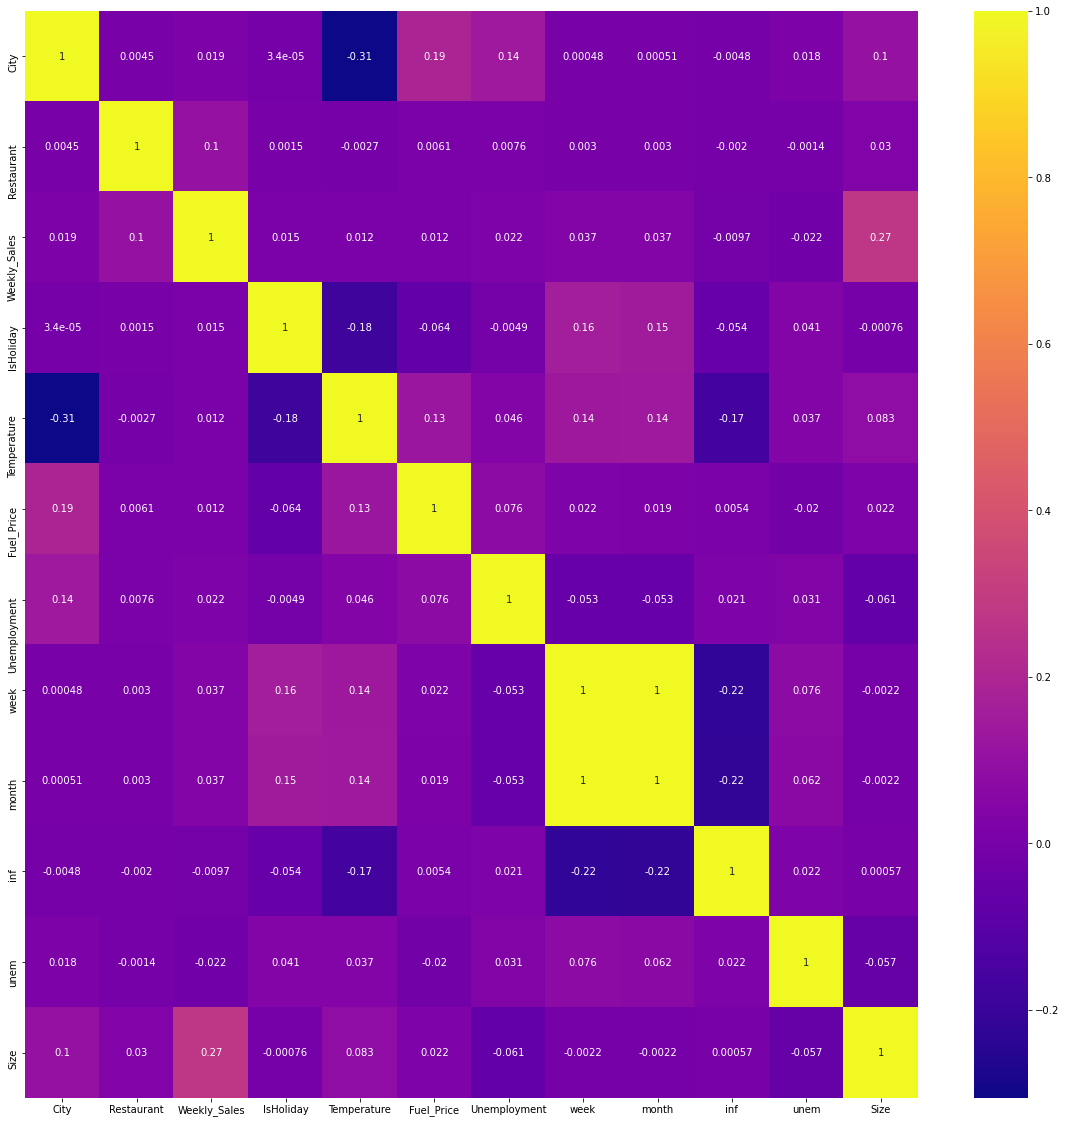

In [166]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(train.corr(),annot = True, cmap = 'plasma')

Вывод
------
Факторы имеют низкую корреляцию, все их можно исполльзовать для анализа

Проверим значимость непрерывных переменных (на основе однофакторного дисперсионного анализа (ANOVA)) Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости мы будем использовать значение f -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

<AxesSubplot:>

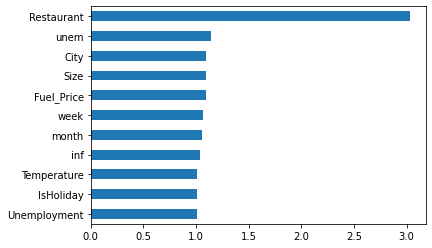

In [167]:
imp_num = Series(f_classif(train.drop(['Weekly_Sales', 'Date'], axis = 1), train['Weekly_Sales'])[0], index = train.drop(['Weekly_Sales', 'Date'], axis = 1).columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# 4. Построение модели

# 4.1 Линейная регрессия

In [168]:
X = train.drop(['Weekly_Sales', 'Date'], axis = 1)
Y = train['Weekly_Sales']

In [169]:
#X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [171]:
print(len(X))
print(len(X_train))
print(len(X_test))

137938
82762
55176


In [172]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [173]:
print(len(X))
print(len(X_train) + len(X_test) + len(X_val))

137938
137938


In [174]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [175]:
model.coef_

array([-1.17464789e+02,  8.33165404e+01,  6.11099796e+02, -3.63606828e+01,
        6.11442956e+02,  6.61178710e+02, -1.36031120e+02,  9.06423900e+02,
       -1.13005482e+04, -1.73497401e+04,  1.19228398e-01])

In [176]:
mean_squared_error(y_pred, y_val)

607226627.9587232

In [177]:
mape(y_pred, y_val)

1.2680306874014755

In [178]:
Y_ln = np.log(Y + 10000)

In [179]:
Y_ln.isna().sum()

0

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_ln, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [181]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [182]:
model.coef_

array([-1.57261812e-03,  3.26401483e-04,  8.23700108e-03, -7.12146444e-04,
        1.36079366e-02,  2.34463442e-02, -4.46940069e-03,  2.70686929e-02,
       -3.49617042e-01, -4.37523392e-01,  3.64495497e-06])

In [183]:
mean_squared_error(y_pred, y_val)

0.3751534203120815

In [184]:
mape(y_pred, y_val)

0.04912472312696067

In [185]:
1-mape(y_pred, y_val)

0.9508752768730393

# 4.2 Случайный лес

In [186]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [187]:
1-mape(y_test, y_pred)

0.9946511679983931

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [189]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [190]:
mean_squared_error(y_pred, y_val)

22472307.611215007

In [191]:
mape(y_pred, y_val)

0.19525860268158798

Подберем гиперпараметры модели

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_ln, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [193]:
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [194]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [196]:
model = RandomForestRegressor(random_state=42, 
                              n_estimators=300, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              max_features='sqrt', 
                              max_depth=None, 
                              bootstrap=False)


In [197]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=300,
                      random_state=42)

In [198]:
y_pred = model.predict(X_val)

In [200]:
1-mape(y_pred, y_val)

0.9697919343274639

### RandomizedSearchCV

In [204]:
model_forest = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 3, 
                                  cv = 3, verbose=2, random_state=42, n_jobs = -1)
model_forest.fit(X_train, y_train)


model_forest.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  2.4min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  6.3min finished


{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

In [205]:
model = RandomForestRegressor(random_state= 42, 
                              n_estimators= 600, 
                              min_samples_split= 2, 
                              min_samples_leaf= 2, 
                              max_features='auto', 
                              max_depth= 60, 
                              bootstrap=False)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

In [207]:
1-mape(y_val, y_pred)

0.9934588719129033

In [208]:
y_pred = model.predict(X_test)

In [209]:
1-mape(y_test, y_pred)

0.9934371497710541

# 4.3 CatBoost

In [211]:
ITERATIONS = 20000
model = CatBoostRegressor(loss_function = 'RMSE',
                          iterations = ITERATIONS,
                          depth = 8,
                          random_seed = 42,
                          eval_metric='MAPE'
                         )
model.fit(X_train, y_train,
          eval_set=(X_val, y_val),
          verbose_eval=500,
          use_best_model=True,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.016422
0:	learn: 0.0520196	test: 0.0520779	best: 0.0520779 (0)	total: 91ms	remaining: 30m 19s
500:	learn: 0.0194608	test: 0.0193602	best: 0.0193602 (500)	total: 6.5s	remaining: 4m 13s
1000:	learn: 0.0143762	test: 0.0144063	best: 0.0144063 (1000)	total: 12.6s	remaining: 3m 59s
1500:	learn: 0.0119664	test: 0.0120824	best: 0.0120824 (1500)	total: 20.7s	remaining: 4m 15s
2000:	learn: 0.0105700	test: 0.0107493	best: 0.0107493 (2000)	total: 29.4s	remaining: 4m 24s
2500:	learn: 0.0096754	test: 0.0099031	best: 0.0099031 (2500)	total: 38.1s	remaining: 4m 26s
3000:	learn: 0.0089683	test: 0.0092330	best: 0.0092330 (3000)	total: 47.1s	remaining: 4m 26s
3500:	learn: 0.0084141	test: 0.0087190	best: 0.0087190 (3500)	total: 56.8s	remaining: 4m 27s
4000:	learn: 0.0079610	test: 0.0082976	best: 0.0082976 (4000)	total: 1m 5s	remaining: 4m 23s
4500:	learn: 0.0075756	test: 0.0079419	best: 0.0079419 (4500)	total: 1m 15s	remaining: 4m 18s
5000:	learn: 0.0072532	test: 0.0076471	best: 0.0

In [212]:
y_pred = model.predict(X_test)
mape(y_test, y_pred)

0.005098473767301549

Применим кросс-валидацию с 5 фолдами

In [222]:
def CV_cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(loss_function = 'RMSE',
                              iterations = 20000,
                              depth = 8,
                              random_seed = 42,
                              eval_metric='MAPE'
                             )
    model.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              verbose_eval=500,
              use_best_model=True,
              plot=False)
    
    return(model)

In [223]:
N_FOLDS = 5
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=42).split(X,Y_ln))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    Xf_train, yf_train, Xf_test, yf_test = X.loc[train_idx], Y_ln.loc[train_idx], X.loc[test_idx], Y_ln.loc[test_idx]
    
    model = CV_cat_model(yf_train, Xf_train, Xf_test, yf_test)
    
    # score model on test
    test_predict = model.predict(Xf_test)
    test_score = mape(yf_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(yf_test, test_predict)*100:0.4f}%")
    # submissions
    model.save_model(f'catboost_fold_{idx+1}.model')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.017339
0:	learn: 0.0520655	test: 0.0522537	best: 0.0522537 (0)	total: 15.7ms	remaining: 5m 14s
500:	learn: 0.0189347	test: 0.0188617	best: 0.0188617 (500)	total: 6.22s	remaining: 4m 2s
1000:	learn: 0.0139309	test: 0.0139378	best: 0.0139378 (1000)	total: 12.5s	remaining: 3m 58s
1500:	learn: 0.0117197	test: 0.0117715	best: 0.0117715 (1500)	total: 20s	remaining: 4m 7s
2000:	learn: 0.0103683	test: 0.0104518	best: 0.0104518 (2000)	total: 29s	remaining: 4m 21s
2500:	learn: 0.0094737	test: 0.0095878	best: 0.0095878 (2500)	total: 37.8s	remaining: 4m 24s
3000:	learn: 0.0087854	test: 0.0089149	best: 0.0089149 (3000)	total: 46.4s	remaining: 4m 22s
3500:	learn: 0.0082361	test: 0.0083870	best: 0.0083870 (3500)	total: 55s	remaining: 4m 19s
4000:	learn: 0.0077695	test: 0.0079429	best: 0.0079429 (4000)	total: 1m 3s	remaining: 4m 14s
4500:	learn: 0.0073890	test: 0.0075833	best: 0.0075833 (4500)	total: 1m 12s	remaining: 4m 9s
5000:	learn: 0.0070881	test: 0.0073049	best: 0.0073049 

 20%|████████████████▌                                                                  | 1/5 [05:43<22:53, 343.44s/it]

1 Fold Test MAPE: 0.4841%
Learning rate set to 0.017339
0:	learn: 0.0520378	test: 0.0522343	best: 0.0522343 (0)	total: 23.2ms	remaining: 7m 43s
500:	learn: 0.0189987	test: 0.0189300	best: 0.0189300 (500)	total: 8.41s	remaining: 5m 27s
1000:	learn: 0.0139667	test: 0.0139839	best: 0.0139839 (1000)	total: 16.9s	remaining: 5m 21s
1500:	learn: 0.0117417	test: 0.0118224	best: 0.0118224 (1500)	total: 25.4s	remaining: 5m 12s
2000:	learn: 0.0103901	test: 0.0105167	best: 0.0105167 (2000)	total: 34s	remaining: 5m 5s
2500:	learn: 0.0094651	test: 0.0096377	best: 0.0096377 (2500)	total: 42.6s	remaining: 4m 57s
3000:	learn: 0.0087638	test: 0.0089752	best: 0.0089752 (3000)	total: 51.2s	remaining: 4m 50s
3500:	learn: 0.0082233	test: 0.0084669	best: 0.0084669 (3500)	total: 59.8s	remaining: 4m 41s
4000:	learn: 0.0077744	test: 0.0080428	best: 0.0080428 (4000)	total: 1m 8s	remaining: 4m 33s
4500:	learn: 0.0073971	test: 0.0076894	best: 0.0076894 (4500)	total: 1m 16s	remaining: 4m 25s
5000:	learn: 0.0070747	

 40%|█████████████████████████████████▏                                                 | 2/5 [11:33<17:16, 345.56s/it]

2 Fold Test MAPE: 0.4896%
Learning rate set to 0.017339
0:	learn: 0.0521746	test: 0.0519184	best: 0.0519184 (0)	total: 16.3ms	remaining: 5m 26s
500:	learn: 0.0188393	test: 0.0189991	best: 0.0189991 (500)	total: 8.34s	remaining: 5m 24s
1000:	learn: 0.0139731	test: 0.0141080	best: 0.0141080 (1000)	total: 16.8s	remaining: 5m 19s
1500:	learn: 0.0117409	test: 0.0118898	best: 0.0118898 (1500)	total: 25.4s	remaining: 5m 13s
2000:	learn: 0.0103673	test: 0.0105526	best: 0.0105526 (2000)	total: 34.1s	remaining: 5m 6s
2500:	learn: 0.0094595	test: 0.0096765	best: 0.0096765 (2500)	total: 42.8s	remaining: 4m 59s
3000:	learn: 0.0087555	test: 0.0090023	best: 0.0090023 (3000)	total: 51.5s	remaining: 4m 51s
3500:	learn: 0.0082022	test: 0.0084695	best: 0.0084695 (3500)	total: 1m	remaining: 4m 43s
4000:	learn: 0.0077635	test: 0.0080522	best: 0.0080522 (4000)	total: 1m 8s	remaining: 4m 35s
4500:	learn: 0.0073832	test: 0.0076907	best: 0.0076907 (4500)	total: 1m 17s	remaining: 4m 27s
5000:	learn: 0.0070528	t

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [17:32<11:38, 349.37s/it]

3 Fold Test MAPE: 0.4915%
Learning rate set to 0.017339
0:	learn: 0.0521126	test: 0.0518778	best: 0.0518778 (0)	total: 26ms	remaining: 8m 39s
500:	learn: 0.0188332	test: 0.0189995	best: 0.0189995 (500)	total: 9.39s	remaining: 6m 5s
1000:	learn: 0.0139766	test: 0.0141241	best: 0.0141241 (1000)	total: 18.6s	remaining: 5m 53s
1500:	learn: 0.0117227	test: 0.0118660	best: 0.0118660 (1500)	total: 27.3s	remaining: 5m 36s
2000:	learn: 0.0103764	test: 0.0105160	best: 0.0105160 (2000)	total: 36s	remaining: 5m 24s
2500:	learn: 0.0094891	test: 0.0096450	best: 0.0096450 (2500)	total: 44.8s	remaining: 5m 13s
3000:	learn: 0.0088171	test: 0.0089952	best: 0.0089952 (3000)	total: 54.3s	remaining: 5m 7s
3500:	learn: 0.0082843	test: 0.0084770	best: 0.0084770 (3500)	total: 1m 4s	remaining: 5m 1s
4000:	learn: 0.0078296	test: 0.0080365	best: 0.0080365 (4000)	total: 1m 12s	remaining: 4m 51s
4500:	learn: 0.0074527	test: 0.0076725	best: 0.0076725 (4500)	total: 1m 21s	remaining: 4m 41s
5000:	learn: 0.0071325	tes

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [23:32<05:52, 352.66s/it]

4 Fold Test MAPE: 0.4815%
Learning rate set to 0.017339
0:	learn: 0.0520528	test: 0.0521641	best: 0.0521641 (0)	total: 18.1ms	remaining: 6m 1s
500:	learn: 0.0188371	test: 0.0188622	best: 0.0188622 (500)	total: 8.41s	remaining: 5m 27s
1000:	learn: 0.0138992	test: 0.0139492	best: 0.0139492 (1000)	total: 17s	remaining: 5m 22s
1500:	learn: 0.0116598	test: 0.0117382	best: 0.0117382 (1500)	total: 25.6s	remaining: 5m 15s
2000:	learn: 0.0103420	test: 0.0104369	best: 0.0104369 (2000)	total: 34.2s	remaining: 5m 8s
2500:	learn: 0.0094531	test: 0.0095781	best: 0.0095781 (2500)	total: 42.9s	remaining: 5m
3000:	learn: 0.0087670	test: 0.0089195	best: 0.0089195 (3000)	total: 51.6s	remaining: 4m 52s
3500:	learn: 0.0082301	test: 0.0084101	best: 0.0084101 (3500)	total: 1m	remaining: 4m 44s
4000:	learn: 0.0077728	test: 0.0079822	best: 0.0079822 (4000)	total: 1m 9s	remaining: 4m 36s
4500:	learn: 0.0073853	test: 0.0076228	best: 0.0076228 (4500)	total: 1m 17s	remaining: 4m 27s
5000:	learn: 0.0070643	test: 0.

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [29:25<00:00, 353.07s/it]

5 Fold Test MAPE: 0.4879%


Вывод
------

Можно также использовать методы: Bagging, GradientBoosting, Stacking

In [229]:
test_X = test.drop(['Date'], axis = 1)

In [234]:
y_pred = model.predict(test_X)

In [239]:
y_pred = pd.DataFrame(y_pred)

In [244]:
test = test.join(y_pred)

In [246]:
test = test.drop(['Temperature', 'Fuel_Price', 'Unemployment', 'month', 'inf', 'unem', 'Size'], axis = 1)

In [248]:
test = test.drop('week', axis = 1)

In [252]:
test.columns = ['City', 'Restaurant', 'Date', 'IsHoliday', 'Weekly_Sales']

In [255]:
test['Weekly_Sales'] = test['Weekly_Sales'].apply(lambda x: math.exp(x))

In [257]:
test['Weekly_Sales'] = test['Weekly_Sales'] - 10000

In [258]:
test.head()

City  Restaurant       Date  IsHoliday  Weekly_Sales
0     1           1 2012-01-06          0  14493.073894
1     1           1 2012-01-13          0  14424.250621
2     1           1 2012-01-20          0  15317.926395
3     1           1 2012-01-27          0  15356.942986
4     1           1 2012-02-03          0  24935.895789

In [259]:
test.to_csv('test_prod.csv')